## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data (no outlier)

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("/kaggle/input/cleean-data/cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

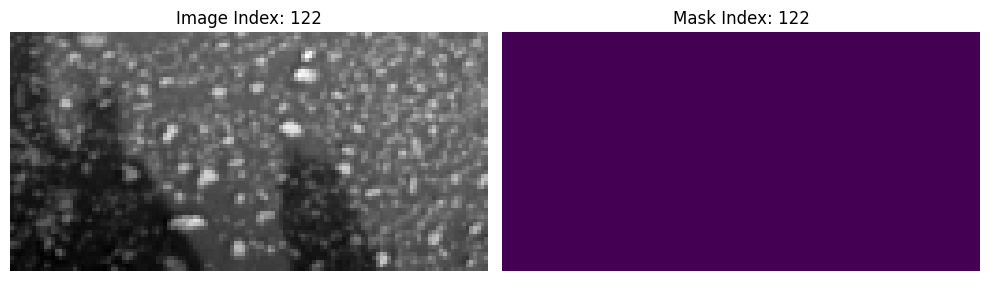

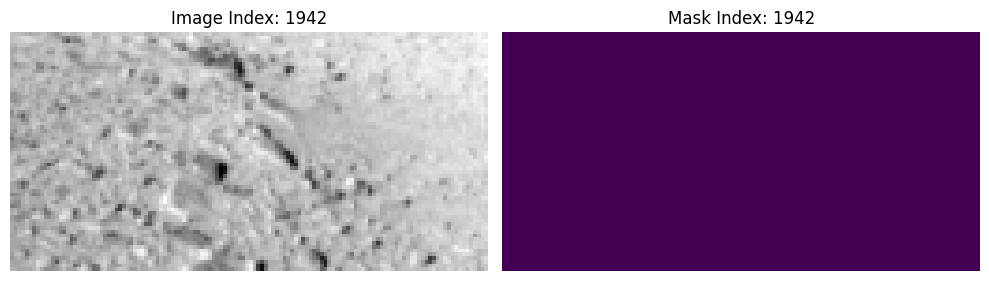

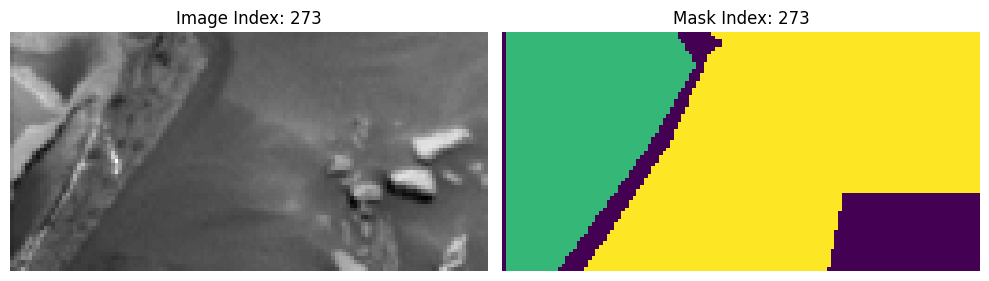

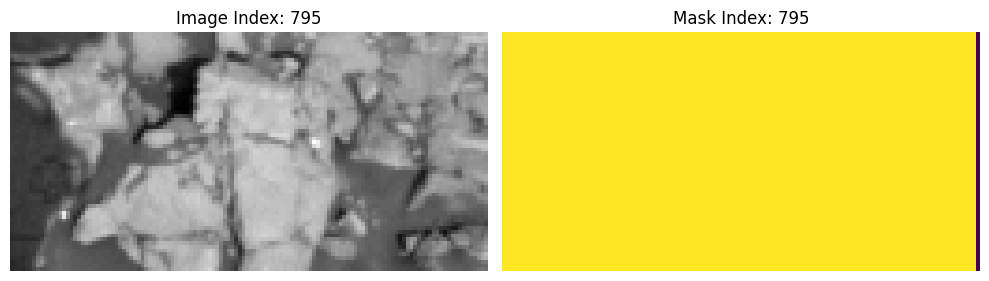

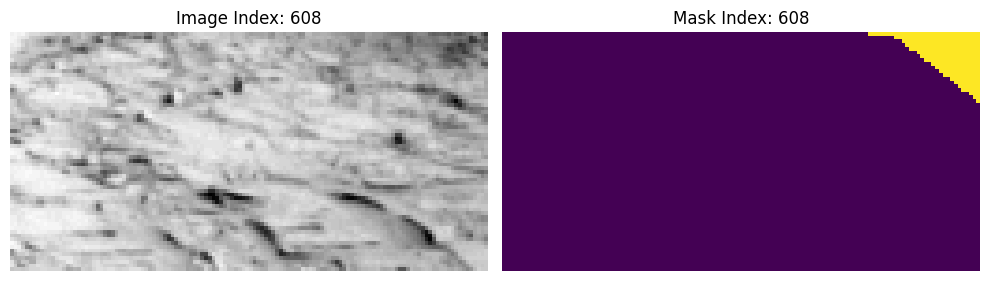

In [3]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

## invert image and noise

/tmp/ipykernel_23/1632159539.py:66: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(images), 6, i * 6 + 3)
/tmp/ipykernel_23/1632159539.py:88: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


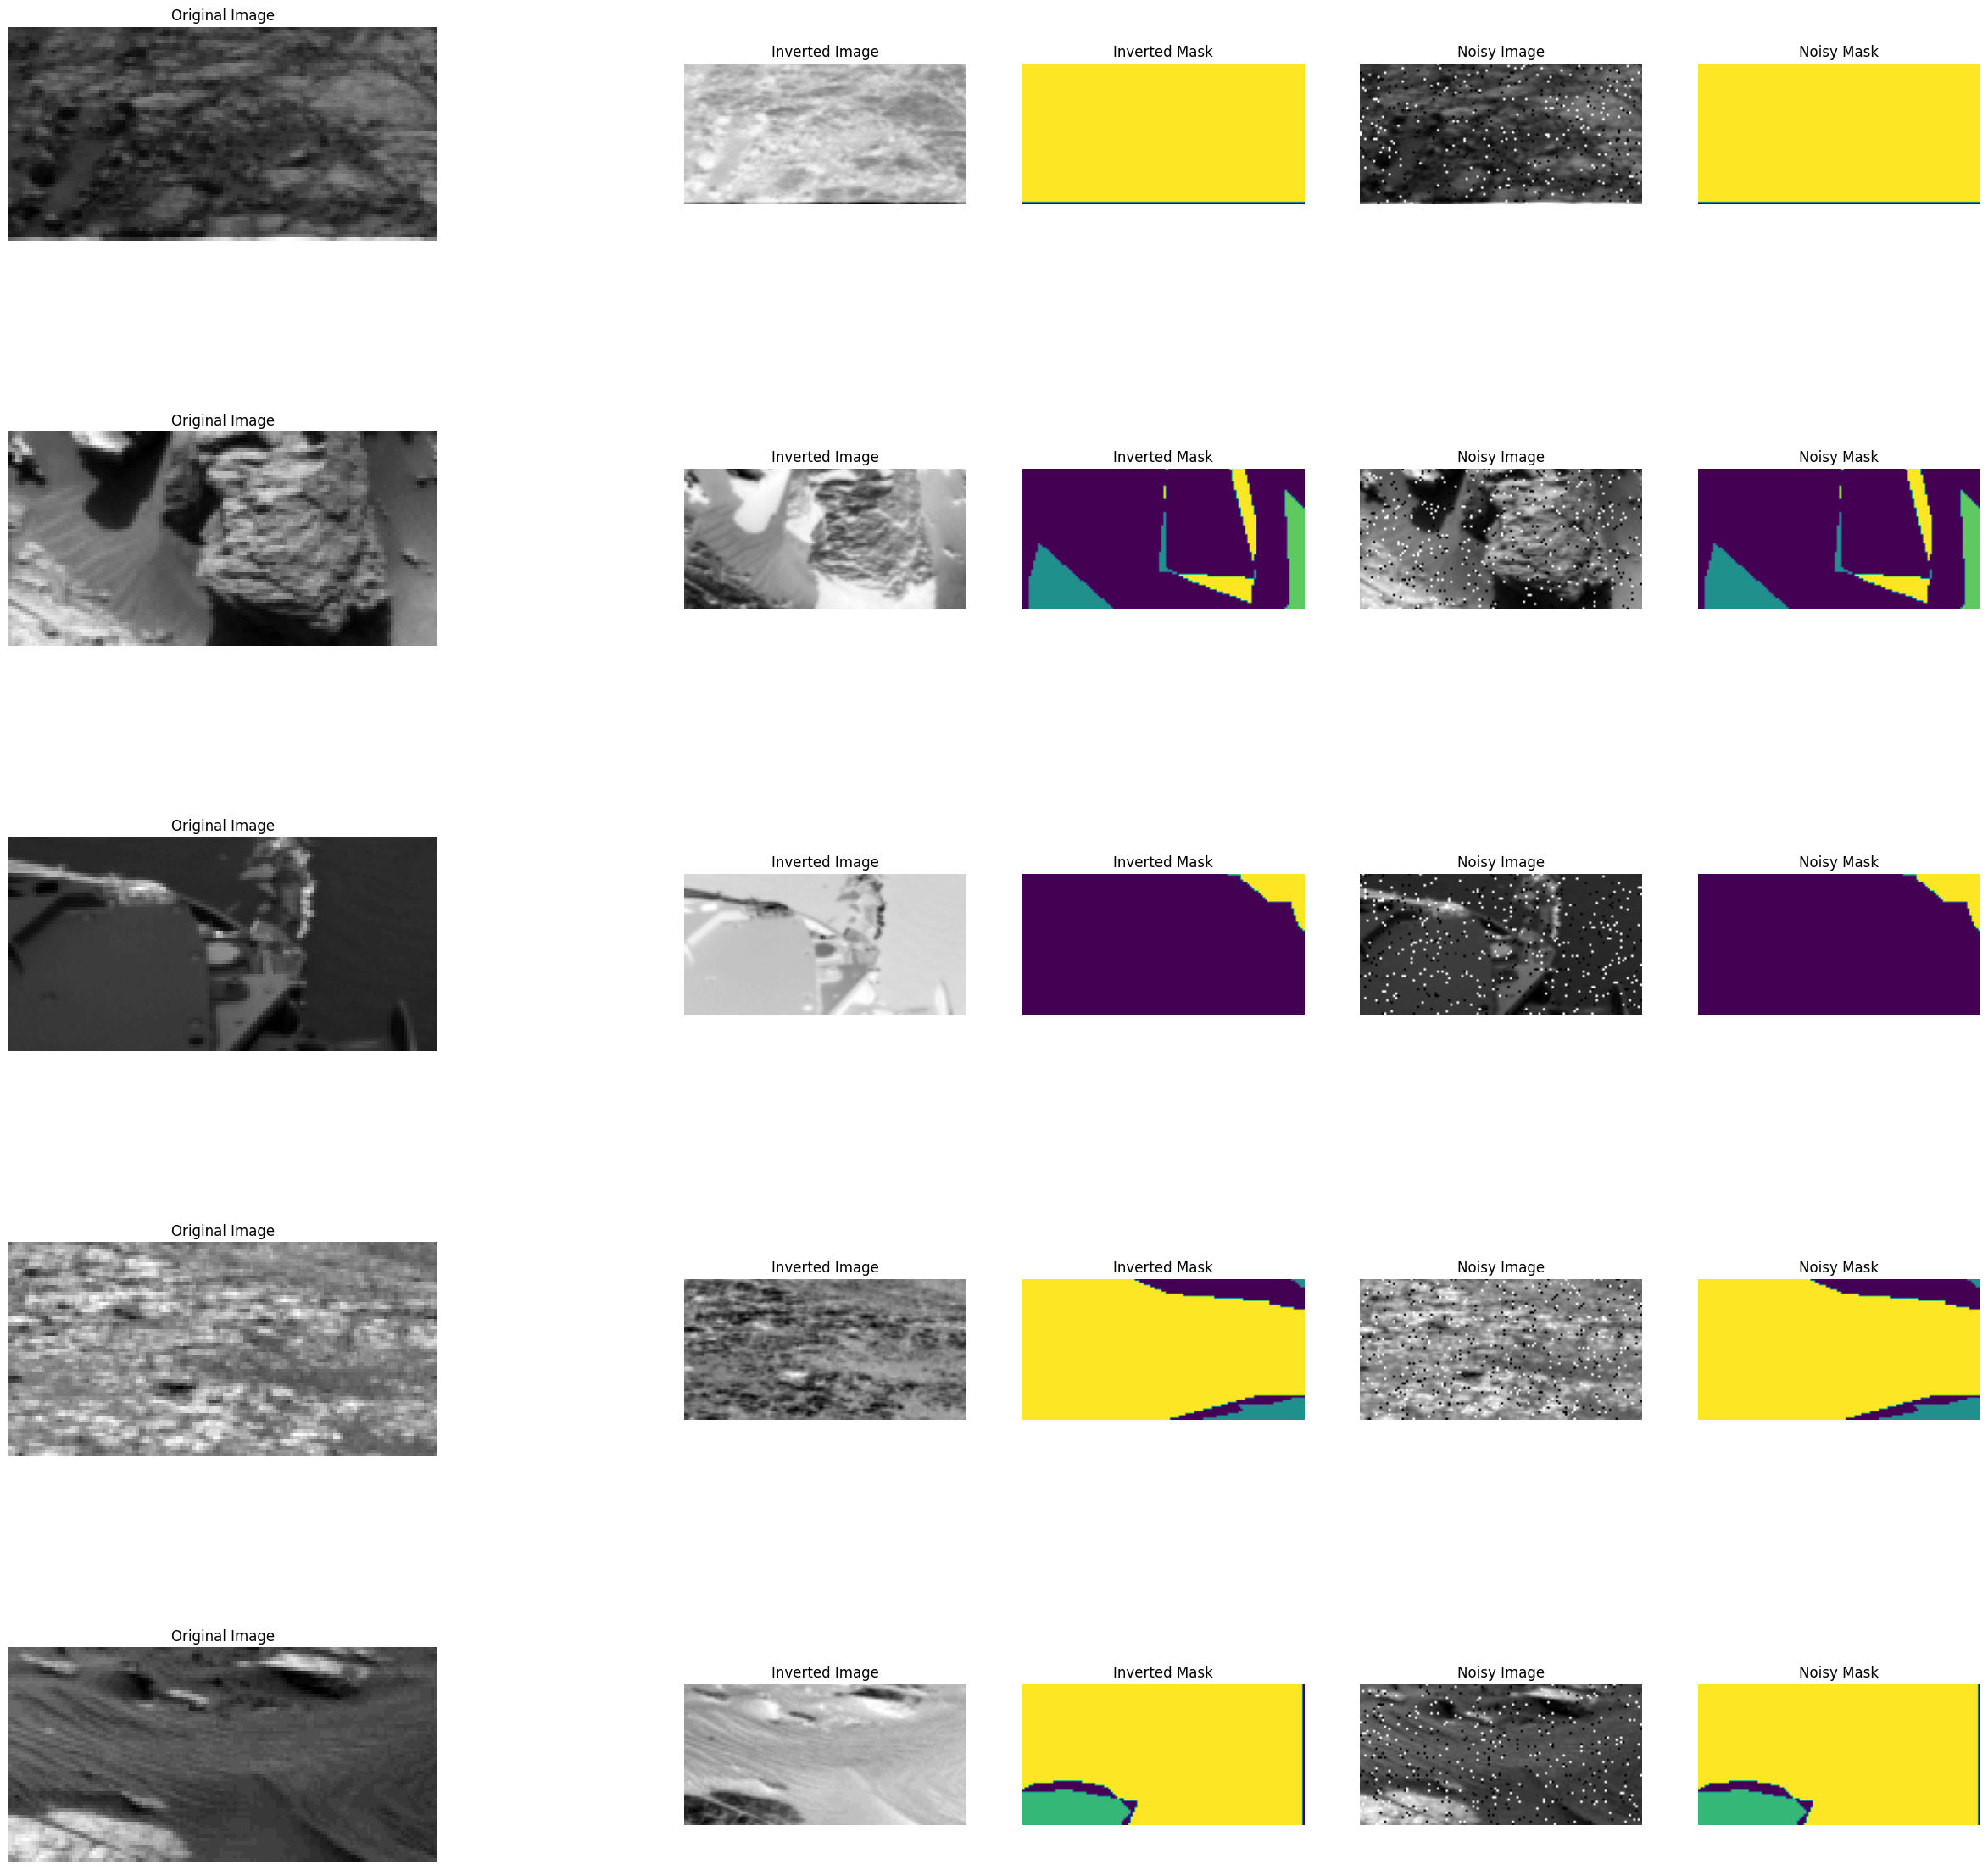

In [4]:


import numpy as np
from skimage.util import random_noise

# Define augmentation functions with mask handling
def invert_image(image, mask):
    return 255 - image, mask  # Mask remains unchanged

def add_salt_and_pepper_noise(image, mask, prob=0.03):
    """
    Add salt-and-pepper noise to an image while maintaining its original value range.

    Args:
        image (np.ndarray): Input image.
        mask (np.ndarray): Corresponding mask (unchanged).
        prob (float): Probability of noise per pixel.

    Returns:
        noisy_image (np.ndarray): Image with noise applied.
        mask (np.ndarray): Unchanged mask.
    """
    # Save the original range
    original_min = image.min()
    original_max = image.max()

    # Normalize the image to [0, 1]
    normalized_image = (image - original_min) / (original_max - original_min)

    # Generate random noise map
    random_map = np.random.random(image.shape)
    noisy_image = normalized_image.copy()
    noisy_image[random_map < prob] = 0  # Pepper
    noisy_image[random_map > (1 - prob)] = 1  # Salt

    # Rescale back to the original range
    noisy_image = noisy_image * (original_max - original_min) + original_min
    noisy_image = noisy_image.astype(image.dtype)  # Ensure the original data type is preserved

    return noisy_image, mask

"""def rotate_image(image, mask, angle):
    rotated_image = rotate(image, angle, reshape=False, mode='constant', cval=0)
    rotated_mask = rotate(mask, angle, reshape=False, mode='constant', order=0)
    return rotated_image, rotated_mask"""
"""
def adjust_brightness(image, mask, factor=1.2):
    brightened_image = np.clip(image * factor, 0, 255).astype(np.uint8)
    return brightened_image, mask  # Mask remains unchanged"""

# Visualize augmentations with masks
def visualize_all_augmentations(images, masks):
    plt.figure(figsize=(30, 30))
    for i, (image, mask) in enumerate(zip(images, masks)):
        # Original image and mask
        plt.subplot(len(images), 4, i * 4 + 1)
        plt.imshow(image, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(len(images), 4, i * 4 + 2)
        plt.imshow(mask, cmap="viridis")
        plt.title("Original Mask")
        plt.axis("off")

        # Inversion
        inverted_image, inverted_mask = invert_image(image, mask)
        plt.subplot(len(images), 6, i * 6 + 3)
        plt.imshow(inverted_image, cmap="gray")
        plt.title("Inverted Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 4)
        plt.imshow(inverted_mask, cmap="viridis")
        plt.title("Inverted Mask")
        plt.axis("off")

        # Noise
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        plt.subplot(len(images), 6, i * 6 + 5)
        plt.imshow(noisy_image, cmap="gray")
        plt.title("Noisy Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 6)
        plt.imshow(noisy_mask, cmap="viridis")
        plt.title("Noisy Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Randomly select 5 samples from the dataset
random_indices = np.random.choice(len(X_train), size=5, replace=False)
sample_images = X_train[random_indices]
sample_masks = y_train[random_indices]

# Visualize augmentations
visualize_all_augmentations(sample_images, sample_masks)


### rotation

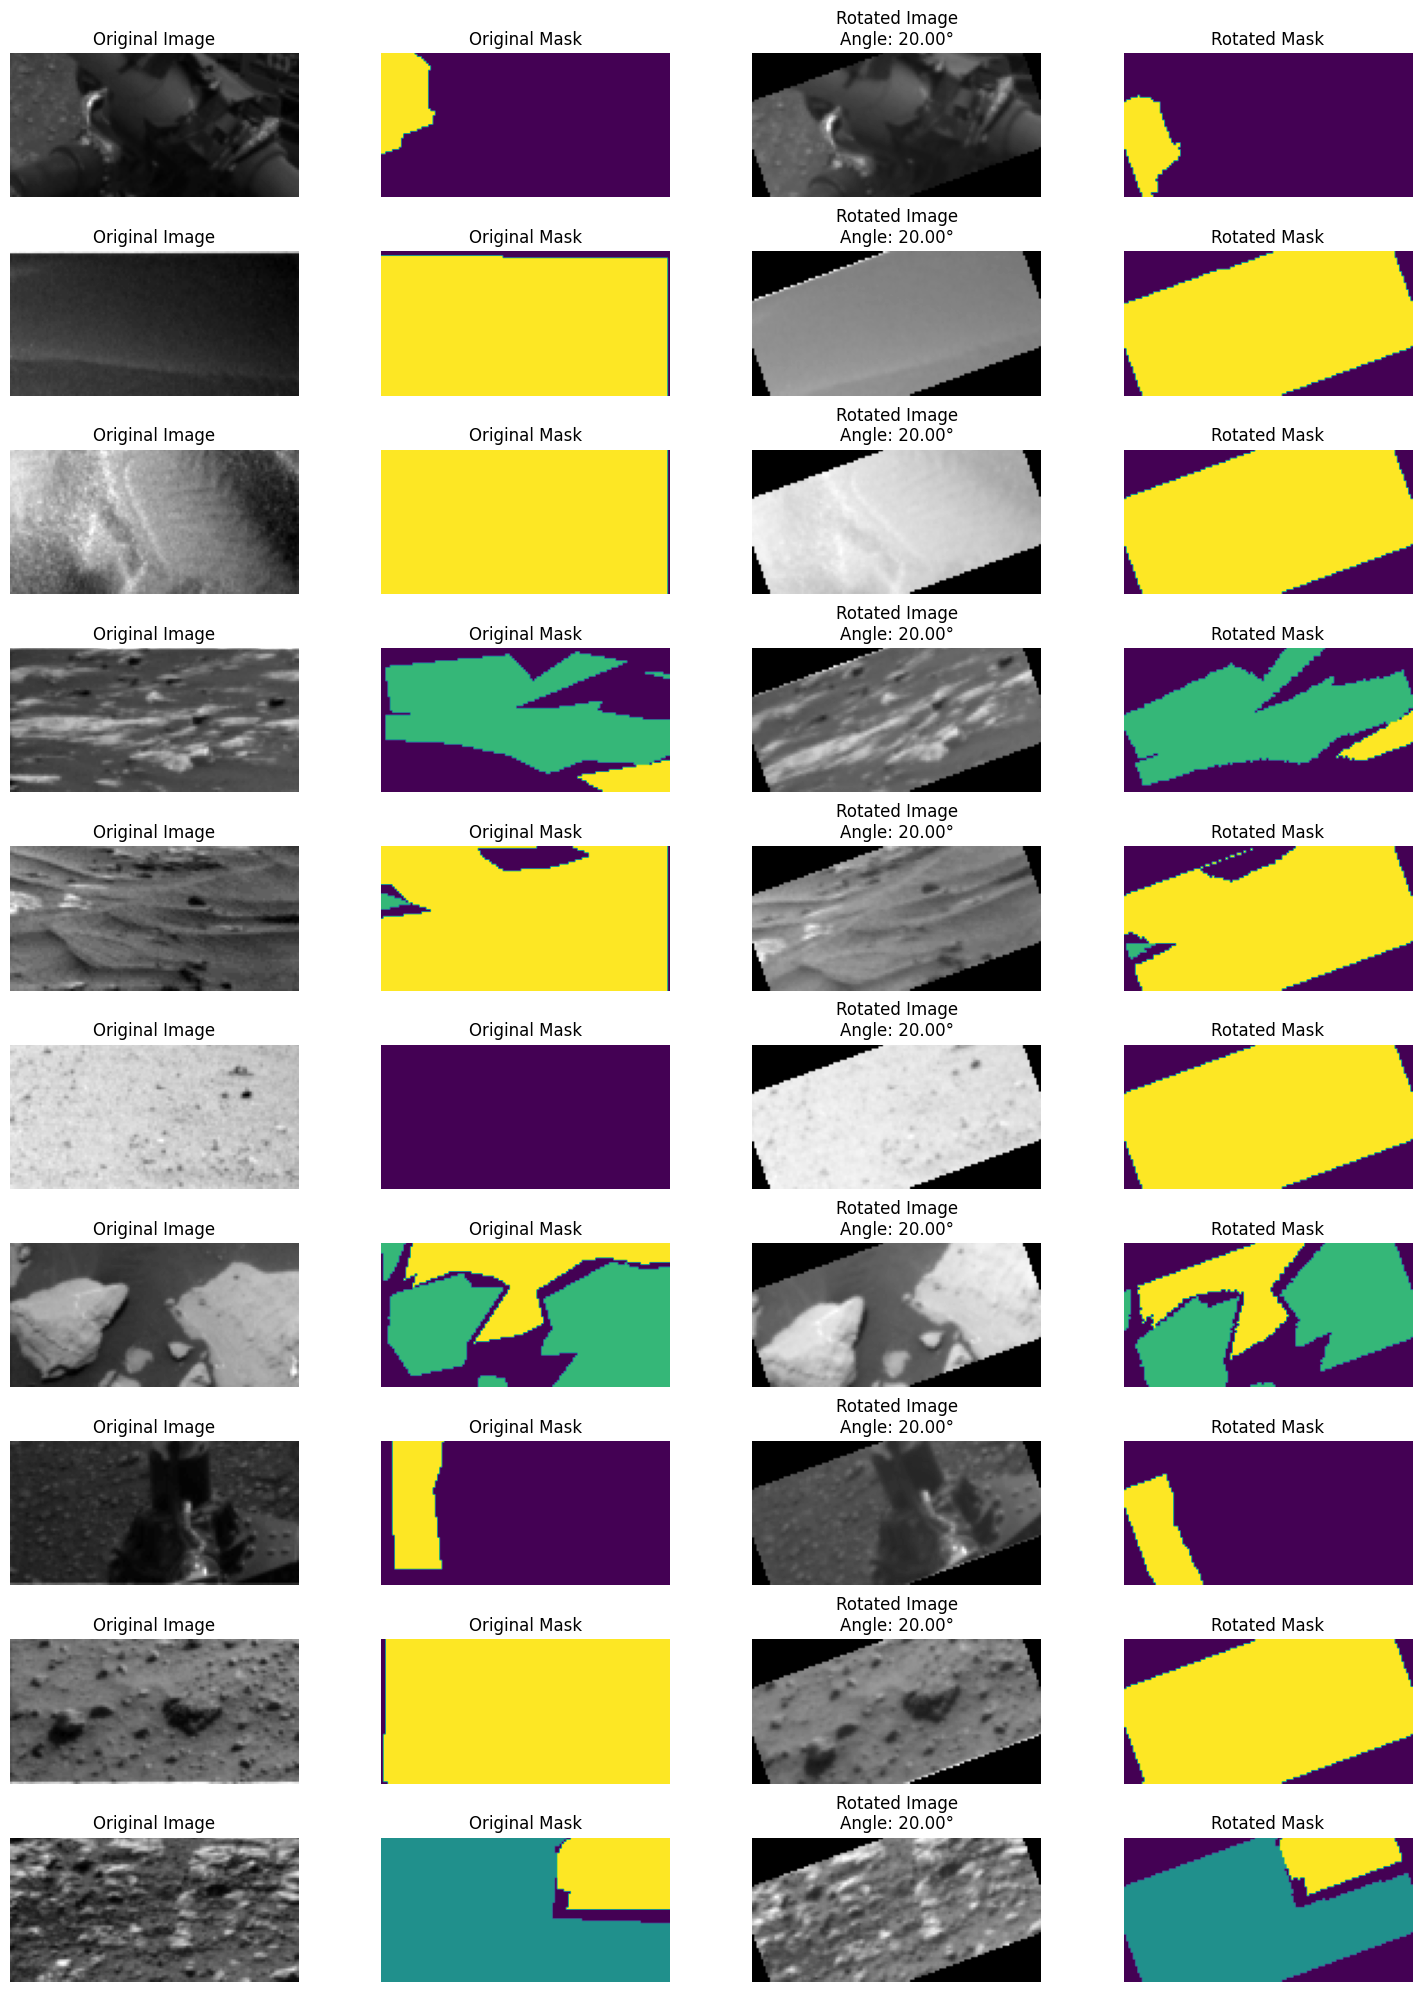

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define the rotation function using scipy
def rotate_image_and_mask(image, mask, angle):
    """
    Rotate a grayscale image and its corresponding mask by a given angle.
    """
    # Rotate the grayscale image (bilinear interpolation)
    rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

    # Rotate the mask (nearest-neighbor interpolation)
    rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

    return rotated_image, rotated_mask

# Randomly select 10 images
random_indices = np.random.choice(len(X_train), size=10, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply random rotation and visualize
plt.figure(figsize=(15, 20))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Generate a random angle for rotation
    angle = np.random.uniform(20, 20)  # Random angle between -30° and 30°

    # Rotate the image and mask
    rotated_image, rotated_mask = rotate_image_and_mask(image, mask, angle)

    # Plot original and rotated images/masks
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Rotated Image\nAngle: {angle:.2f}°")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(rotated_mask, cmap="viridis")
    plt.title("Rotated Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


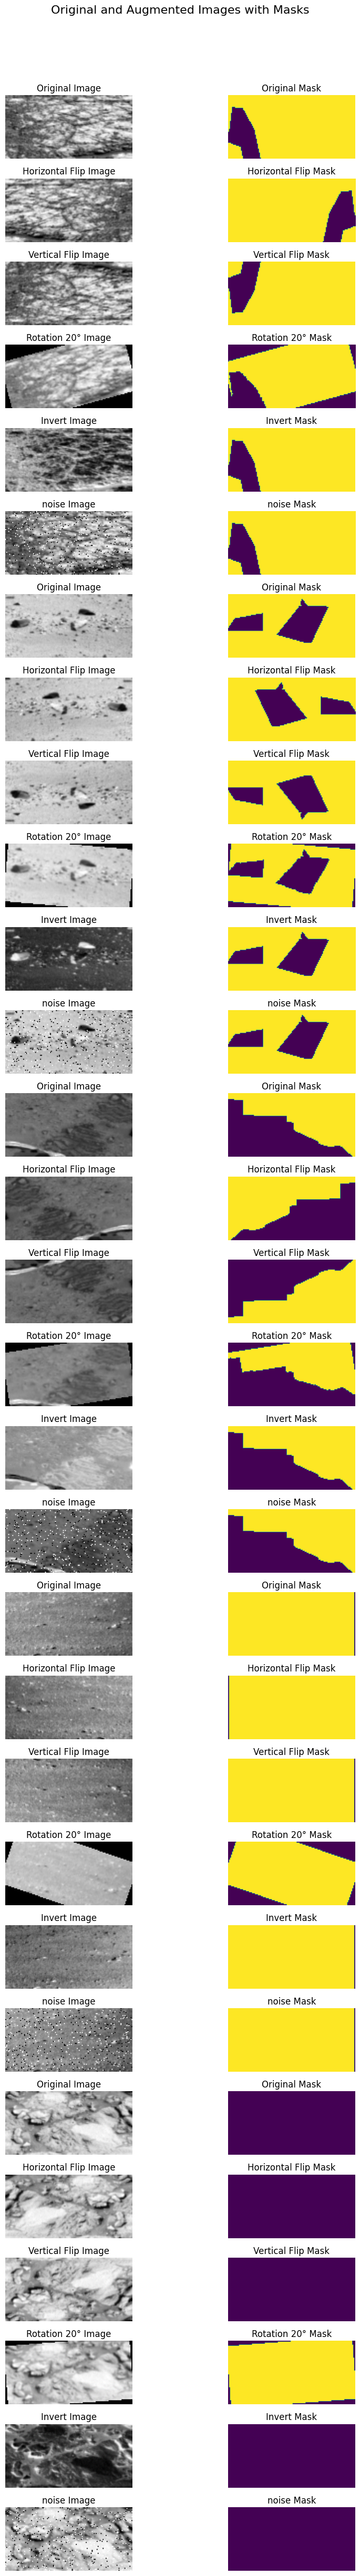

In [6]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    elif augment_type == "Rotation 20°":
        angle = np.random.uniform(-20, 20)
        # Rotate the grayscale image (bilinear interpolation)
        rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

        # Rotate the mask (nearest-neighbor interpolation)
        rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

        return rotated_image, rotated_mask
    elif augment_type=="Invert":
        inverted_image, inverted_mask = invert_image(image, mask)
        return inverted_image,inverted_mask
    elif augment_type=="noise":
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        return noisy_image,noisy_mask
        
    """elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    "Rotation 20°": "Rotation 20°",
    "Invert":"Invert",
    "noise":"noise"
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [7]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_train, y_train):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


File: vertical_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


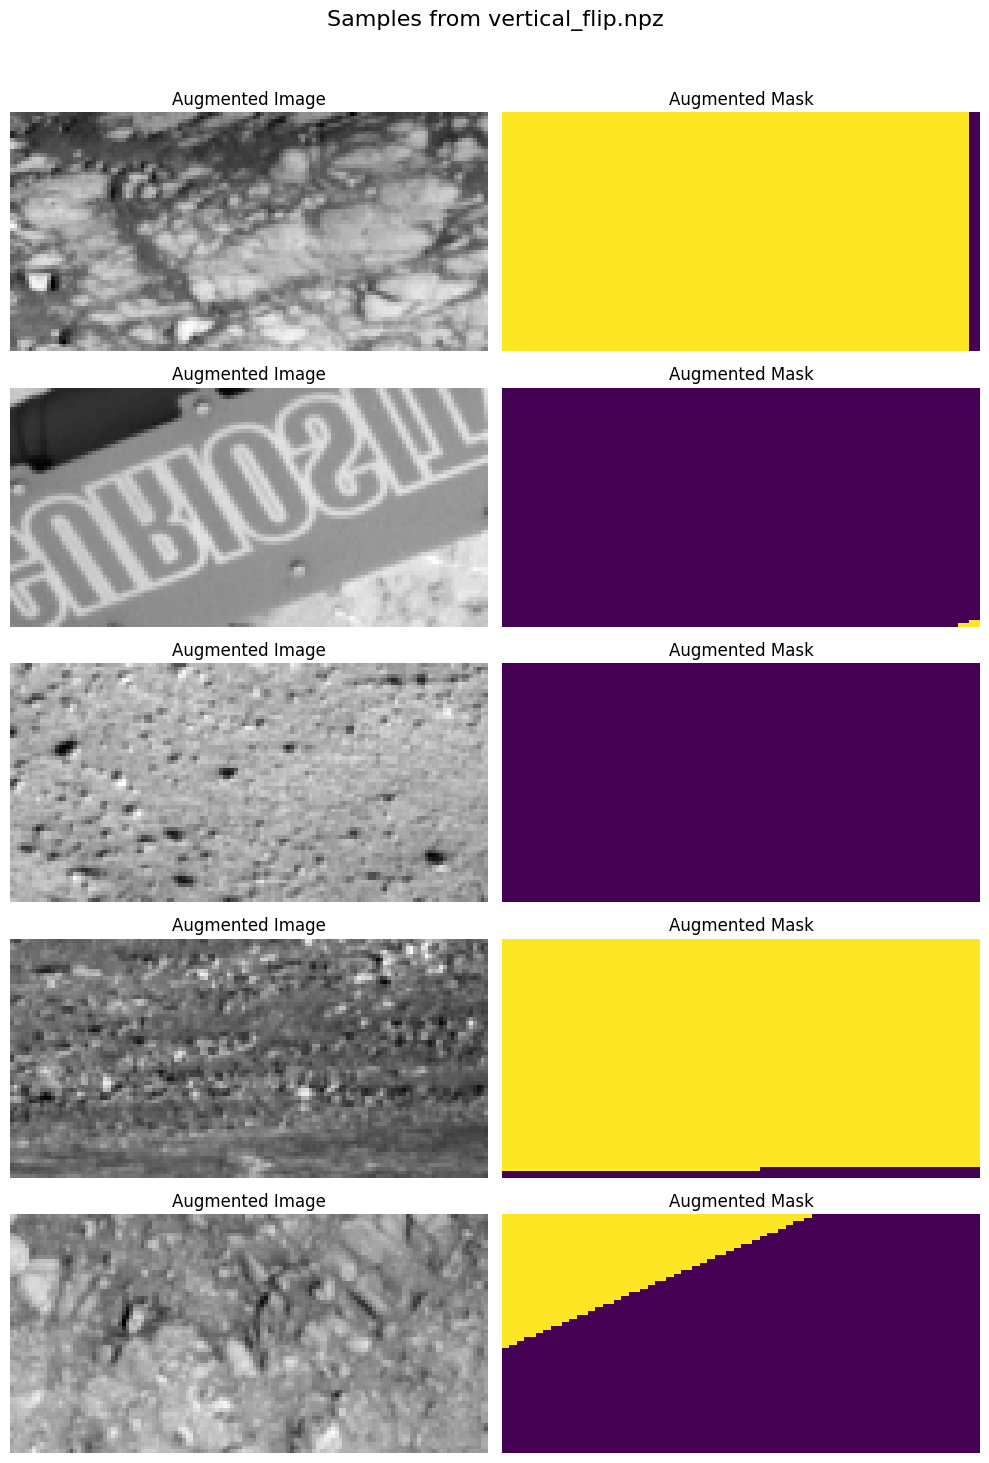

File: invert.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


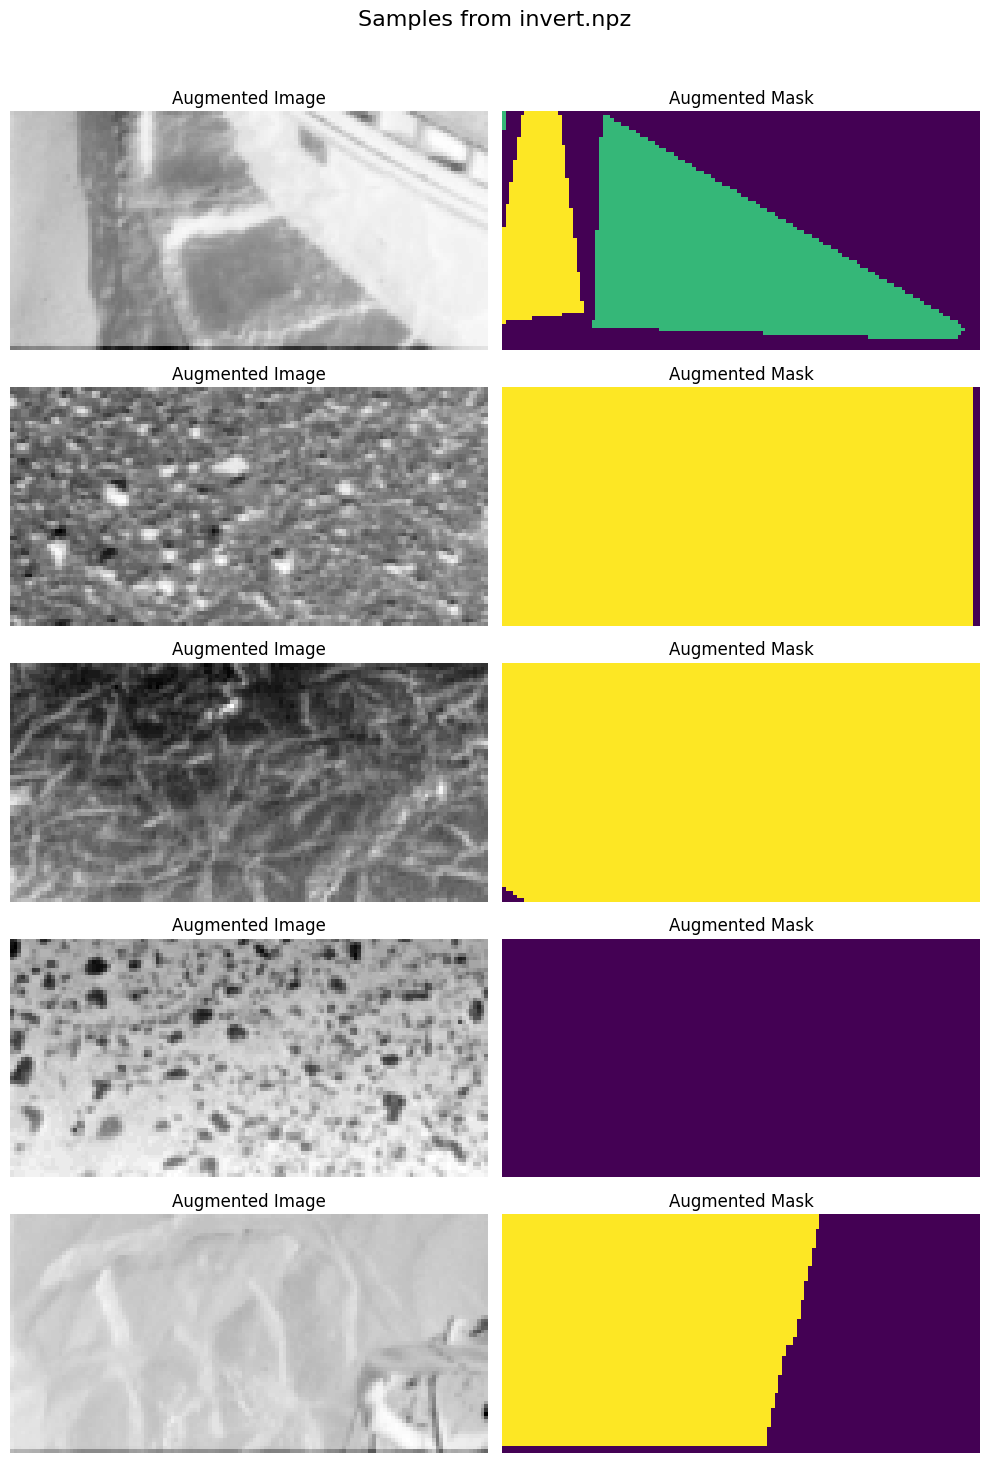

File: noise.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


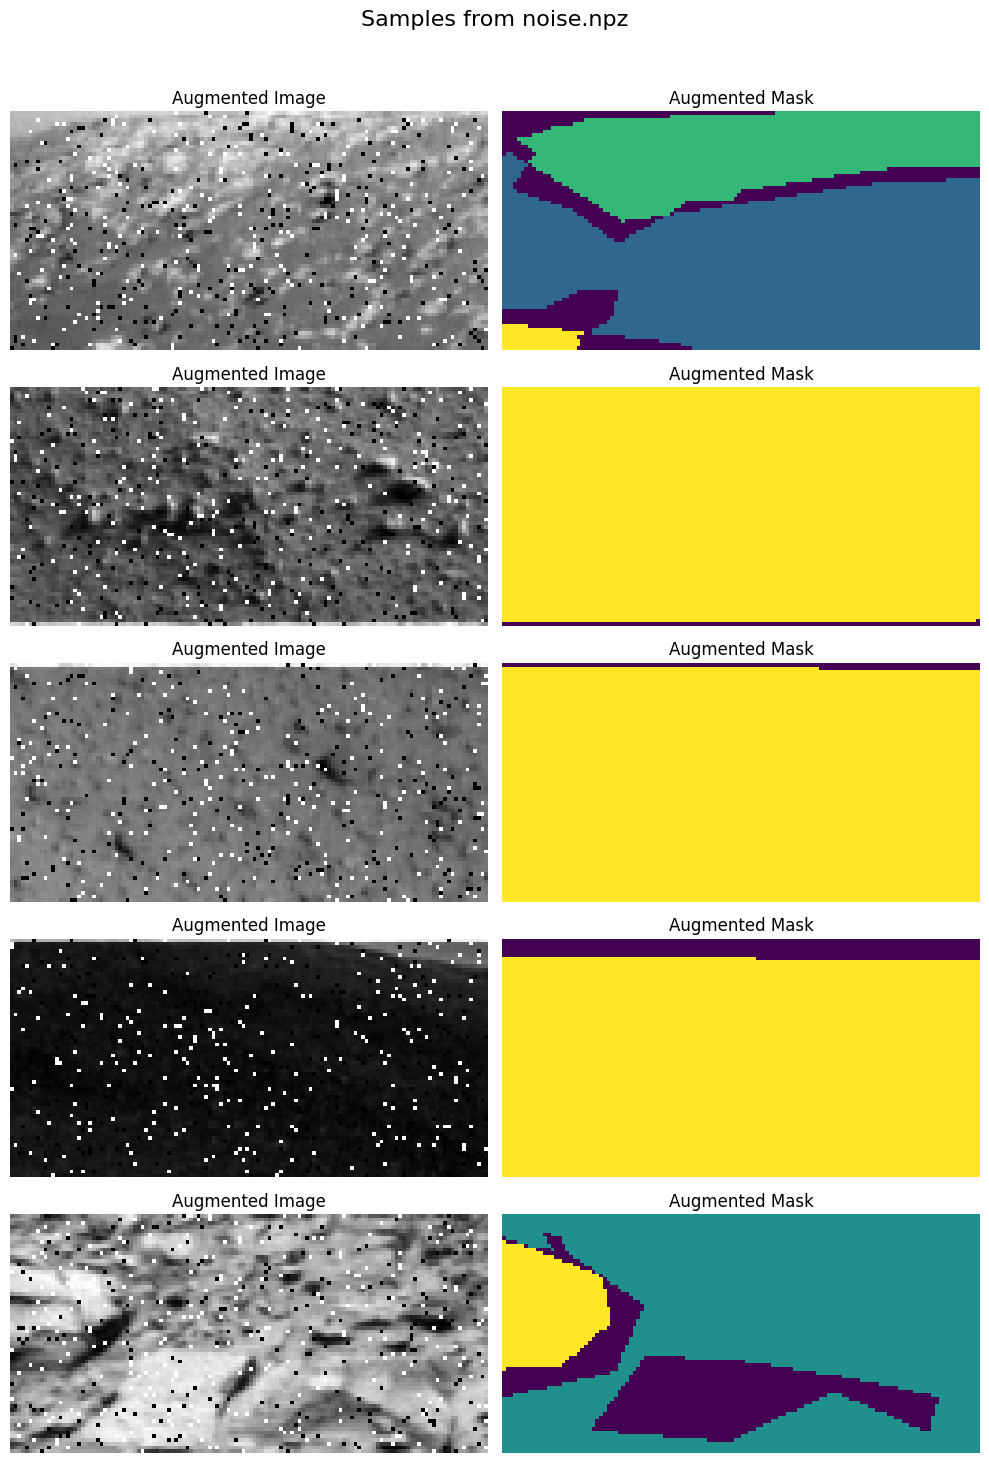

File: horizontal_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


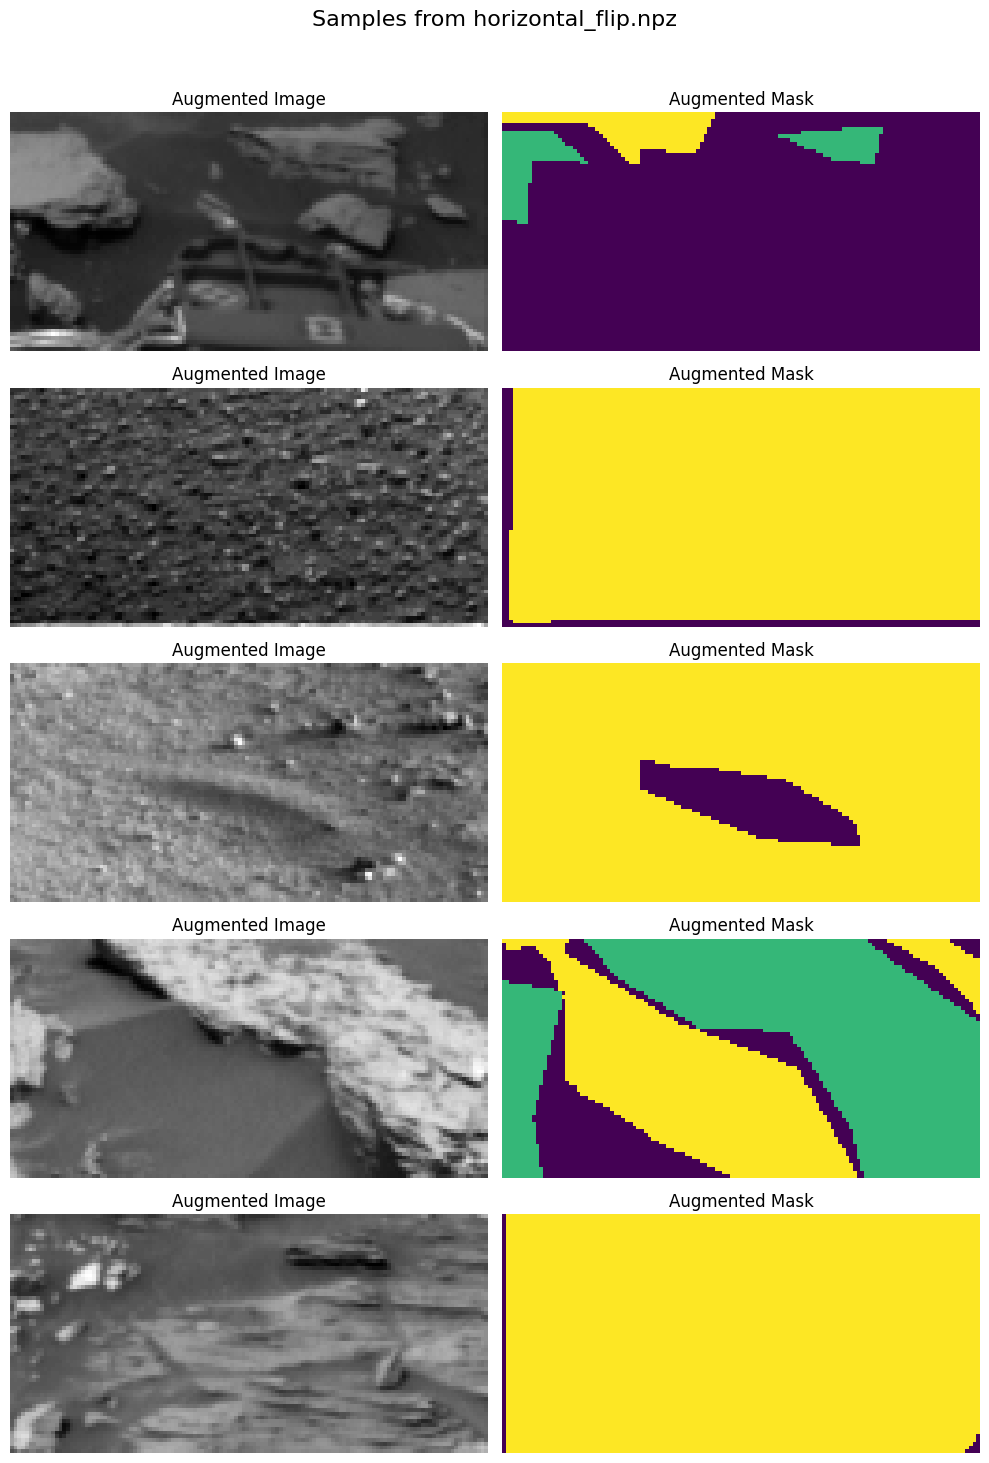

File: rotation_20°.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


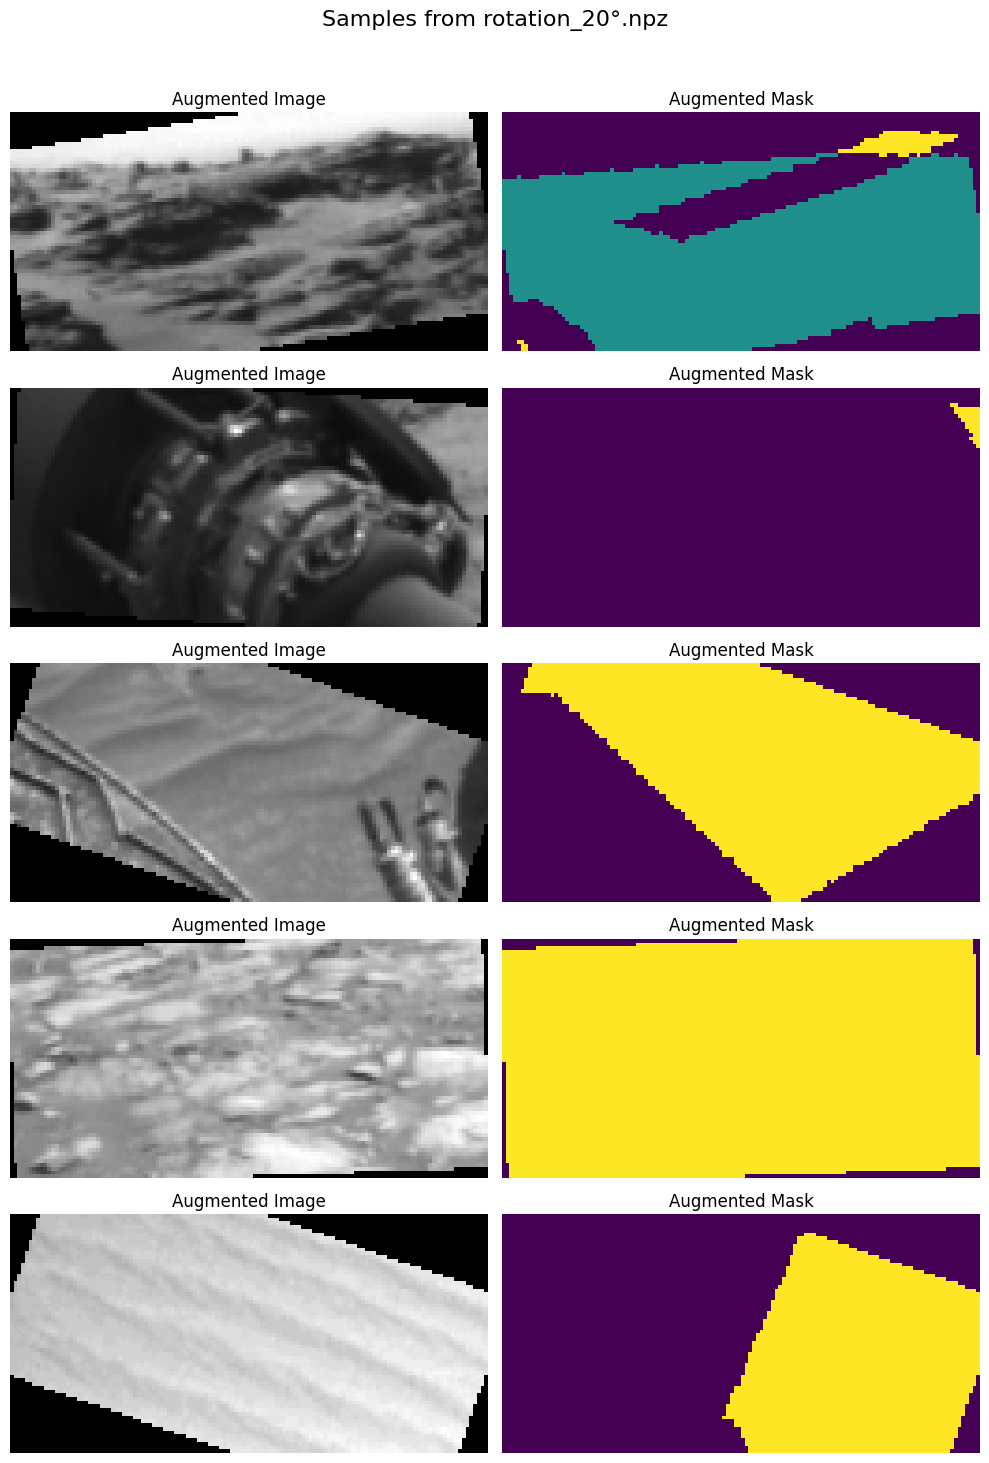

In [8]:
# Read the saved files and display details
output_dir="/kaggle/working/augmented_data"
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
        file_path = os.path.join(output_dir, file_name)
        data = np.load(file_path)

        # Display keys and their shapes
        print(f"File: {file_name}")
        for key in data.keys():
            print(f"  Key: {key}, Shape: {data[key].shape}")

        # Plot 5 random images and masks
        fig, axes = plt.subplots(5, 2, figsize=(10, 15))
        fig.suptitle(f"Samples from {file_name}", fontsize=16)
        for i in range(5):
            random_idx = np.random.randint(data["augmented_images"].shape[0])
            axes[i, 0].imshow(data["augmented_images"][random_idx], cmap="gray")
            axes[i, 0].set_title("Augmented Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(data["augmented_masks"][random_idx])
            axes[i, 1].set_title("Augmented Mask")
            axes[i, 1].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## 🛠️ Train and Save the Model

In [9]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/horizontal_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (4008, 64, 128)
New y_train shape: (4008, 64, 128)


In [10]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/vertical_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (6012, 64, 128)
New y_train shape: (6012, 64, 128)


In [11]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/rotation_20°.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (8016, 64, 128)
New y_train shape: (8016, 64, 128)


In [12]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/invert.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (10020, 64, 128)
New y_train shape: (10020, 64, 128)


In [13]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/noise.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (12024, 64, 128)
New y_train shape: (12024, 64, 128)


In [14]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [15]:
X_val = X_val[..., np.newaxis] / 255.0

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (12024, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (12024, 64, 128)


In [24]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis",vmin=0,vmax=4)
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis",vmin=0,vmax=4)
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [18]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (12024, 64, 128, 1)
Shape of y_train after reshaping: (12024, 64, 128, 1)


In [19]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=30,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)




Shape of X_train after reshaping: (12024, 64, 128, 1)
Shape of y_train after reshaping: (12024, 64, 128)
Class pixel counts: [25080450 32652638 23178115 17464095   125310]
Calculated class weights: [0.00489157 0.00375721 0.00529304 0.00702485 0.97903334]


In [21]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [22]:
from tensorflow.keras.callbacks import Callback
class SaveBestMeanIoU(Callback):
    def __init__(self, filepath, monitor="val_mean_io_u", mode="max", verbose=1):
        super(SaveBestMeanIoU, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = -float("inf") if mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Debug: Print available keys in logs
        print(f"Available log keys: {logs.keys()}")
        
        # Use the correct log key
        current = logs.get(self.monitor)
        if current is None:
            if self.verbose > 0:
                print(f"Warning: Monitor '{self.monitor}' is not available in logs.")
            return

        if (self.mode == "max" and current > self.best) or (self.mode == "min" and current < self.best):
            self.best = current
            if self.verbose > 0:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current:.4f}, saving model.")
            self.model.save(self.filepath)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 128,   │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 128,   │     36,928 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 128,   │        128 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 64, 128,   │          0 │ conv2d_23[0][0],  │
│                     │ 64)               │            │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 64,    │          0 │ add_7[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 64,    │    147,584 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 64,    │      8,320 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 32, 64,    │          0 │ conv2d_26[0][0],  │
│                     │ 128)              │            │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 32,    │          0 │ add_8[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 16, 32,    │    590,080 │ conv2d_28[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 16, 32,    │     33,024 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 16, 32,    │          0 │ conv2d_29[0][0],  │
│                     │ 256)              │            │ conv2d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 16,     │          0 │ add_9[0][0]       │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_5[

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


W0000 00:00:1733873916.867268      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3530 - loss: 1.3926 - mean_io_u_1: 0.0855 - mean_iou: 0.0855

W0000 00:00:1733873993.691940      90 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.3531 - loss: 1.3924 - mean_io_u_1: 0.0855 - mean_iou: 0.0855

W0000 00:00:1733873999.418585      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733874002.733279      91 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 1: val_mean_iou improved to 0.1974, saving model.

Epoch 1: val_loss did not improve from 0.82940
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


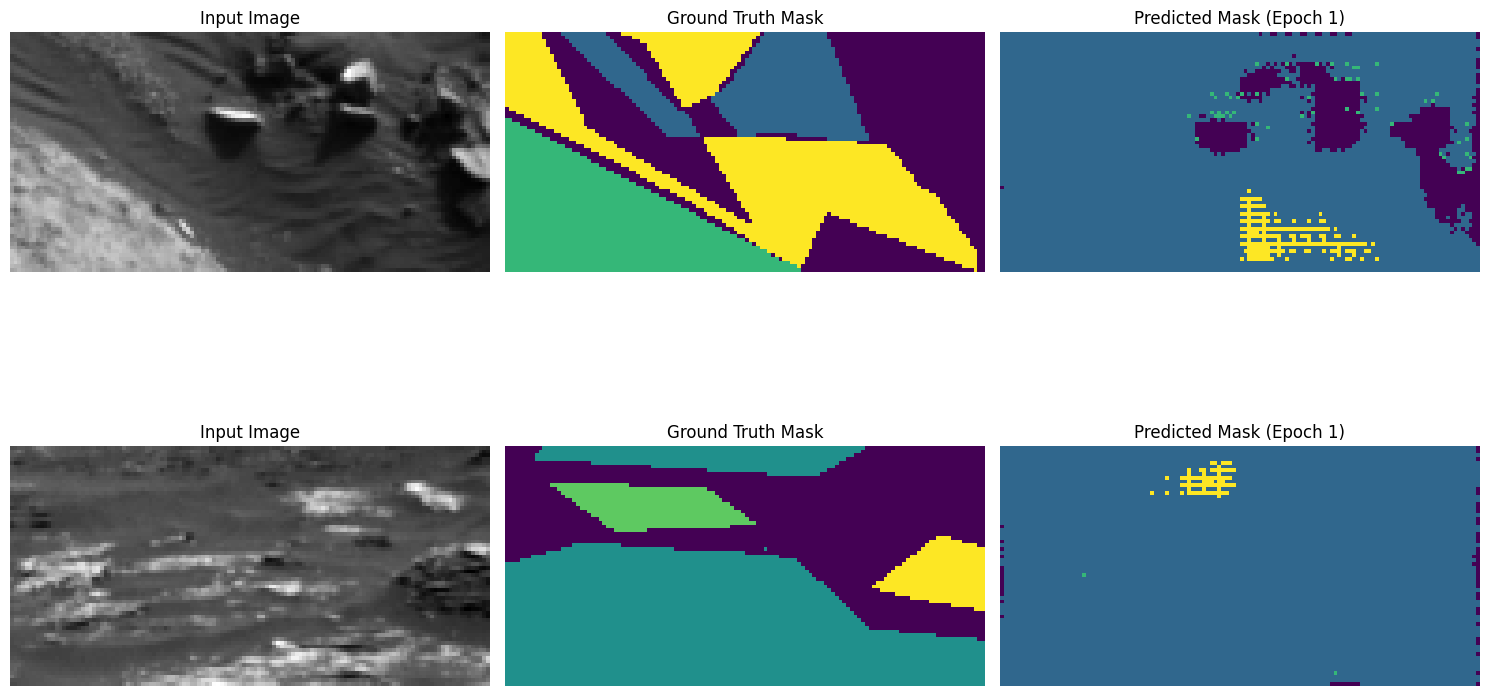

376/376 ━━━━━━━━━━━━━━━━━━━━ 97s 227ms/step - accuracy: 0.3531 - loss: 1.3923 - mean_io_u_1: 0.0855 - mean_iou: 0.0855 - val_accuracy: 0.4407 - val_loss: 1.2093 - val_mean_io_u_1: 0.1974 - val_mean_iou: 0.1974 - learning_rate: 1.0000e-04
Epoch 2/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4471 - loss: 1.1996 - mean_io_u_1: 0.1980 - mean_iou: 0.1980Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 2: val_mean_iou improved to 0.2821, saving model.

Epoch 2: val_loss did not improve from 0.82940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


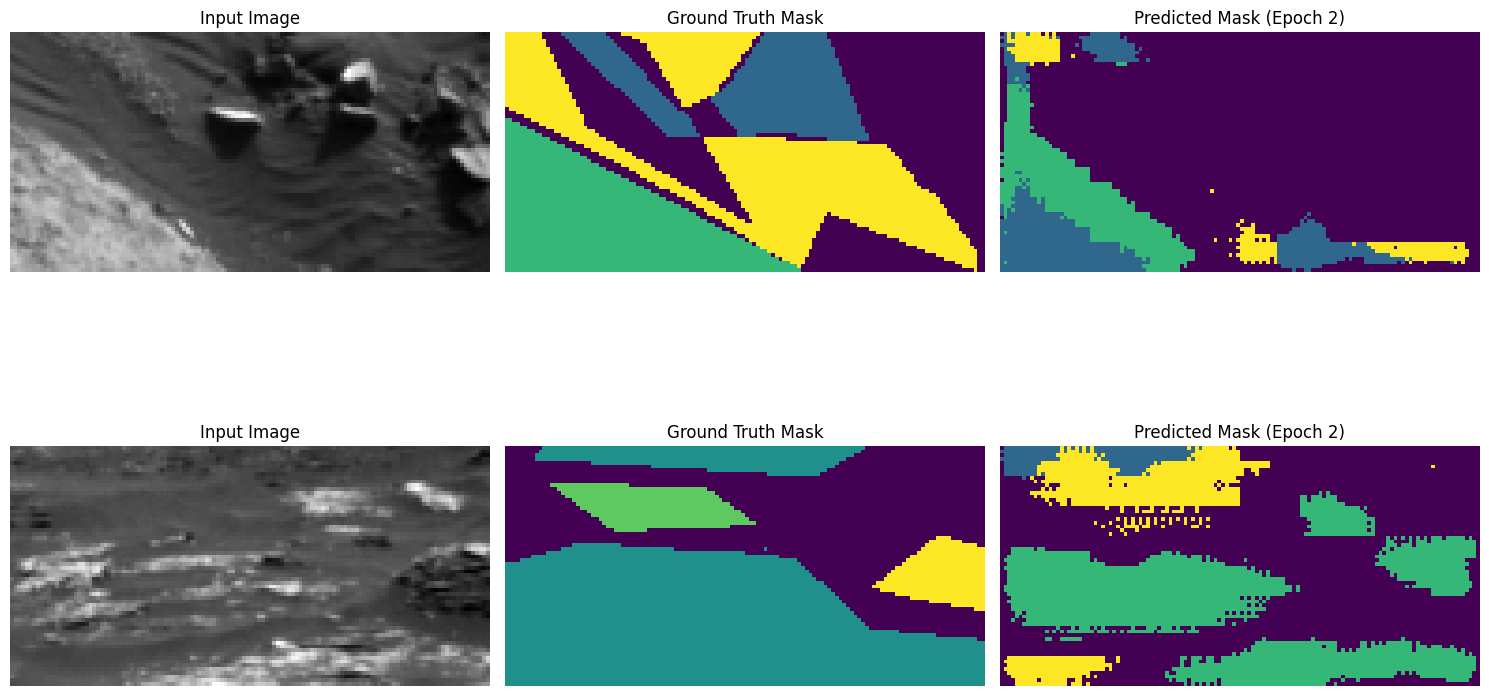

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.4472 - loss: 1.1995 - mean_io_u_1: 0.1980 - mean_iou: 0.1980 - val_accuracy: 0.5684 - val_loss: 1.0355 - val_mean_io_u_1: 0.2821 - val_mean_iou: 0.2821 - learning_rate: 1.0000e-04
Epoch 3/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5444 - loss: 1.0551 - mean_io_u_1: 0.2653 - mean_iou: 0.2653Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 3: val_mean_iou improved to 0.3397, saving model.

Epoch 3: val_loss did not improve from 0.82940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


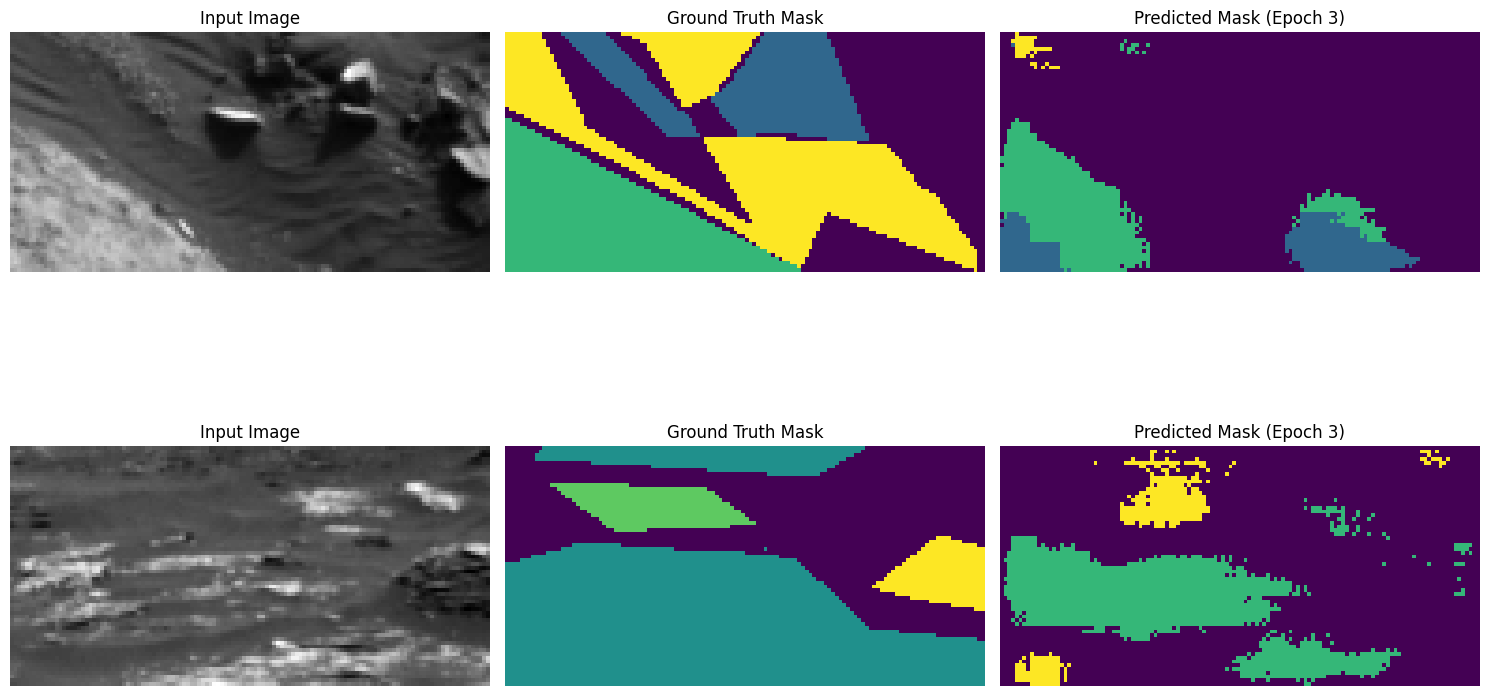

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.5445 - loss: 1.0550 - mean_io_u_1: 0.2653 - mean_iou: 0.2653 - val_accuracy: 0.6351 - val_loss: 0.9271 - val_mean_io_u_1: 0.3397 - val_mean_iou: 0.3397 - learning_rate: 1.0000e-04
Epoch 4/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5860 - loss: 0.9921 - mean_io_u_1: 0.2974 - mean_iou: 0.2974Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 4: val_mean_iou improved to 0.3567, saving model.

Epoch 4: val_loss did not improve from 0.82940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


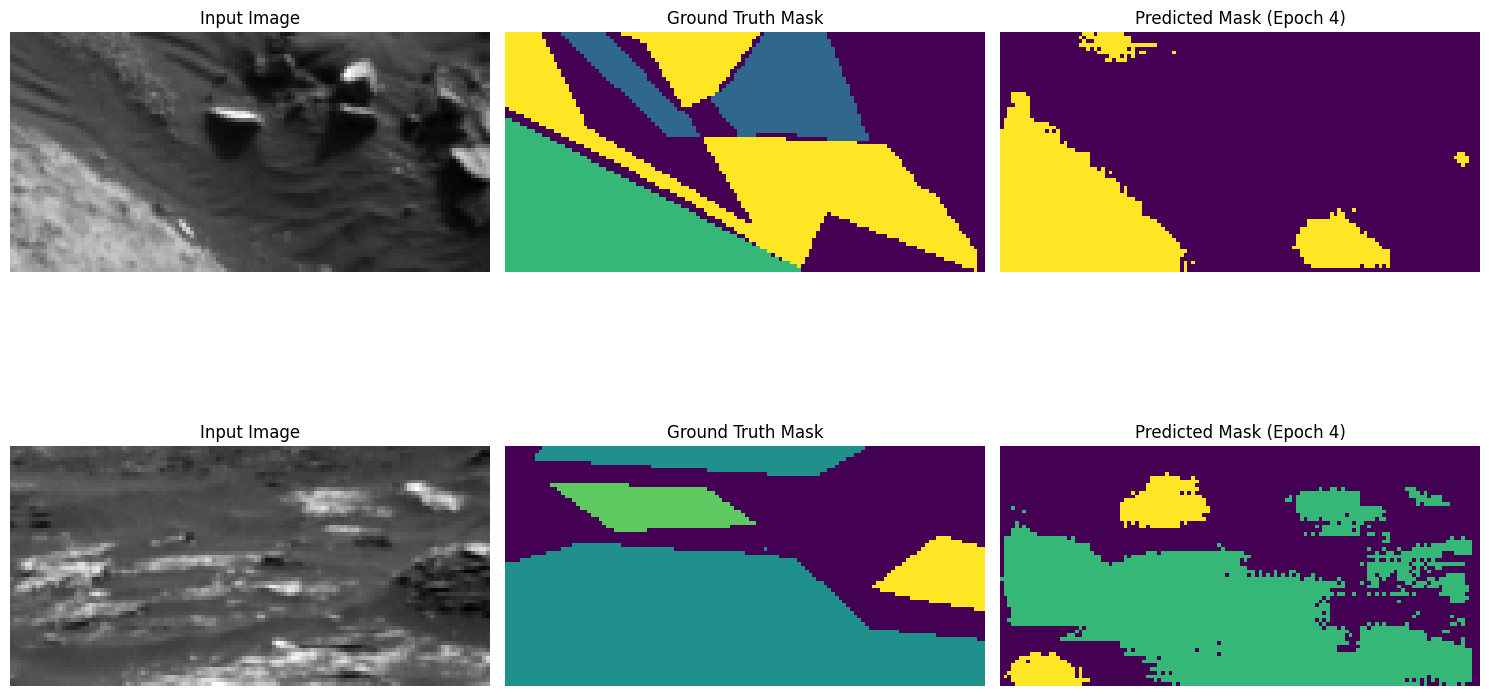

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.5860 - loss: 0.9920 - mean_io_u_1: 0.2974 - mean_iou: 0.2974 - val_accuracy: 0.6488 - val_loss: 0.8911 - val_mean_io_u_1: 0.3567 - val_mean_iou: 0.3567 - learning_rate: 1.0000e-04
Epoch 5/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6222 - loss: 0.9284 - mean_io_u_1: 0.3274 - mean_iou: 0.3274Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 5: val_mean_iou improved to 0.3627, saving model.

Epoch 5: val_loss did not improve from 0.82940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


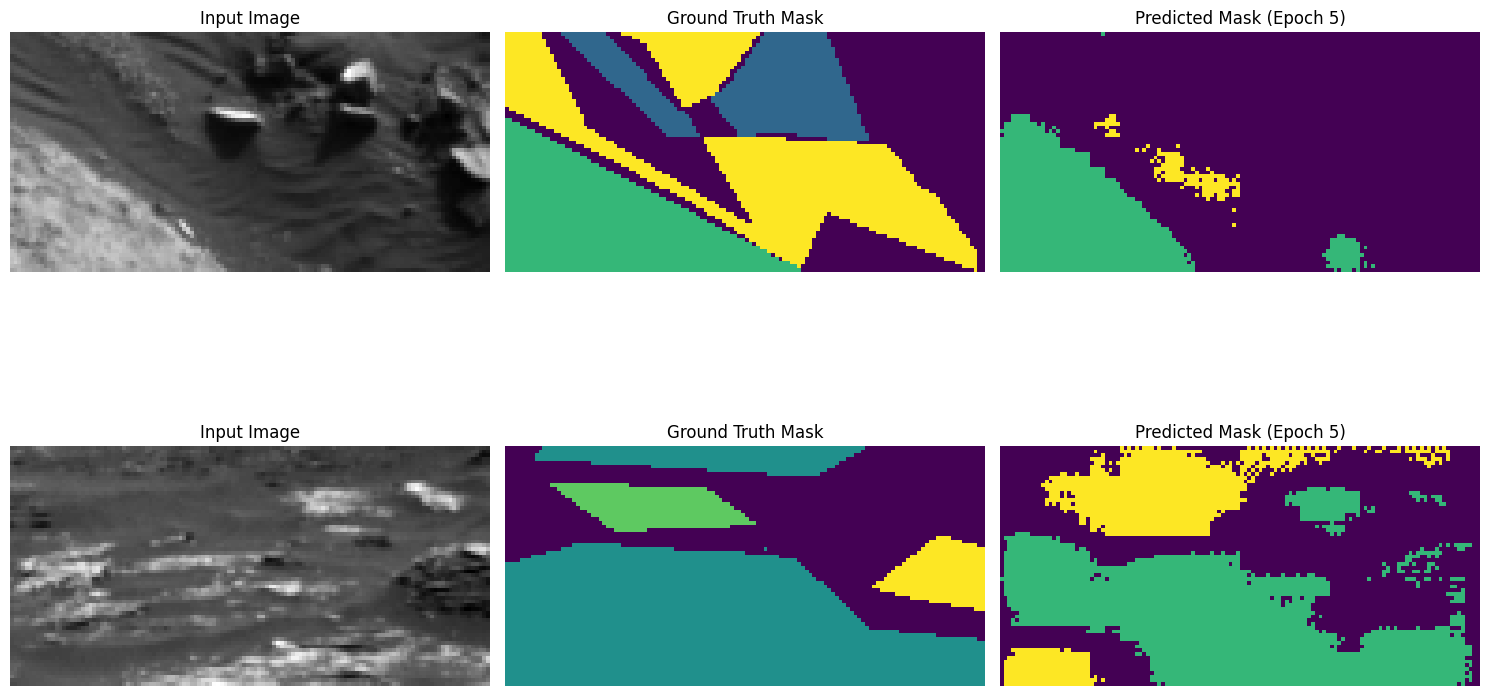

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.6222 - loss: 0.9284 - mean_io_u_1: 0.3274 - mean_iou: 0.3274 - val_accuracy: 0.6575 - val_loss: 0.8771 - val_mean_io_u_1: 0.3627 - val_mean_iou: 0.3627 - learning_rate: 1.0000e-04
Epoch 6/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6463 - loss: 0.8828 - mean_io_u_1: 0.3453 - mean_iou: 0.3453Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 6: val_mean_iou improved to 0.3868, saving model.

Epoch 6: val_loss improved from 0.82940 to 0.81641, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


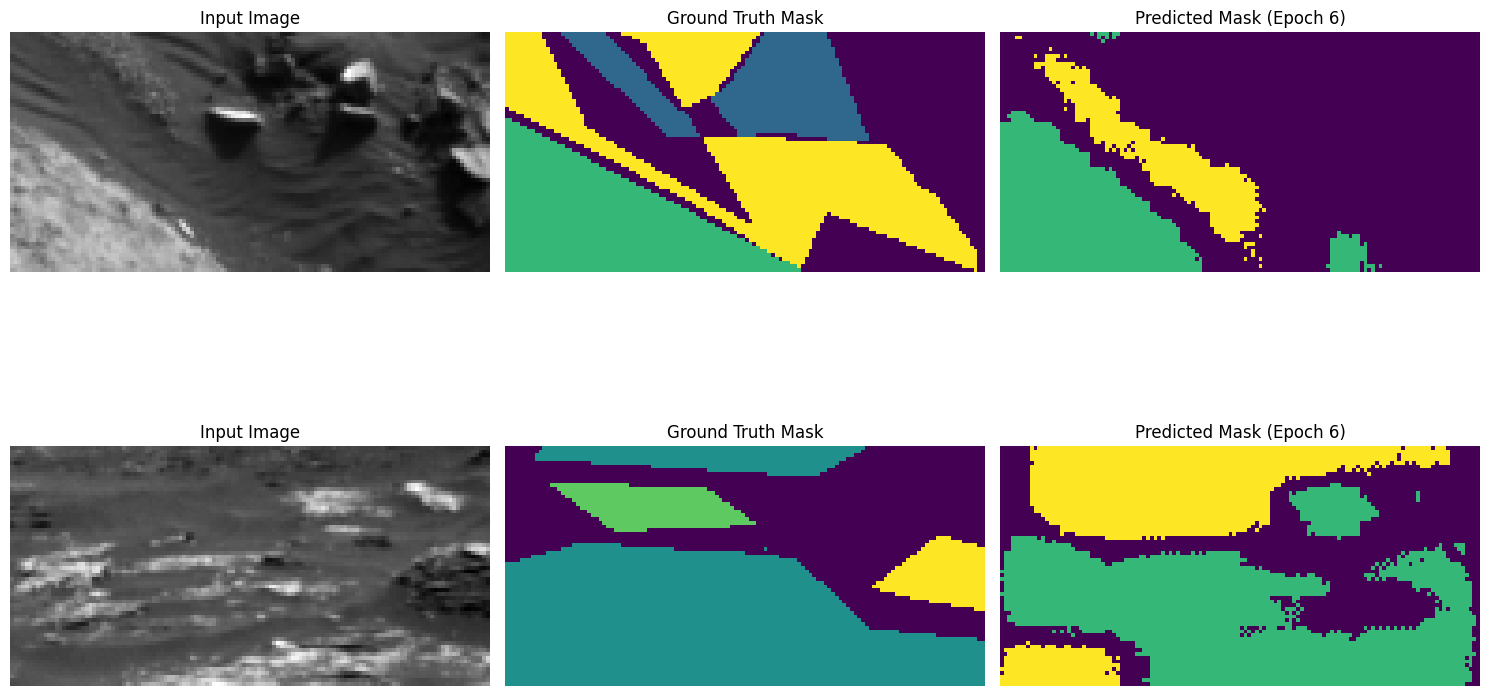

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.6463 - loss: 0.8827 - mean_io_u_1: 0.3453 - mean_iou: 0.3453 - val_accuracy: 0.6829 - val_loss: 0.8164 - val_mean_io_u_1: 0.3868 - val_mean_iou: 0.3868 - learning_rate: 1.0000e-04
Epoch 7/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6699 - loss: 0.8347 - mean_io_u_1: 0.3647 - mean_iou: 0.3647Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 7: val_mean_iou improved to 0.4129, saving model.

Epoch 7: val_loss improved from 0.81641 to 0.75244, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


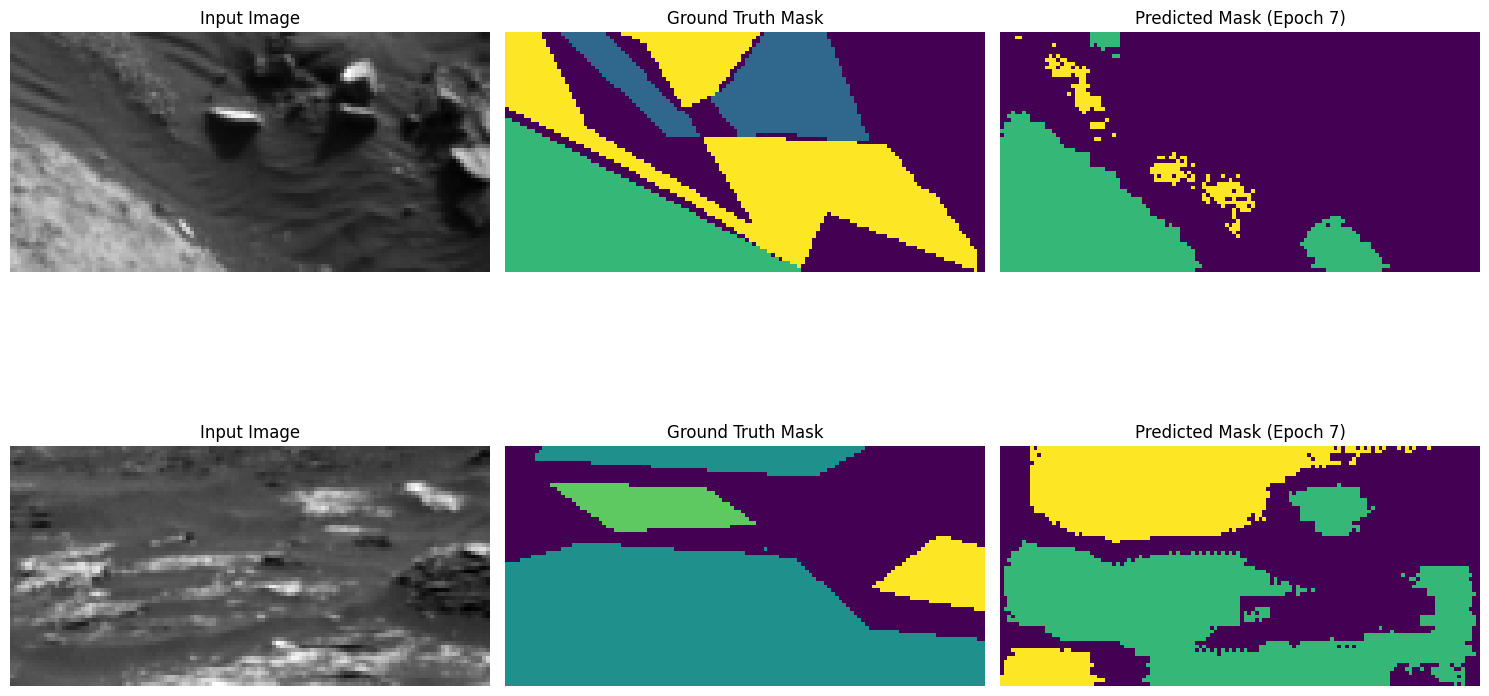

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.6699 - loss: 0.8346 - mean_io_u_1: 0.3647 - mean_iou: 0.3647 - val_accuracy: 0.7149 - val_loss: 0.7524 - val_mean_io_u_1: 0.4129 - val_mean_iou: 0.4129 - learning_rate: 1.0000e-04
Epoch 8/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6842 - loss: 0.8011 - mean_io_u_1: 0.3758 - mean_iou: 0.3758Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 8: val_mean_iou improved to 0.4200, saving model.

Epoch 8: val_loss improved from 0.75244 to 0.72404, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


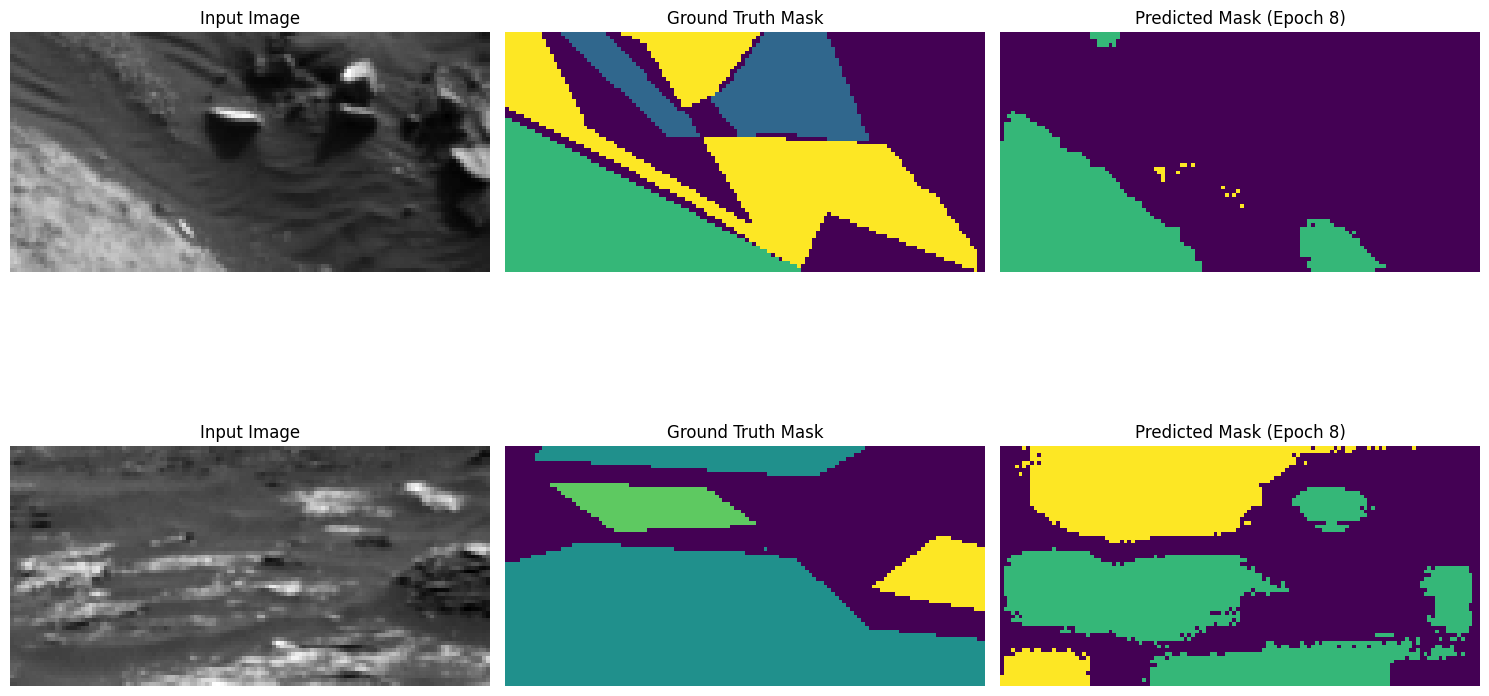

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.6842 - loss: 0.8010 - mean_io_u_1: 0.3758 - mean_iou: 0.3758 - val_accuracy: 0.7262 - val_loss: 0.7240 - val_mean_io_u_1: 0.4200 - val_mean_iou: 0.4200 - learning_rate: 1.0000e-04
Epoch 9/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7006 - loss: 0.7621 - mean_io_u_1: 0.3906 - mean_iou: 0.3906Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 9: val_mean_iou improved to 0.4226, saving model.

Epoch 9: val_loss improved from 0.72404 to 0.70427, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


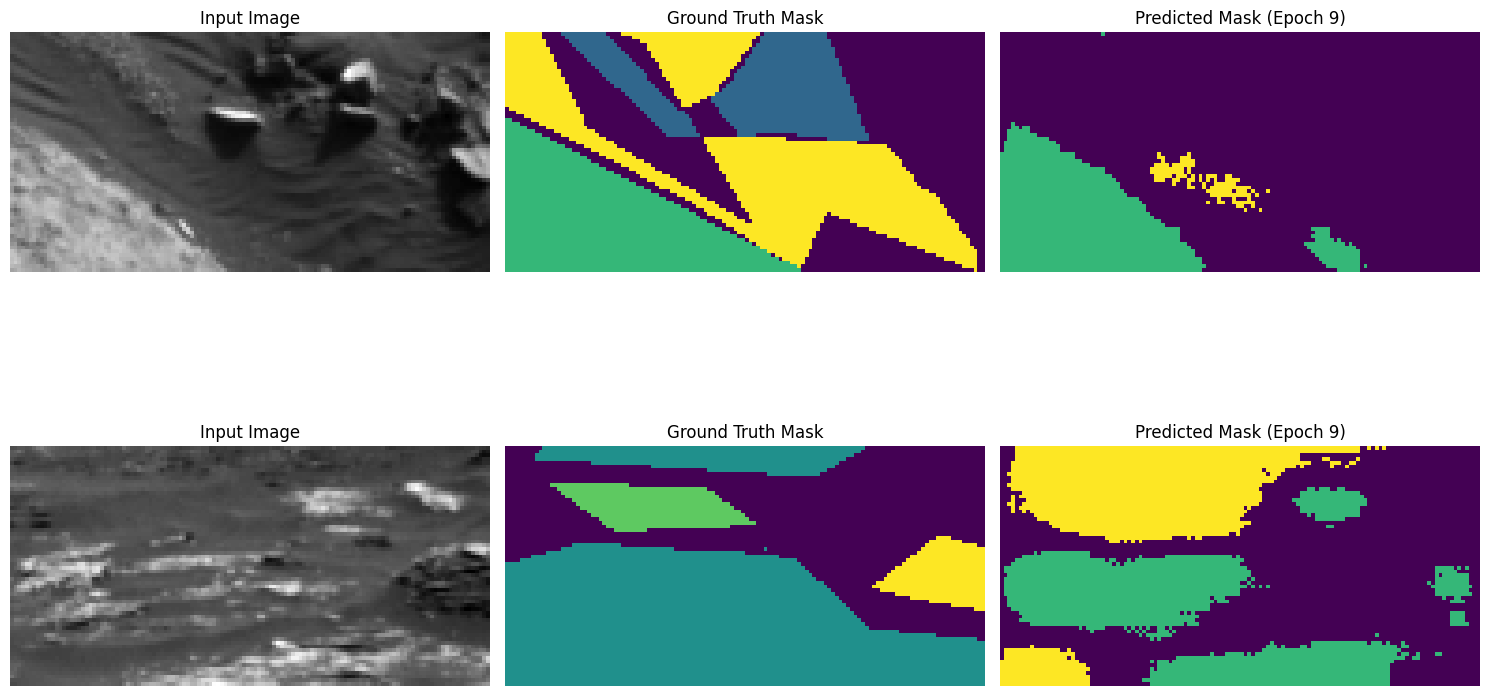

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.7006 - loss: 0.7620 - mean_io_u_1: 0.3905 - mean_iou: 0.3905 - val_accuracy: 0.7316 - val_loss: 0.7043 - val_mean_io_u_1: 0.4226 - val_mean_iou: 0.4226 - learning_rate: 1.0000e-04
Epoch 10/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7140 - loss: 0.7287 - mean_io_u_1: 0.4031 - mean_iou: 0.4031Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 10: val_mean_iou improved to 0.4305, saving model.

Epoch 10: val_loss improved from 0.70427 to 0.69786, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


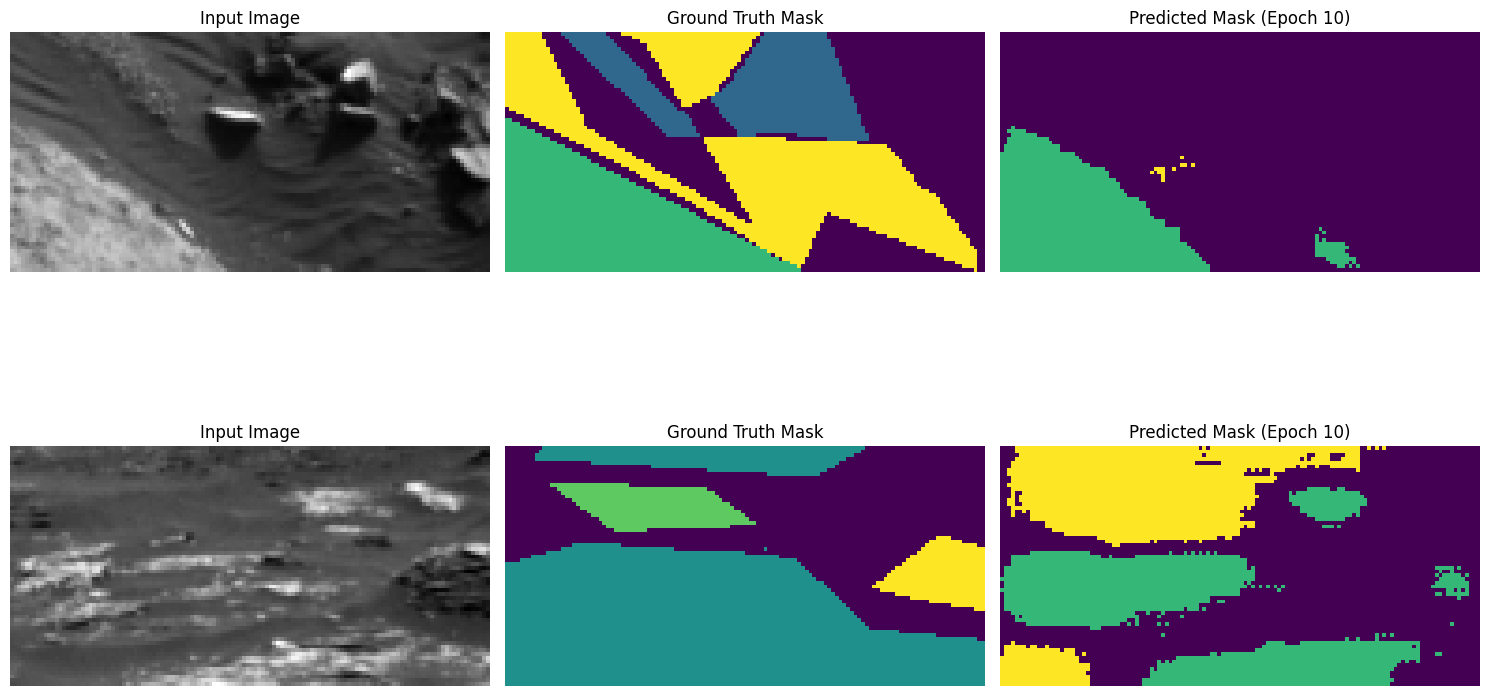

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7140 - loss: 0.7287 - mean_io_u_1: 0.4030 - mean_iou: 0.4030 - val_accuracy: 0.7379 - val_loss: 0.6979 - val_mean_io_u_1: 0.4305 - val_mean_iou: 0.4305 - learning_rate: 1.0000e-04
Epoch 11/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7236 - loss: 0.7046 - mean_io_u_1: 0.4117 - mean_iou: 0.4117Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 11: val_mean_iou improved to 0.4312, saving model.

Epoch 11: val_loss improved from 0.69786 to 0.68438, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


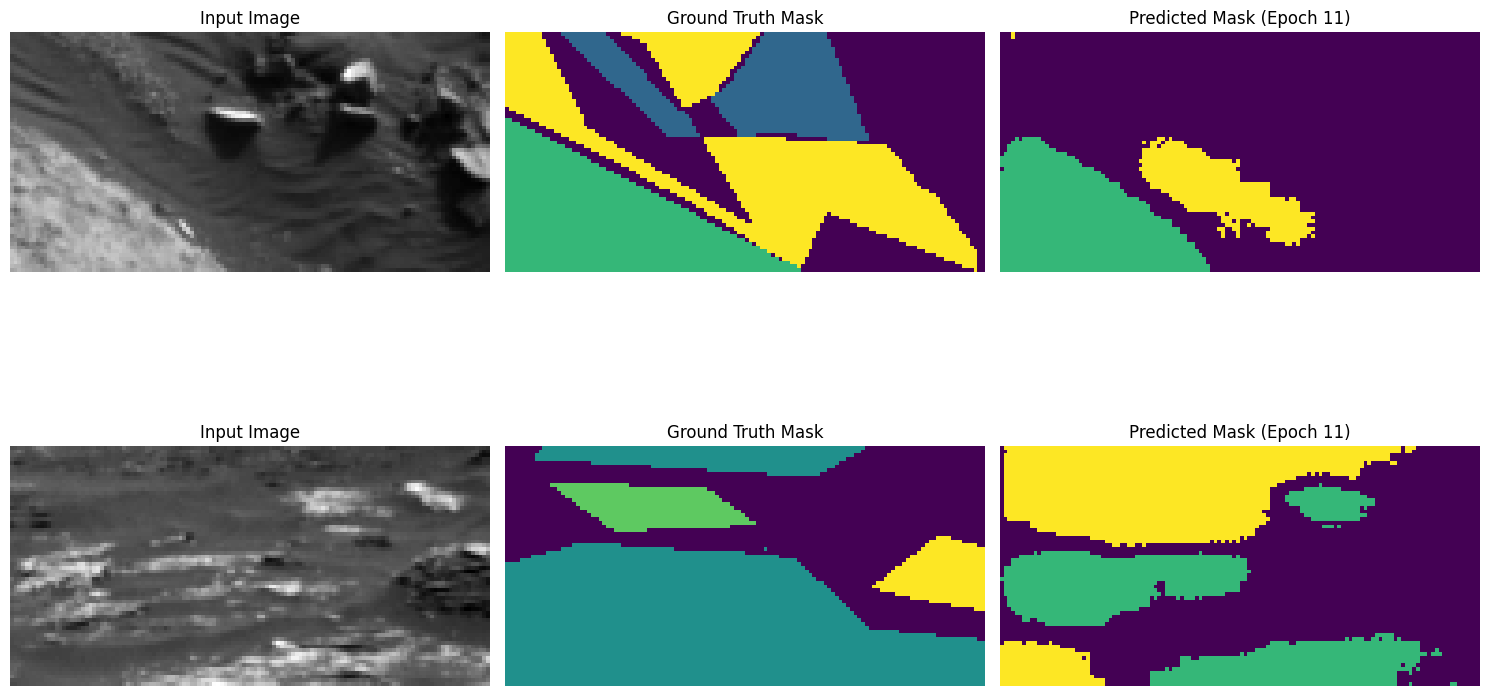

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.7236 - loss: 0.7046 - mean_io_u_1: 0.4117 - mean_iou: 0.4117 - val_accuracy: 0.7398 - val_loss: 0.6844 - val_mean_io_u_1: 0.4312 - val_mean_iou: 0.4312 - learning_rate: 1.0000e-04
Epoch 12/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7348 - loss: 0.6754 - mean_io_u_1: 0.4229 - mean_iou: 0.4229Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 12: val_loss improved from 0.68438 to 0.67403, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


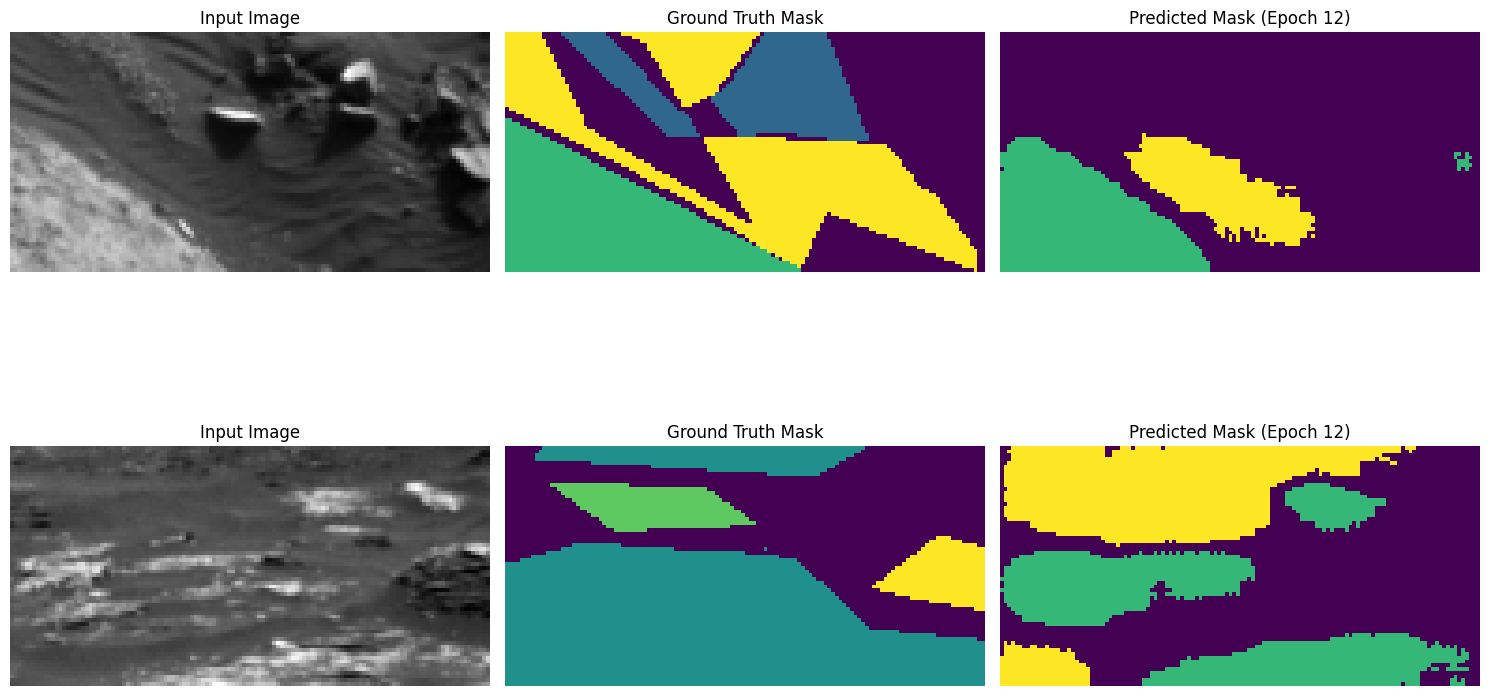

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.7349 - loss: 0.6754 - mean_io_u_1: 0.4229 - mean_iou: 0.4229 - val_accuracy: 0.7419 - val_loss: 0.6740 - val_mean_io_u_1: 0.4311 - val_mean_iou: 0.4311 - learning_rate: 1.0000e-04
Epoch 13/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7436 - loss: 0.6566 - mean_io_u_1: 0.4319 - mean_iou: 0.4319Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 13: val_mean_iou improved to 0.4367, saving model.

Epoch 13: val_loss improved from 0.67403 to 0.66136, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


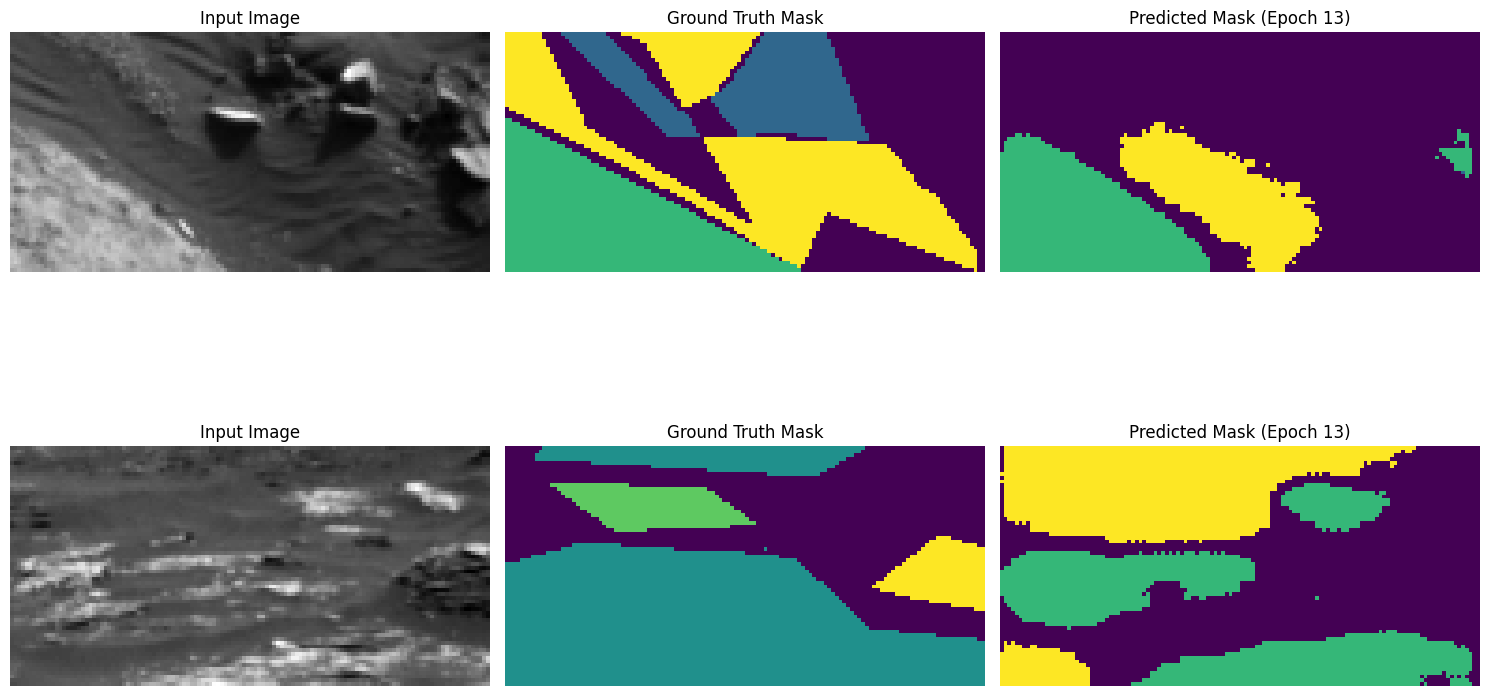

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.7436 - loss: 0.6565 - mean_io_u_1: 0.4319 - mean_iou: 0.4319 - val_accuracy: 0.7474 - val_loss: 0.6614 - val_mean_io_u_1: 0.4367 - val_mean_iou: 0.4367 - learning_rate: 1.0000e-04
Epoch 14/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7512 - loss: 0.6357 - mean_io_u_1: 0.4405 - mean_iou: 0.4405Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 14: val_mean_iou improved to 0.4397, saving model.

Epoch 14: val_loss improved from 0.66136 to 0.65317, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


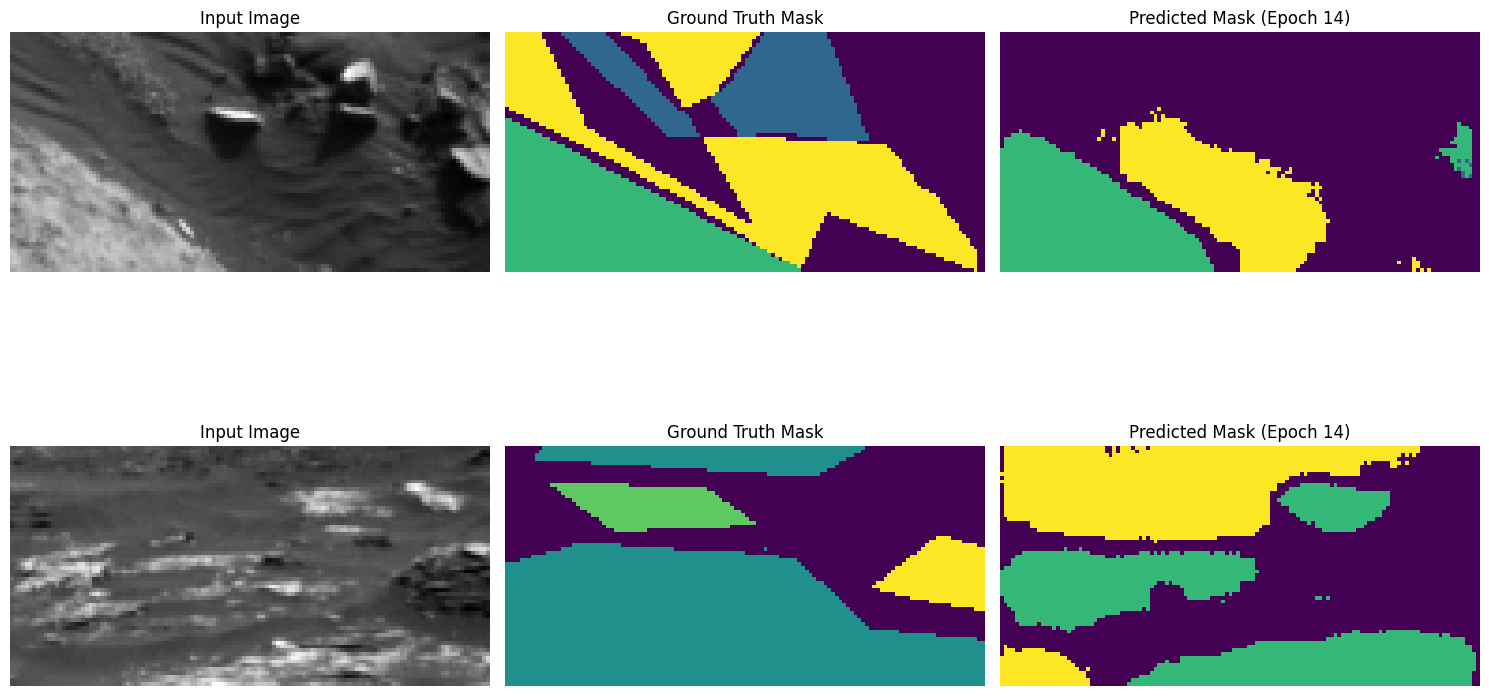

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.7512 - loss: 0.6356 - mean_io_u_1: 0.4405 - mean_iou: 0.4405 - val_accuracy: 0.7510 - val_loss: 0.6532 - val_mean_io_u_1: 0.4397 - val_mean_iou: 0.4397 - learning_rate: 1.0000e-04
Epoch 15/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7592 - loss: 0.6169 - mean_io_u_1: 0.4497 - mean_iou: 0.4497Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 15: val_mean_iou improved to 0.4428, saving model.

Epoch 15: val_loss improved from 0.65317 to 0.65186, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


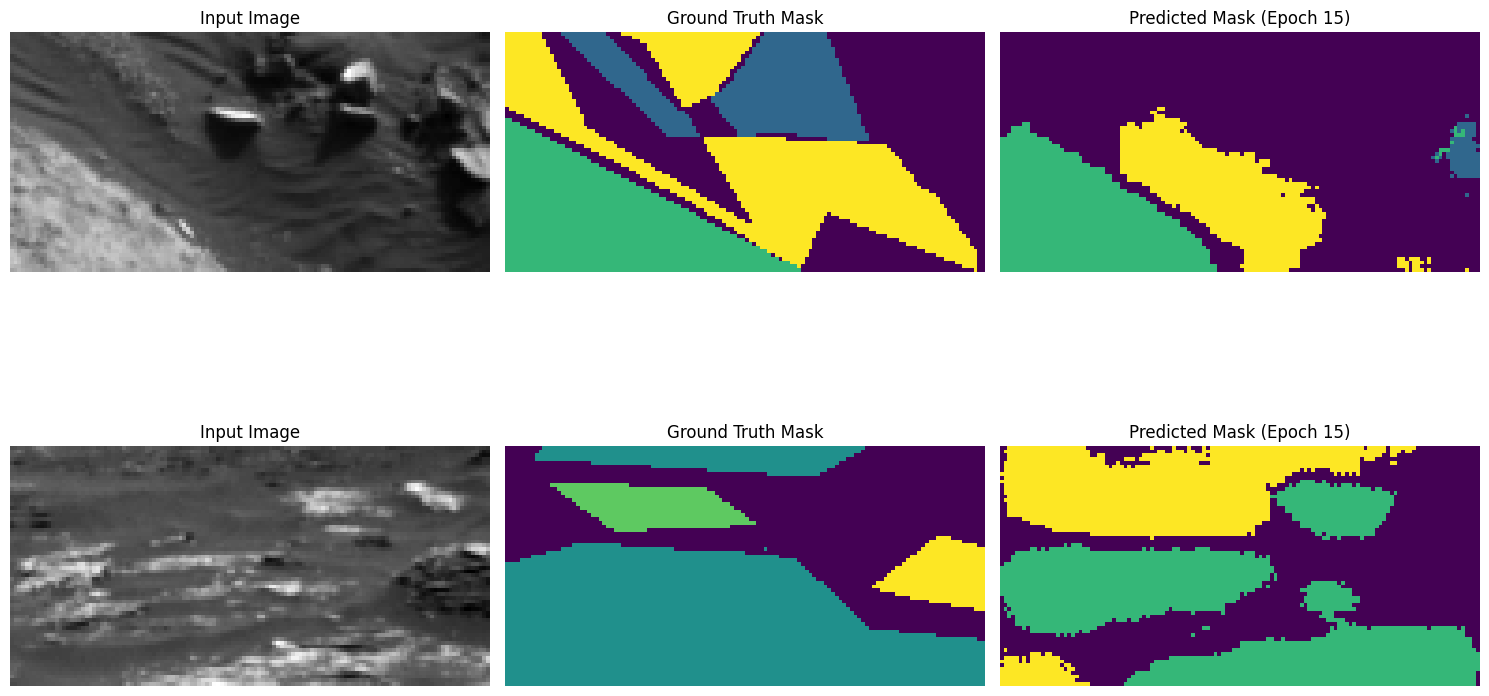

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.7592 - loss: 0.6169 - mean_io_u_1: 0.4497 - mean_iou: 0.4497 - val_accuracy: 0.7535 - val_loss: 0.6519 - val_mean_io_u_1: 0.4428 - val_mean_iou: 0.4428 - learning_rate: 1.0000e-04
Epoch 16/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7662 - loss: 0.6003 - mean_io_u_1: 0.4578 - mean_iou: 0.4578Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 16: val_mean_iou improved to 0.4442, saving model.

Epoch 16: val_loss improved from 0.65186 to 0.64165, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


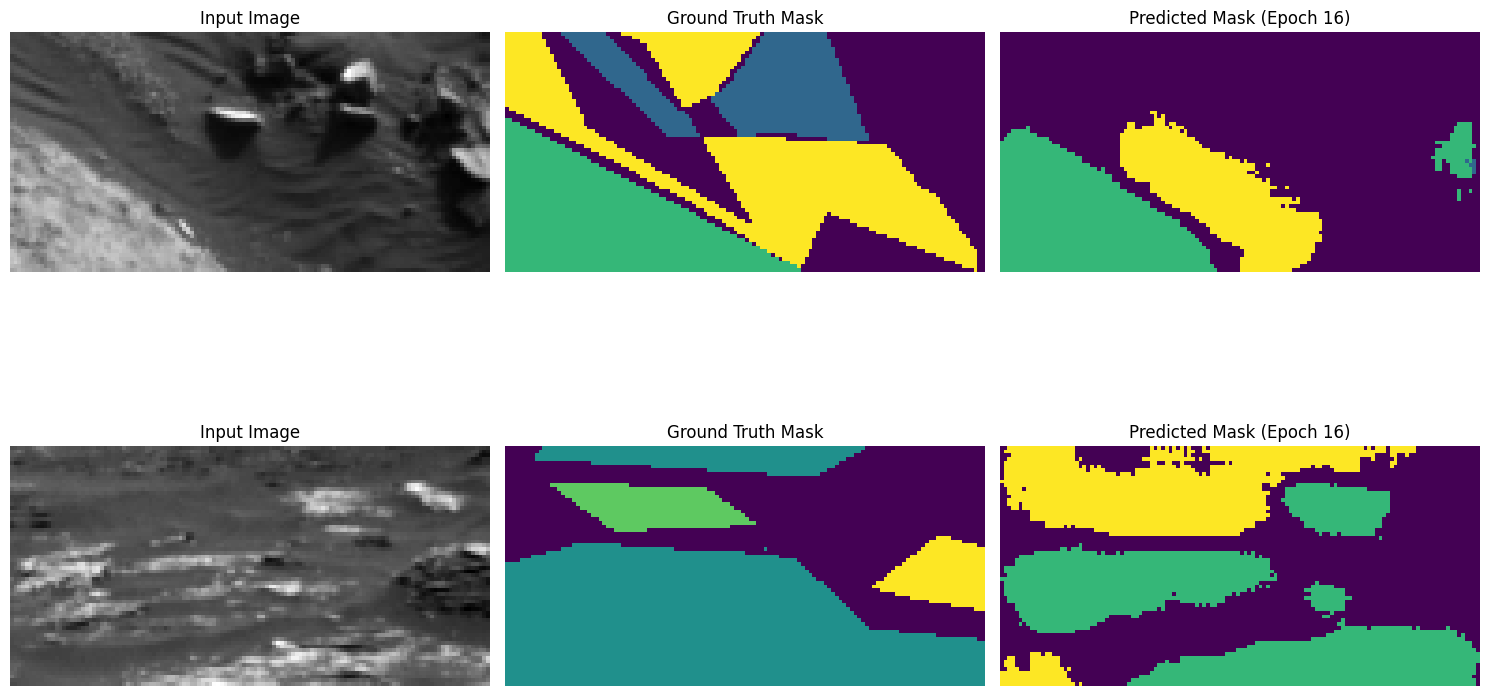

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.7662 - loss: 0.6002 - mean_io_u_1: 0.4577 - mean_iou: 0.4577 - val_accuracy: 0.7551 - val_loss: 0.6417 - val_mean_io_u_1: 0.4442 - val_mean_iou: 0.4442 - learning_rate: 1.0000e-04
Epoch 17/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7770 - loss: 0.5744 - mean_io_u_1: 0.4717 - mean_iou: 0.4717Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 17: val_mean_iou improved to 0.4461, saving model.

Epoch 17: val_loss improved from 0.64165 to 0.64029, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


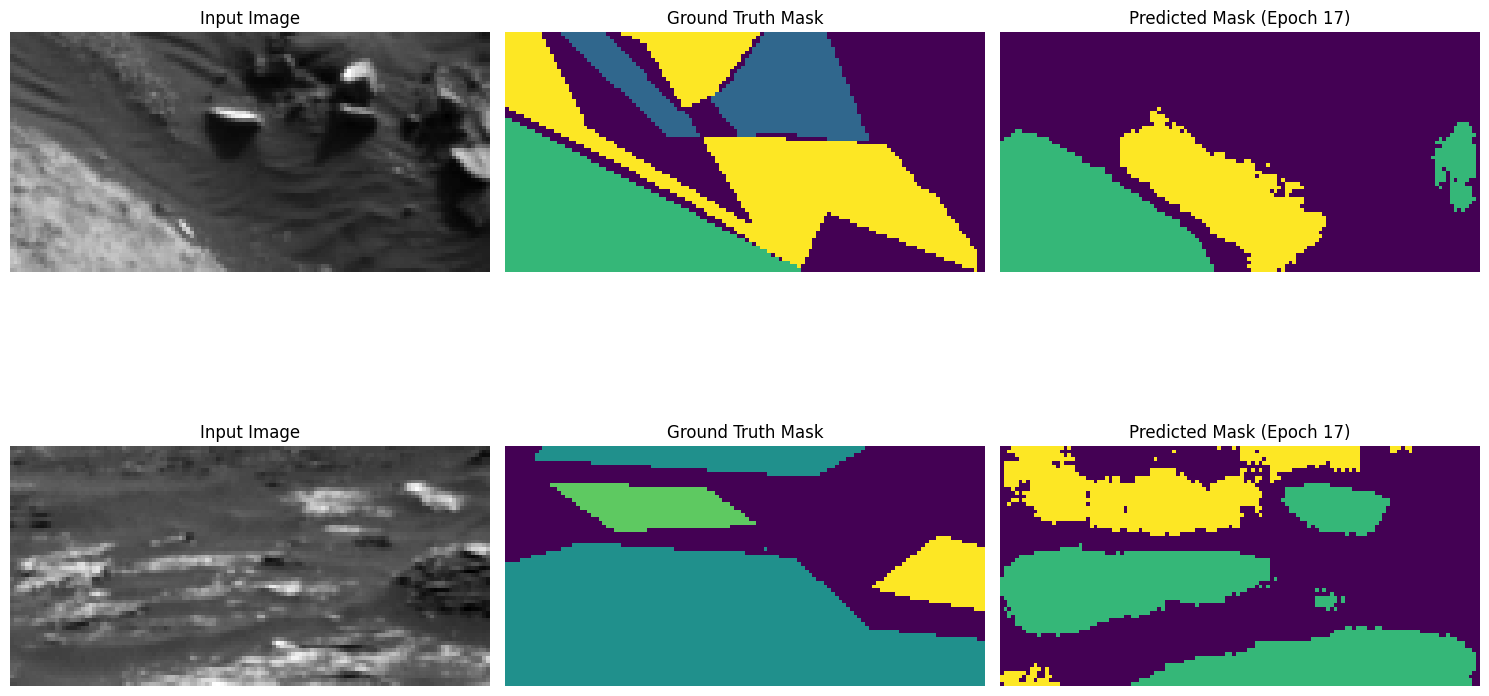

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7770 - loss: 0.5743 - mean_io_u_1: 0.4716 - mean_iou: 0.4716 - val_accuracy: 0.7587 - val_loss: 0.6403 - val_mean_io_u_1: 0.4461 - val_mean_iou: 0.4461 - learning_rate: 1.0000e-04
Epoch 18/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7845 - loss: 0.5559 - mean_io_u_1: 0.4804 - mean_iou: 0.4804Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 18: val_mean_iou improved to 0.4475, saving model.

Epoch 18: val_loss did not improve from 0.64029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


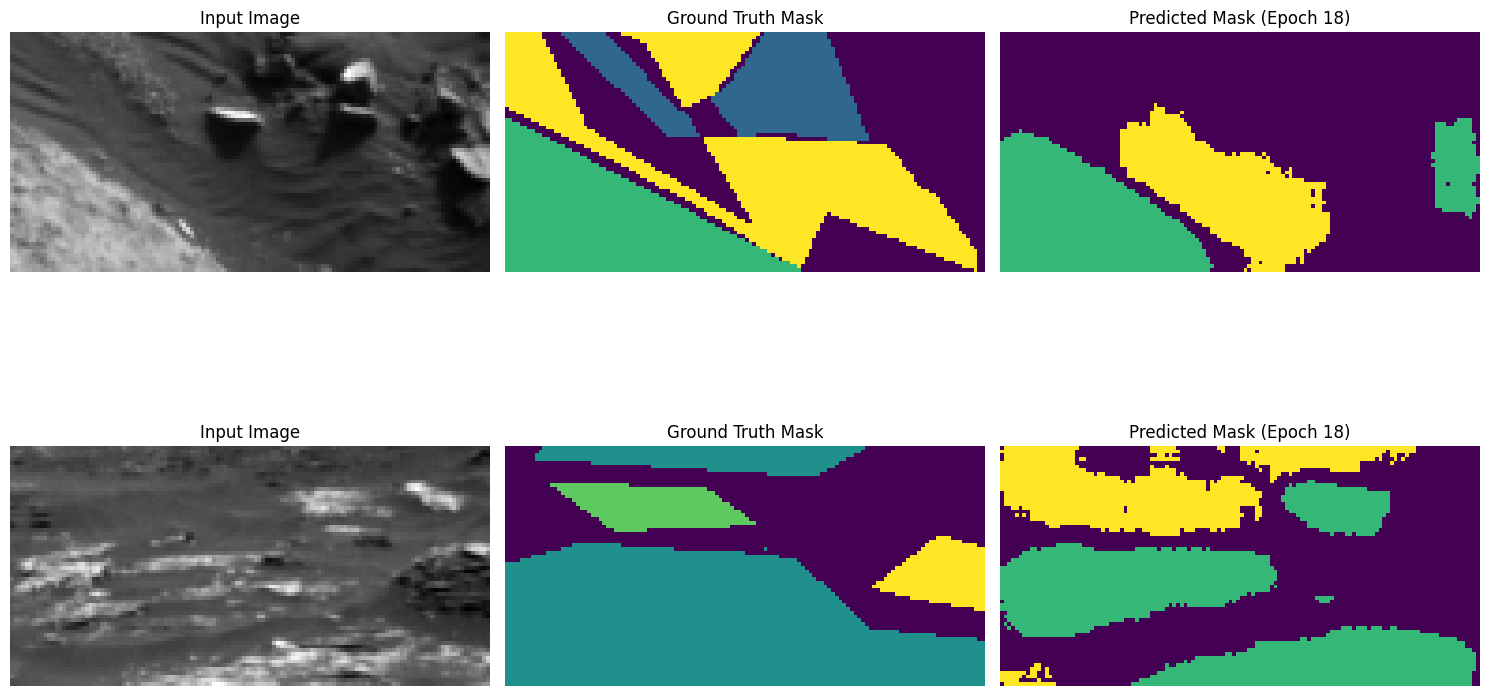

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.7845 - loss: 0.5558 - mean_io_u_1: 0.4804 - mean_iou: 0.4804 - val_accuracy: 0.7577 - val_loss: 0.6496 - val_mean_io_u_1: 0.4475 - val_mean_iou: 0.4475 - learning_rate: 1.0000e-04
Epoch 19/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7895 - loss: 0.5425 - mean_io_u_1: 0.4863 - mean_iou: 0.4863Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 19: val_loss did not improve from 0.64029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


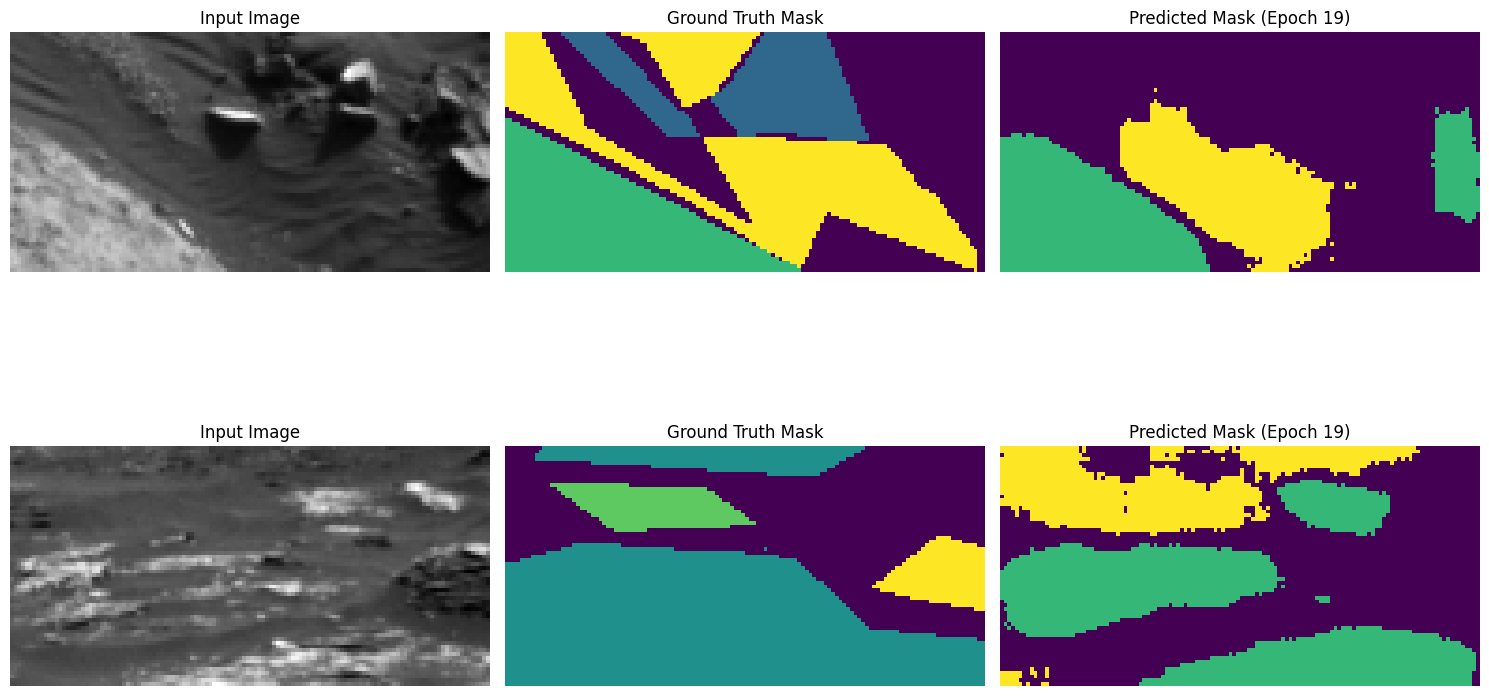

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7895 - loss: 0.5425 - mean_io_u_1: 0.4863 - mean_iou: 0.4863 - val_accuracy: 0.7530 - val_loss: 0.6642 - val_mean_io_u_1: 0.4419 - val_mean_iou: 0.4419 - learning_rate: 1.0000e-04
Epoch 20/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7951 - loss: 0.5280 - mean_io_u_1: 0.4951 - mean_iou: 0.4951Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 20: val_loss did not improve from 0.64029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


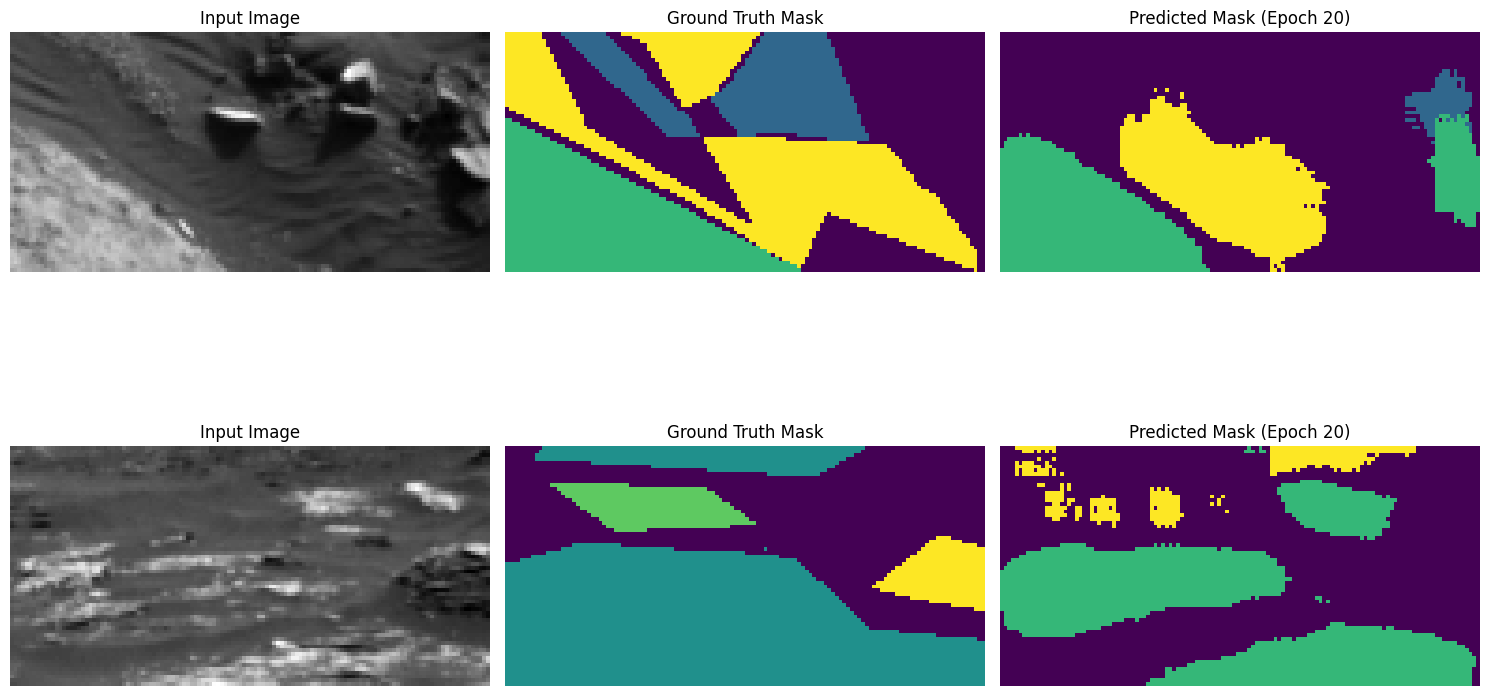

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.7951 - loss: 0.5280 - mean_io_u_1: 0.4951 - mean_iou: 0.4951 - val_accuracy: 0.7514 - val_loss: 0.6762 - val_mean_io_u_1: 0.4387 - val_mean_iou: 0.4387 - learning_rate: 1.0000e-04
Epoch 21/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8043 - loss: 0.5057 - mean_io_u_1: 0.5041 - mean_iou: 0.5041Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 21: val_loss did not improve from 0.64029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


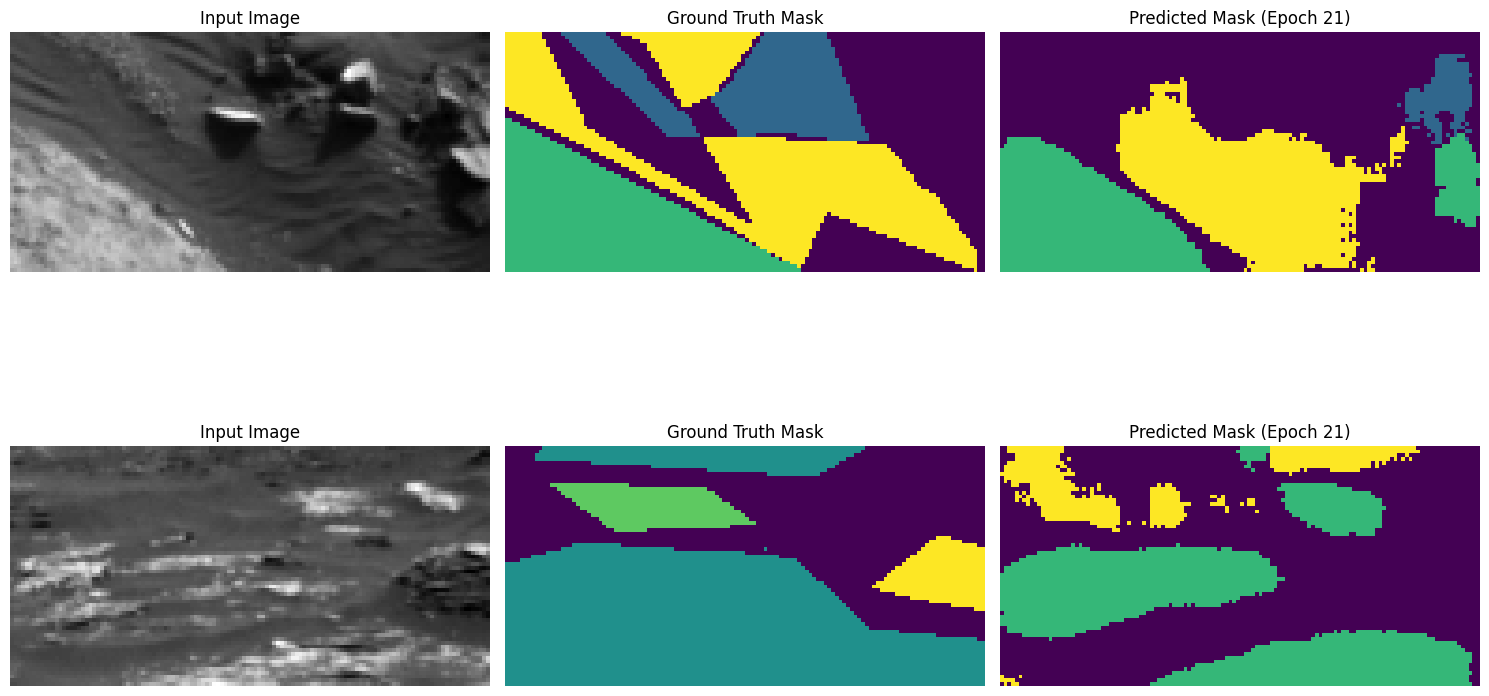

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8043 - loss: 0.5057 - mean_io_u_1: 0.5041 - mean_iou: 0.5041 - val_accuracy: 0.7535 - val_loss: 0.6700 - val_mean_io_u_1: 0.4395 - val_mean_iou: 0.4395 - learning_rate: 1.0000e-04
Epoch 22/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8119 - loss: 0.4872 - mean_io_u_1: 0.5130 - mean_iou: 0.5130Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 22: val_loss did not improve from 0.64029

Epoch 22: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


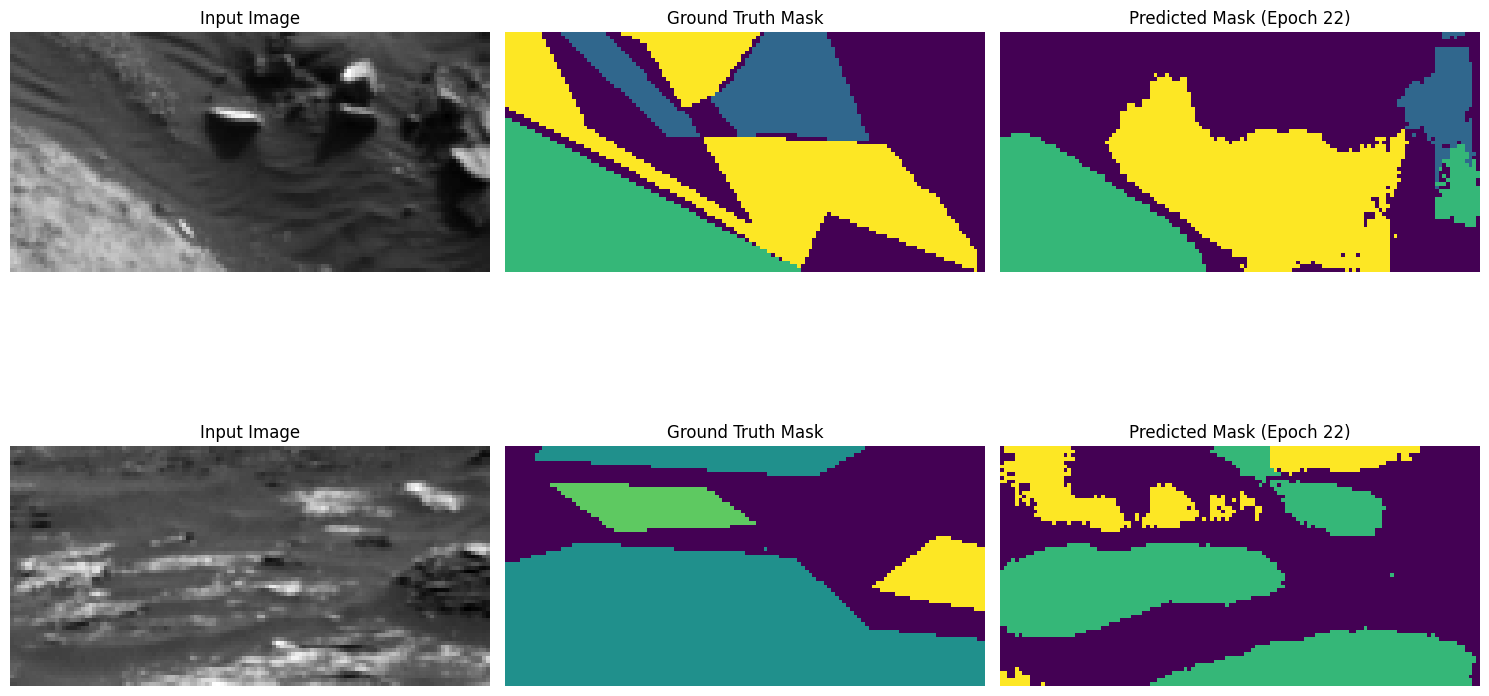

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8119 - loss: 0.4871 - mean_io_u_1: 0.5130 - mean_iou: 0.5130 - val_accuracy: 0.7532 - val_loss: 0.6884 - val_mean_io_u_1: 0.4405 - val_mean_iou: 0.4405 - learning_rate: 1.0000e-04
Epoch 23/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8234 - loss: 0.4581 - mean_io_u_1: 0.5296 - mean_iou: 0.5296Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 23: val_mean_iou improved to 0.4691, saving model.

Epoch 23: val_loss improved from 0.64029 to 0.63628, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


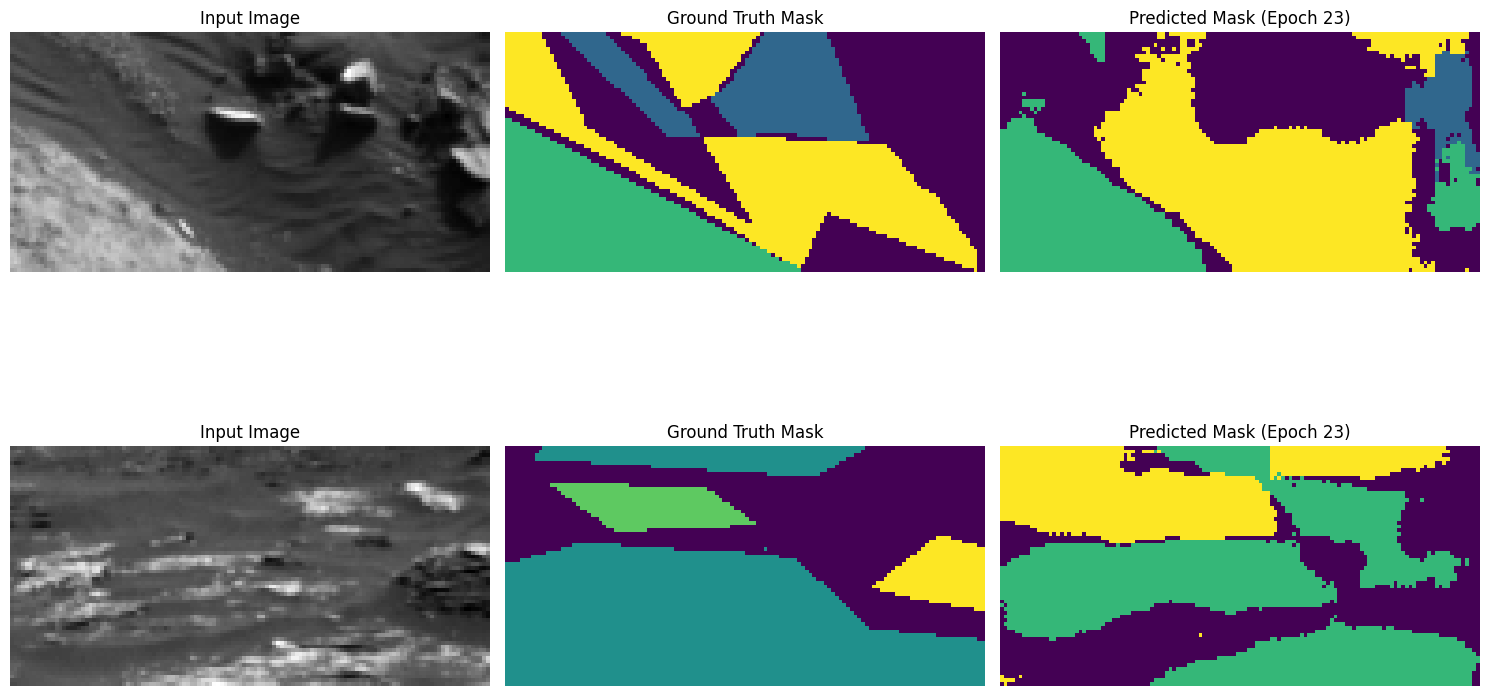

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.8234 - loss: 0.4581 - mean_io_u_1: 0.5296 - mean_iou: 0.5296 - val_accuracy: 0.7657 - val_loss: 0.6363 - val_mean_io_u_1: 0.4691 - val_mean_iou: 0.4691 - learning_rate: 5.0000e-05
Epoch 24/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8343 - loss: 0.4289 - mean_io_u_1: 0.5396 - mean_iou: 0.5396Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 24: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


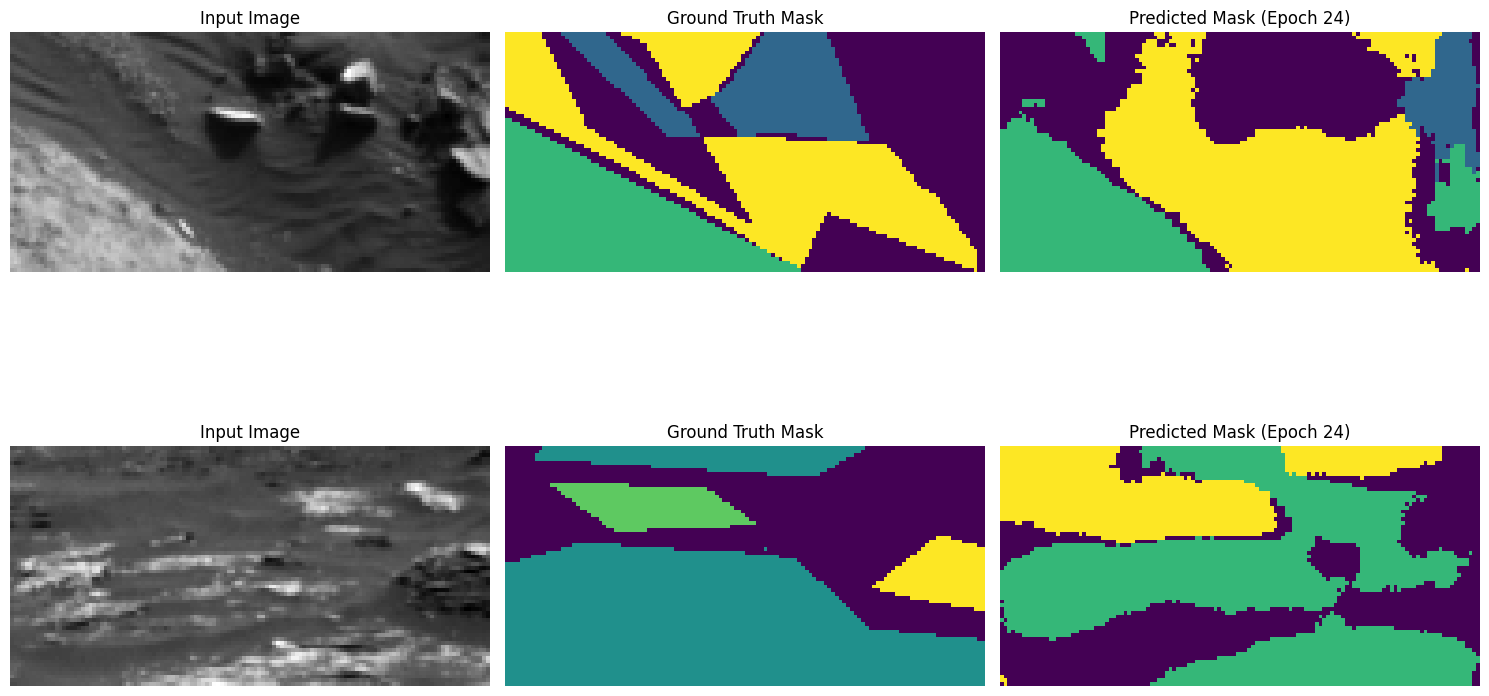

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8343 - loss: 0.4289 - mean_io_u_1: 0.5395 - mean_iou: 0.5395 - val_accuracy: 0.7661 - val_loss: 0.6484 - val_mean_io_u_1: 0.4683 - val_mean_iou: 0.4683 - learning_rate: 5.0000e-05
Epoch 25/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8406 - loss: 0.4127 - mean_io_u_1: 0.5464 - mean_iou: 0.5464Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 25: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


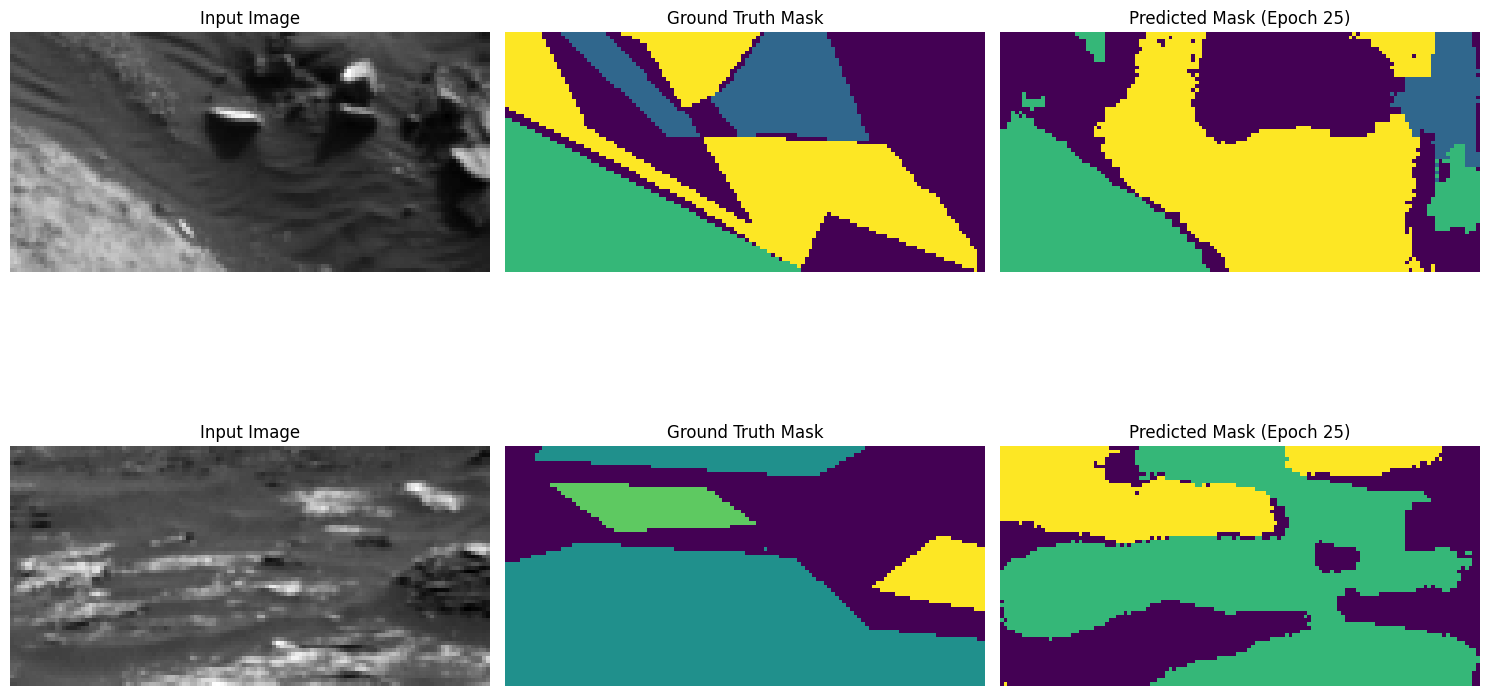

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8407 - loss: 0.4127 - mean_io_u_1: 0.5464 - mean_iou: 0.5464 - val_accuracy: 0.7653 - val_loss: 0.6632 - val_mean_io_u_1: 0.4656 - val_mean_iou: 0.4656 - learning_rate: 5.0000e-05
Epoch 26/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8467 - loss: 0.3970 - mean_io_u_1: 0.5523 - mean_iou: 0.5523Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 26: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


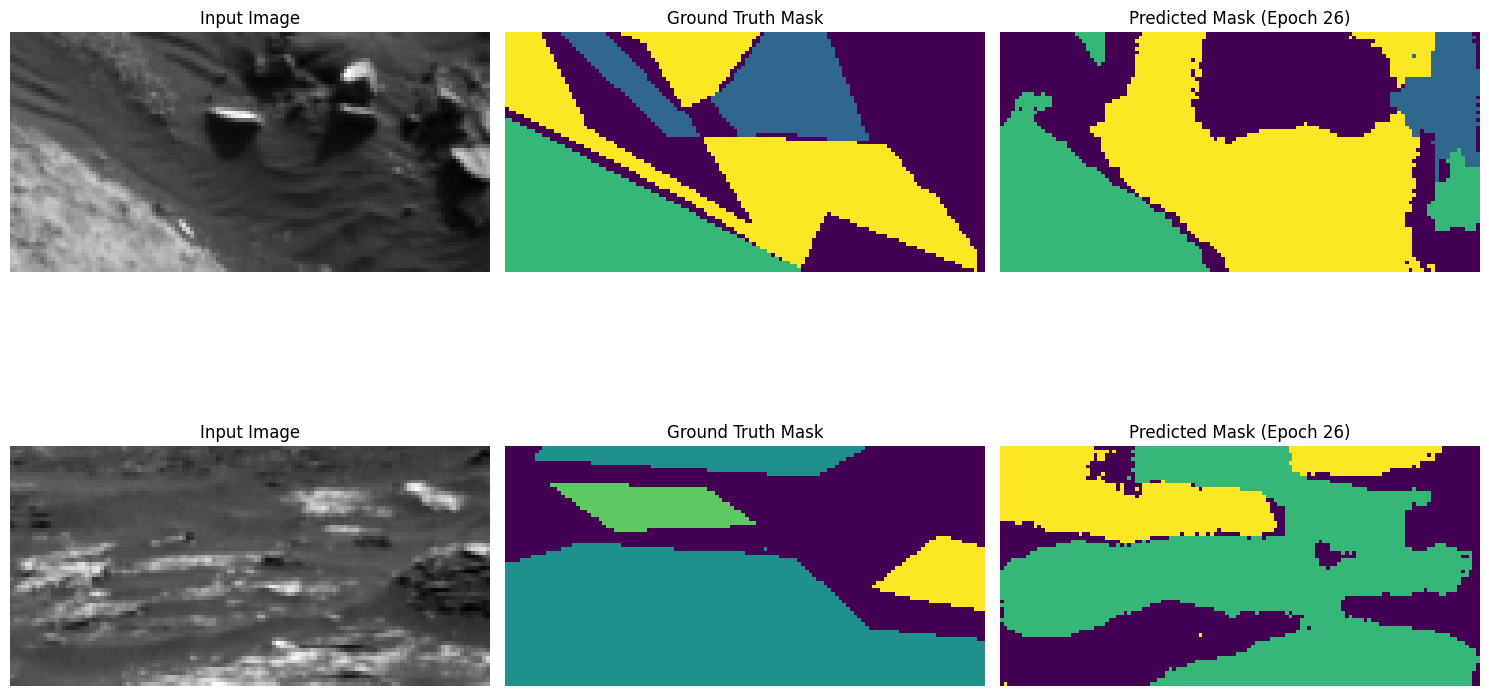

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.8467 - loss: 0.3970 - mean_io_u_1: 0.5523 - mean_iou: 0.5523 - val_accuracy: 0.7637 - val_loss: 0.6811 - val_mean_io_u_1: 0.4640 - val_mean_iou: 0.4640 - learning_rate: 5.0000e-05
Epoch 27/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8528 - loss: 0.3813 - mean_io_u_1: 0.5585 - mean_iou: 0.5585Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 27: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


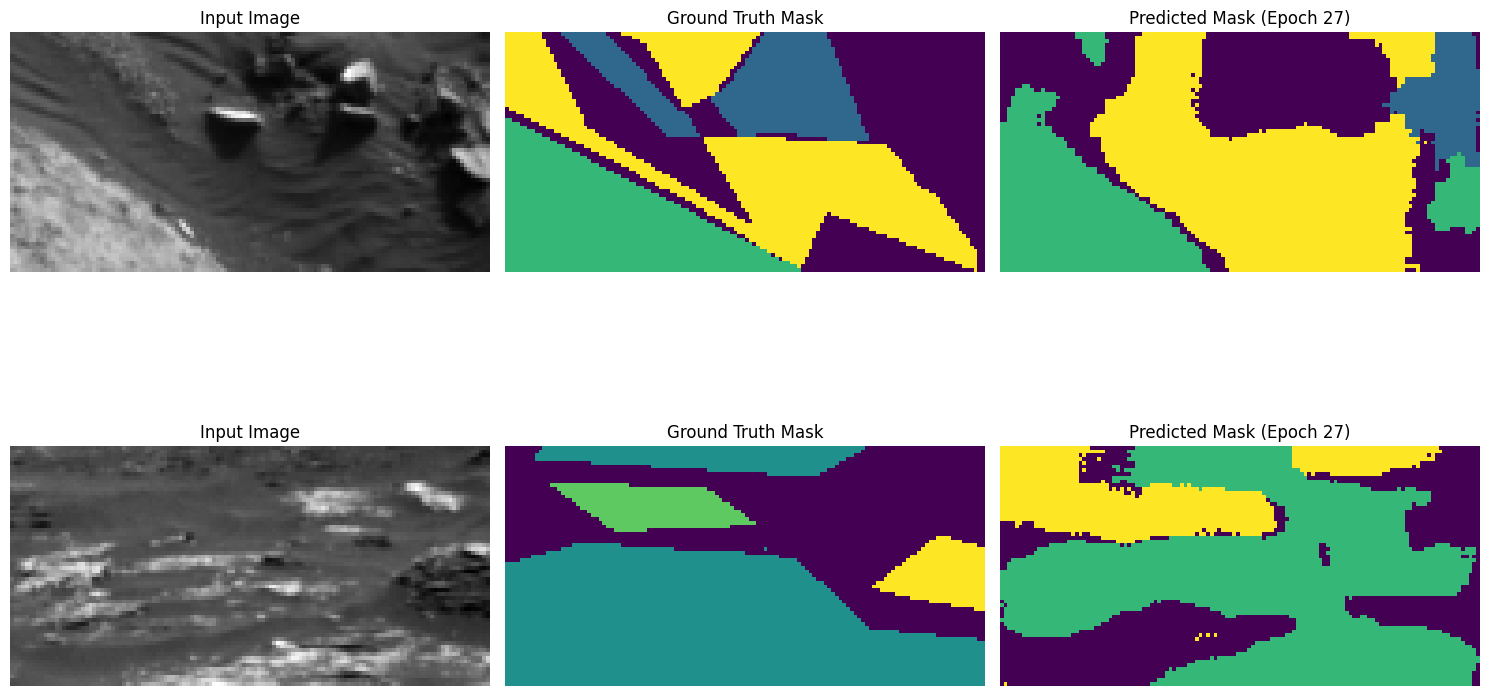

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.8528 - loss: 0.3812 - mean_io_u_1: 0.5585 - mean_iou: 0.5585 - val_accuracy: 0.7619 - val_loss: 0.7000 - val_mean_io_u_1: 0.4632 - val_mean_iou: 0.4632 - learning_rate: 5.0000e-05
Epoch 28/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8590 - loss: 0.3663 - mean_io_u_1: 0.5643 - mean_iou: 0.5643Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 28: val_loss did not improve from 0.63628

Epoch 28: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


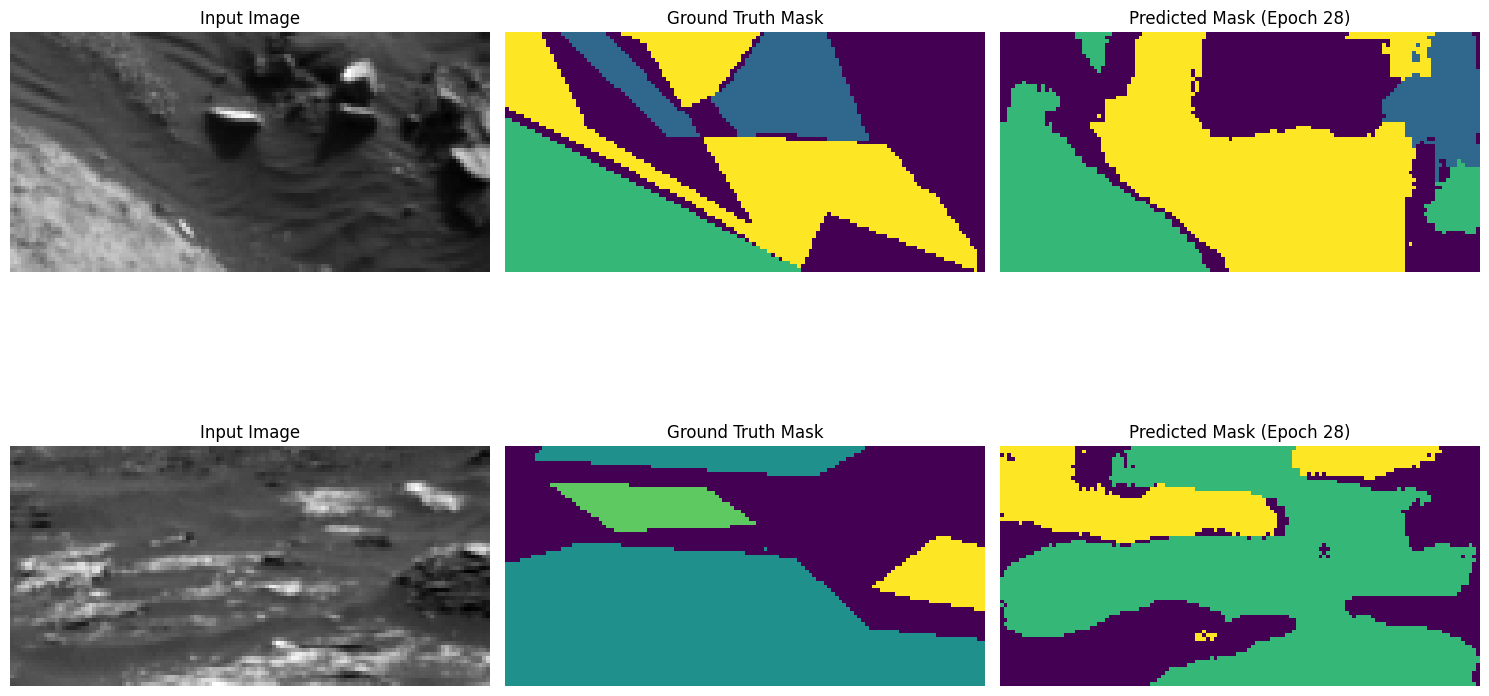

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.8590 - loss: 0.3663 - mean_io_u_1: 0.5643 - mean_iou: 0.5643 - val_accuracy: 0.7590 - val_loss: 0.7166 - val_mean_io_u_1: 0.4618 - val_mean_iou: 0.4618 - learning_rate: 5.0000e-05
Epoch 29/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8613 - loss: 0.3606 - mean_io_u_1: 0.5672 - mean_iou: 0.5672Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 29: val_mean_iou improved to 0.4707, saving model.

Epoch 29: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


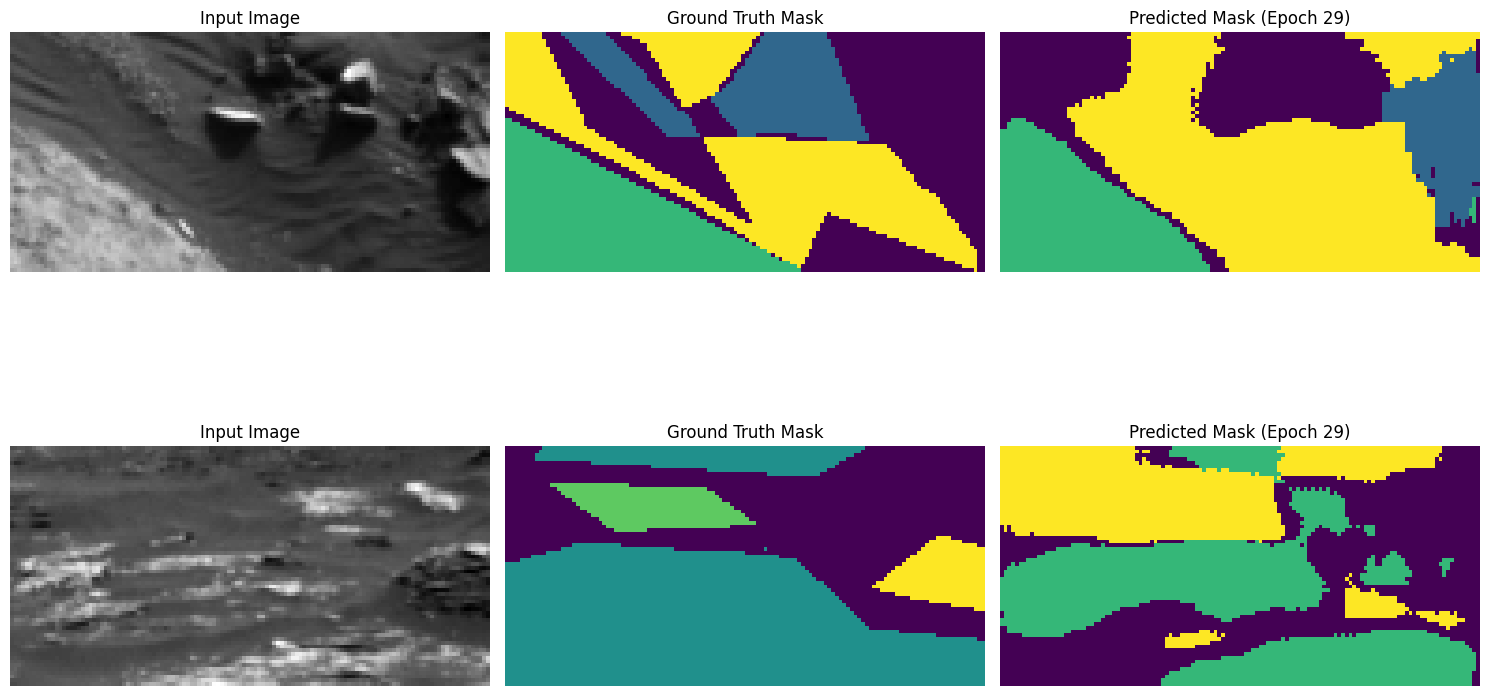

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.8613 - loss: 0.3606 - mean_io_u_1: 0.5672 - mean_iou: 0.5672 - val_accuracy: 0.7611 - val_loss: 0.7265 - val_mean_io_u_1: 0.4707 - val_mean_iou: 0.4707 - learning_rate: 2.5000e-05
Epoch 30/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8680 - loss: 0.3425 - mean_io_u_1: 0.5735 - mean_iou: 0.5735Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 30: val_mean_iou improved to 0.4724, saving model.

Epoch 30: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


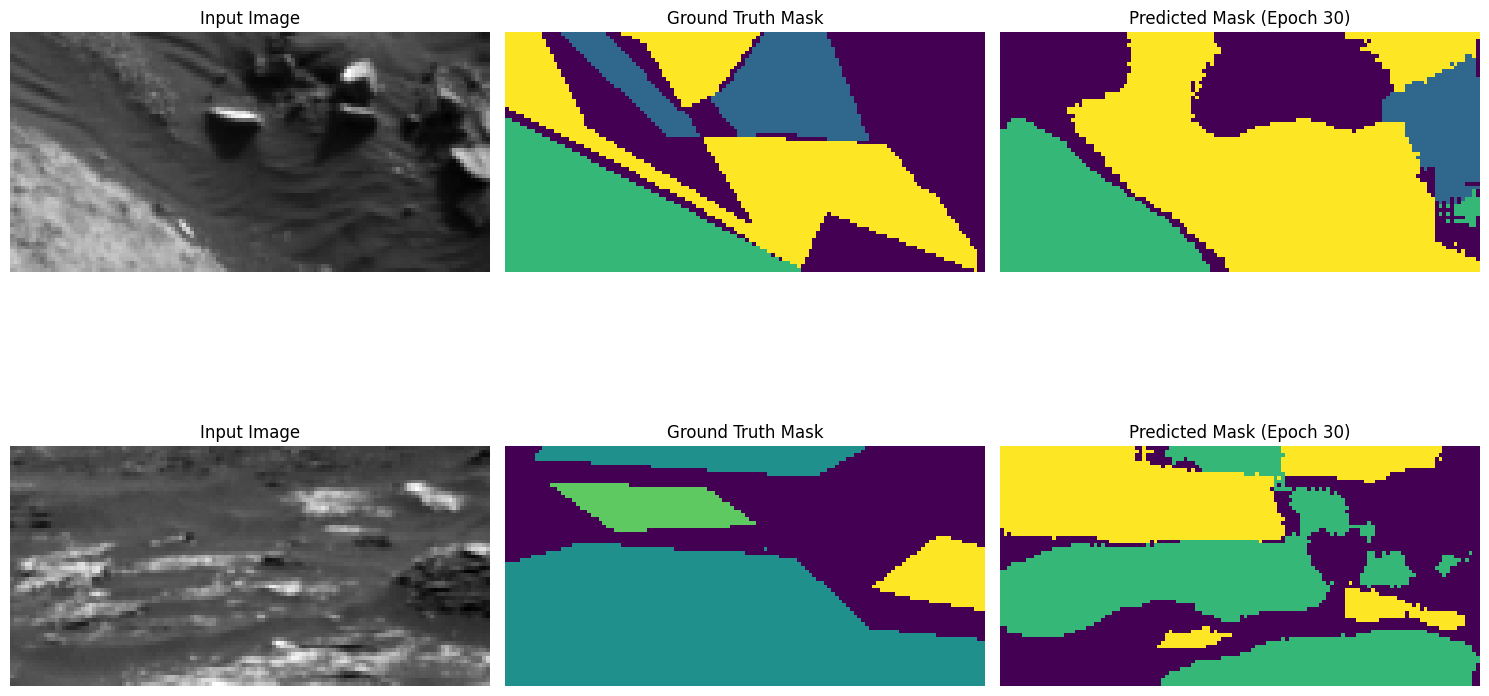

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 197ms/step - accuracy: 0.8680 - loss: 0.3425 - mean_io_u_1: 0.5735 - mean_iou: 0.5735 - val_accuracy: 0.7625 - val_loss: 0.7393 - val_mean_io_u_1: 0.4724 - val_mean_iou: 0.4724 - learning_rate: 2.5000e-05
Epoch 31/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8735 - loss: 0.3289 - mean_io_u_1: 0.5789 - mean_iou: 0.5789Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 31: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


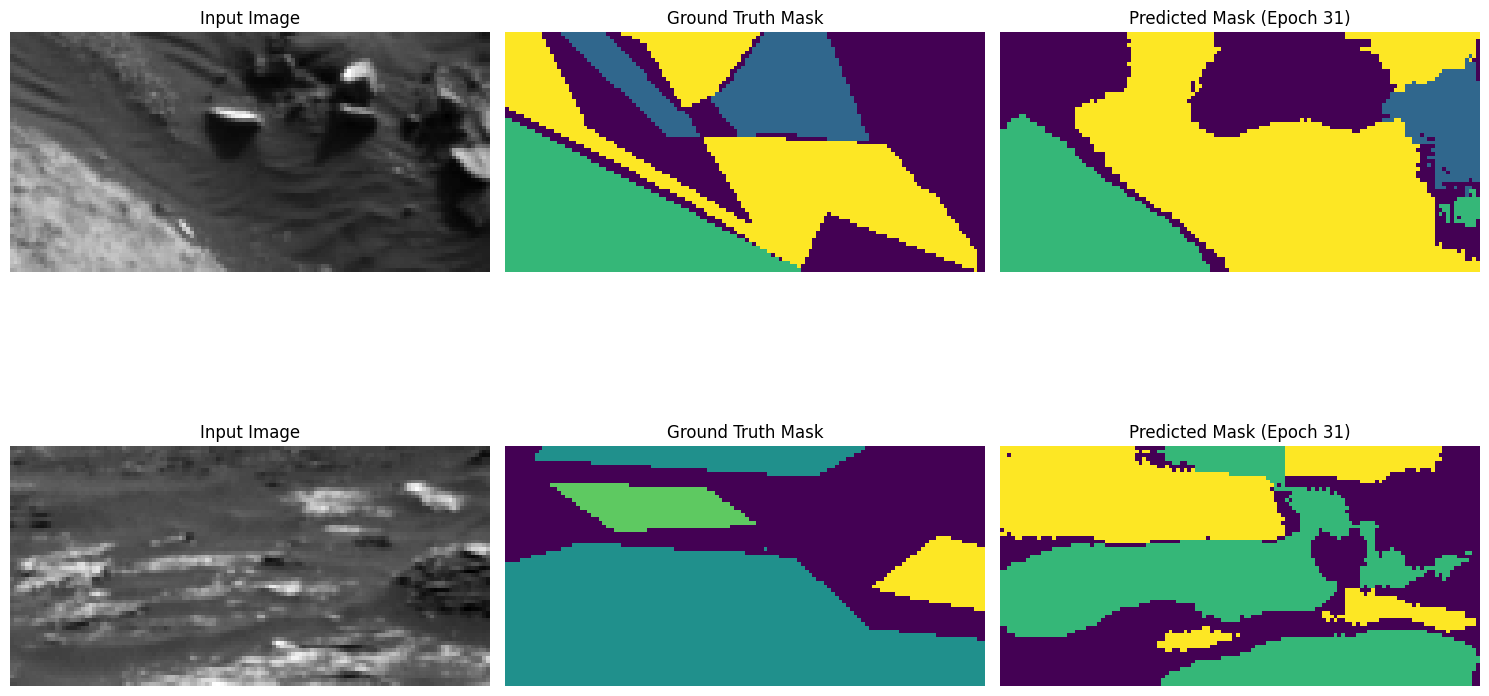

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.8735 - loss: 0.3289 - mean_io_u_1: 0.5789 - mean_iou: 0.5789 - val_accuracy: 0.7631 - val_loss: 0.7533 - val_mean_io_u_1: 0.4723 - val_mean_iou: 0.4723 - learning_rate: 2.5000e-05
Epoch 32/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8781 - loss: 0.3175 - mean_io_u_1: 0.5830 - mean_iou: 0.5830Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 32: val_mean_iou improved to 0.4724, saving model.

Epoch 32: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


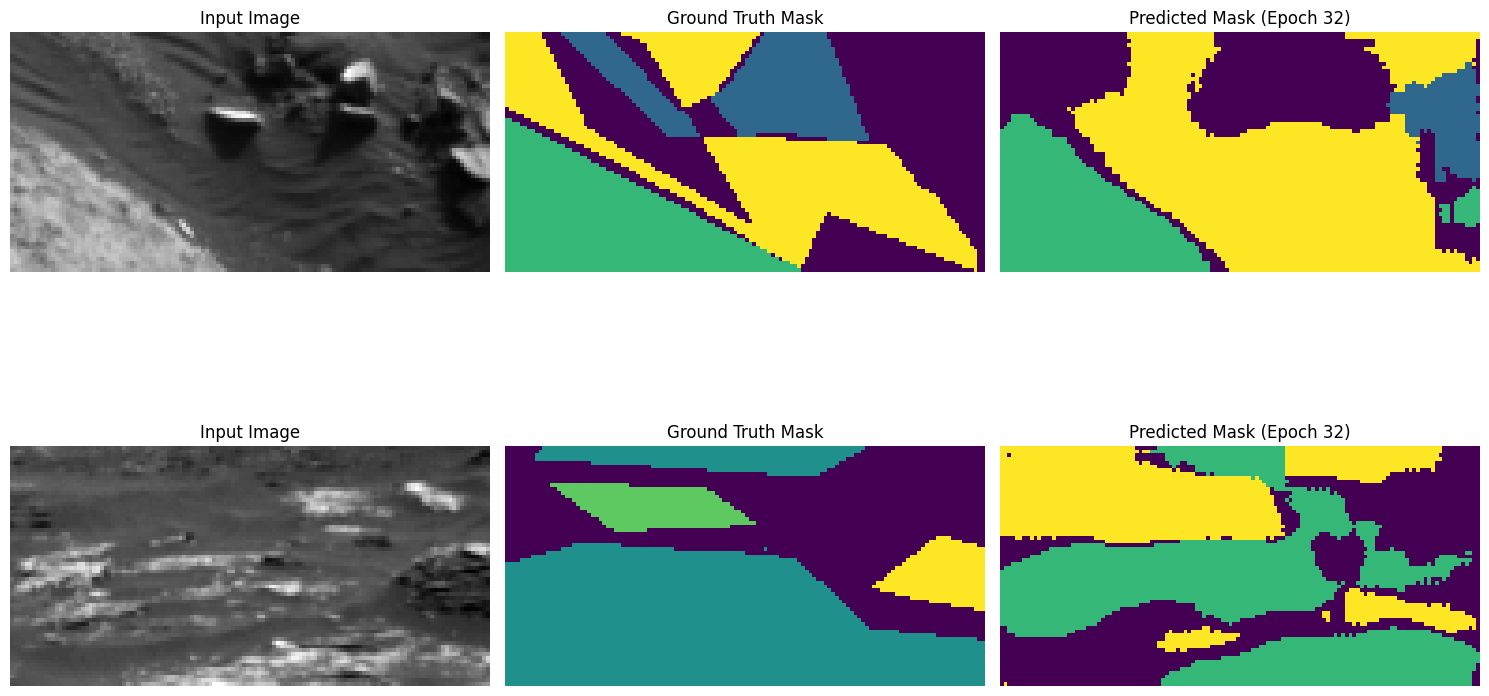

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.8781 - loss: 0.3175 - mean_io_u_1: 0.5830 - mean_iou: 0.5830 - val_accuracy: 0.7635 - val_loss: 0.7665 - val_mean_io_u_1: 0.4724 - val_mean_iou: 0.4724 - learning_rate: 2.5000e-05
Epoch 33/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8822 - loss: 0.3074 - mean_io_u_1: 0.5867 - mean_iou: 0.5867Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 33: val_loss did not improve from 0.63628

Epoch 33: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


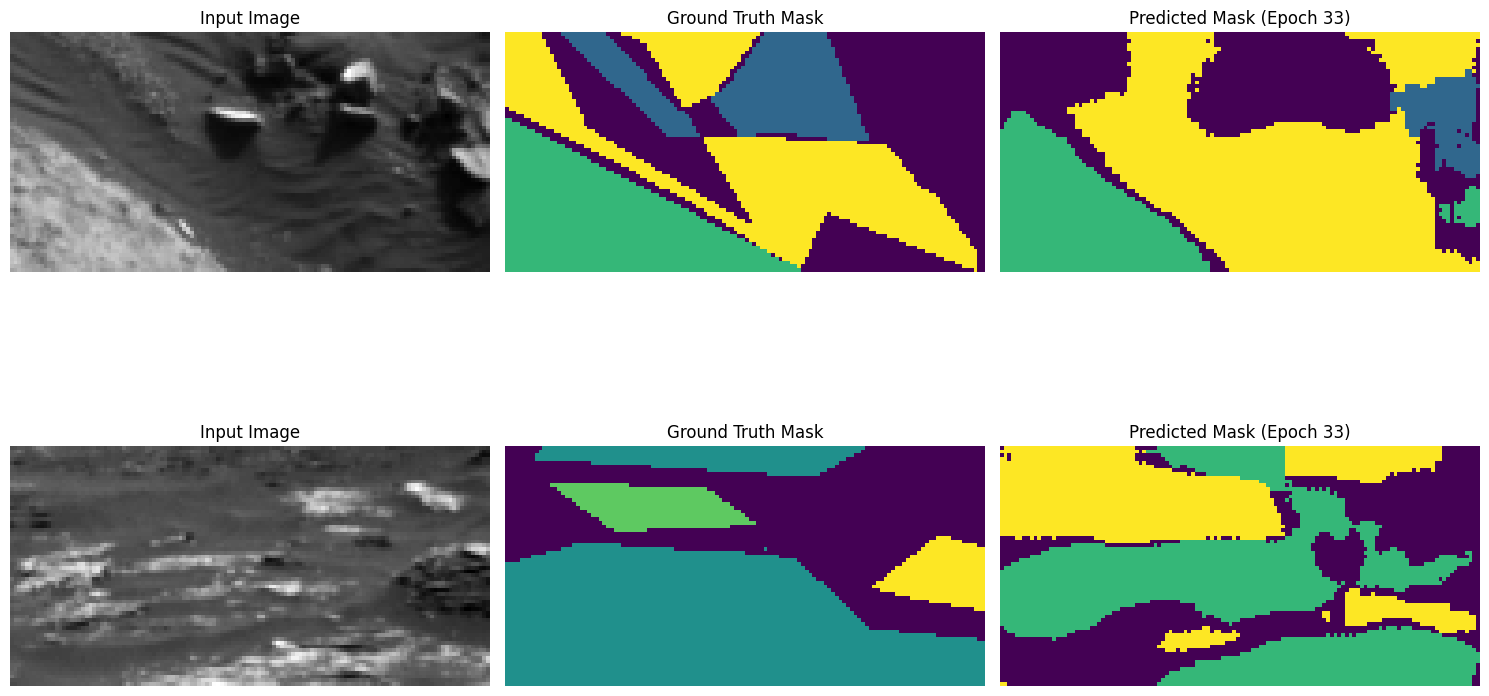

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.8822 - loss: 0.3074 - mean_io_u_1: 0.5867 - mean_iou: 0.5867 - val_accuracy: 0.7635 - val_loss: 0.7802 - val_mean_io_u_1: 0.4717 - val_mean_iou: 0.4717 - learning_rate: 2.5000e-05
Epoch 34/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8838 - loss: 0.3021 - mean_io_u_1: 0.5894 - mean_iou: 0.5894Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])
Epoch 34: val_mean_iou improved to 0.4808, saving model.

Epoch 34: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


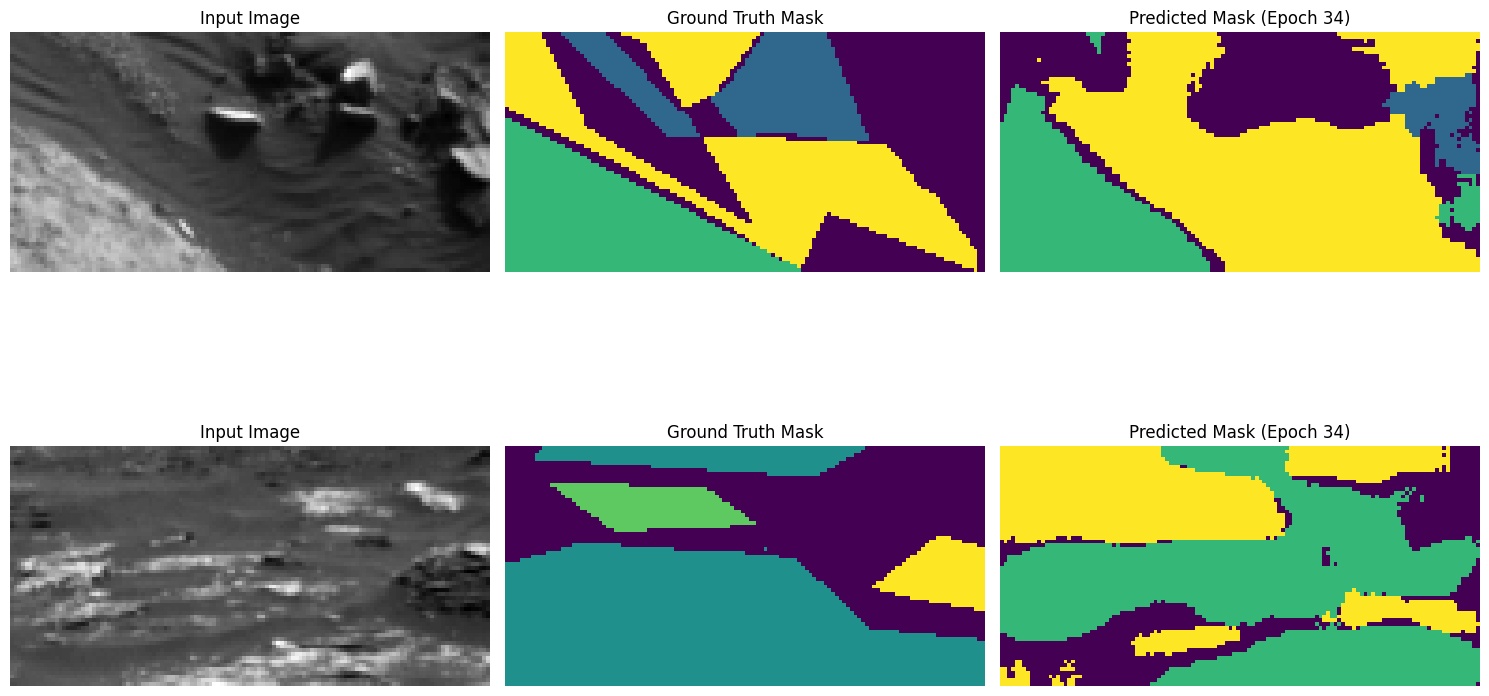

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.8838 - loss: 0.3021 - mean_io_u_1: 0.5894 - mean_iou: 0.5894 - val_accuracy: 0.7690 - val_loss: 0.7717 - val_mean_io_u_1: 0.4808 - val_mean_iou: 0.4808 - learning_rate: 1.2500e-05
Epoch 35/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8868 - loss: 0.2946 - mean_io_u_1: 0.5914 - mean_iou: 0.5914Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 35: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


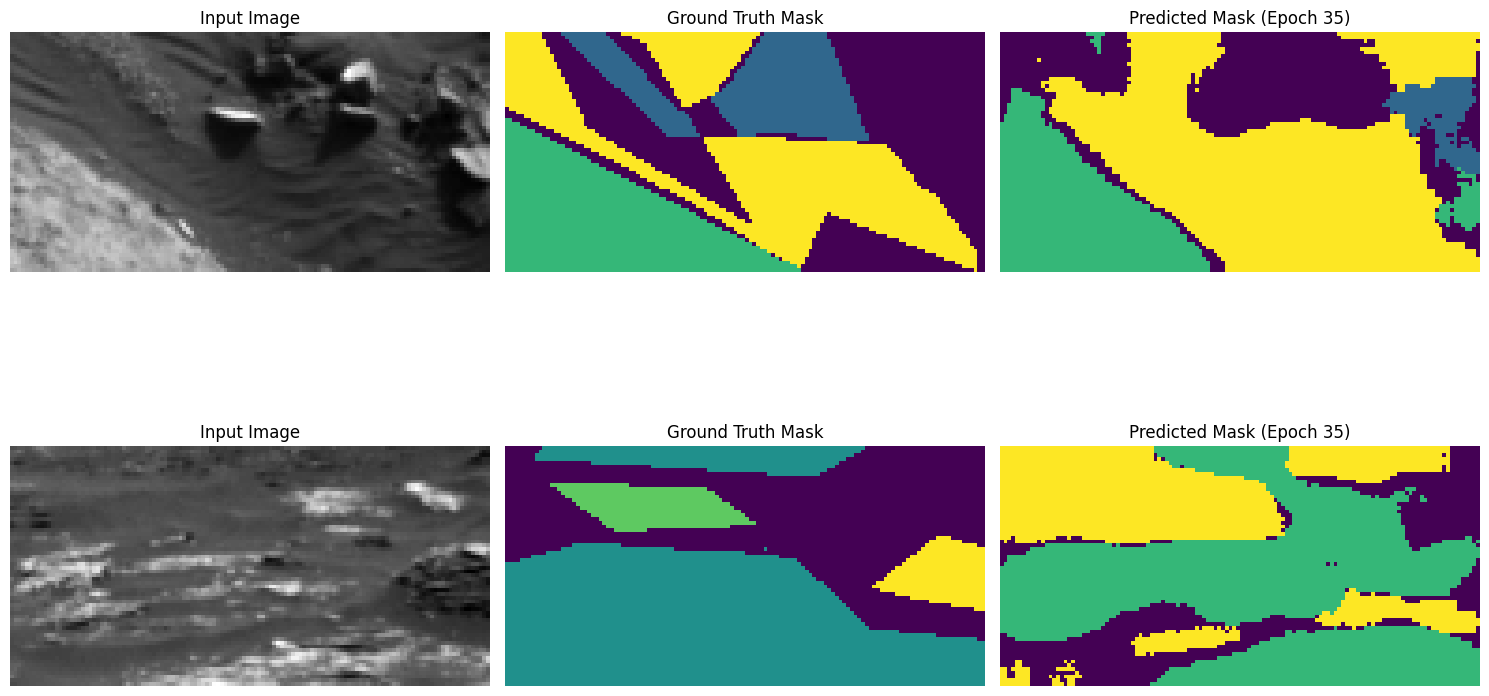

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.8868 - loss: 0.2946 - mean_io_u_1: 0.5914 - mean_iou: 0.5914 - val_accuracy: 0.7686 - val_loss: 0.7808 - val_mean_io_u_1: 0.4801 - val_mean_iou: 0.4801 - learning_rate: 1.2500e-05
Epoch 36/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8897 - loss: 0.2876 - mean_io_u_1: 0.5936 - mean_iou: 0.5936Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 36: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


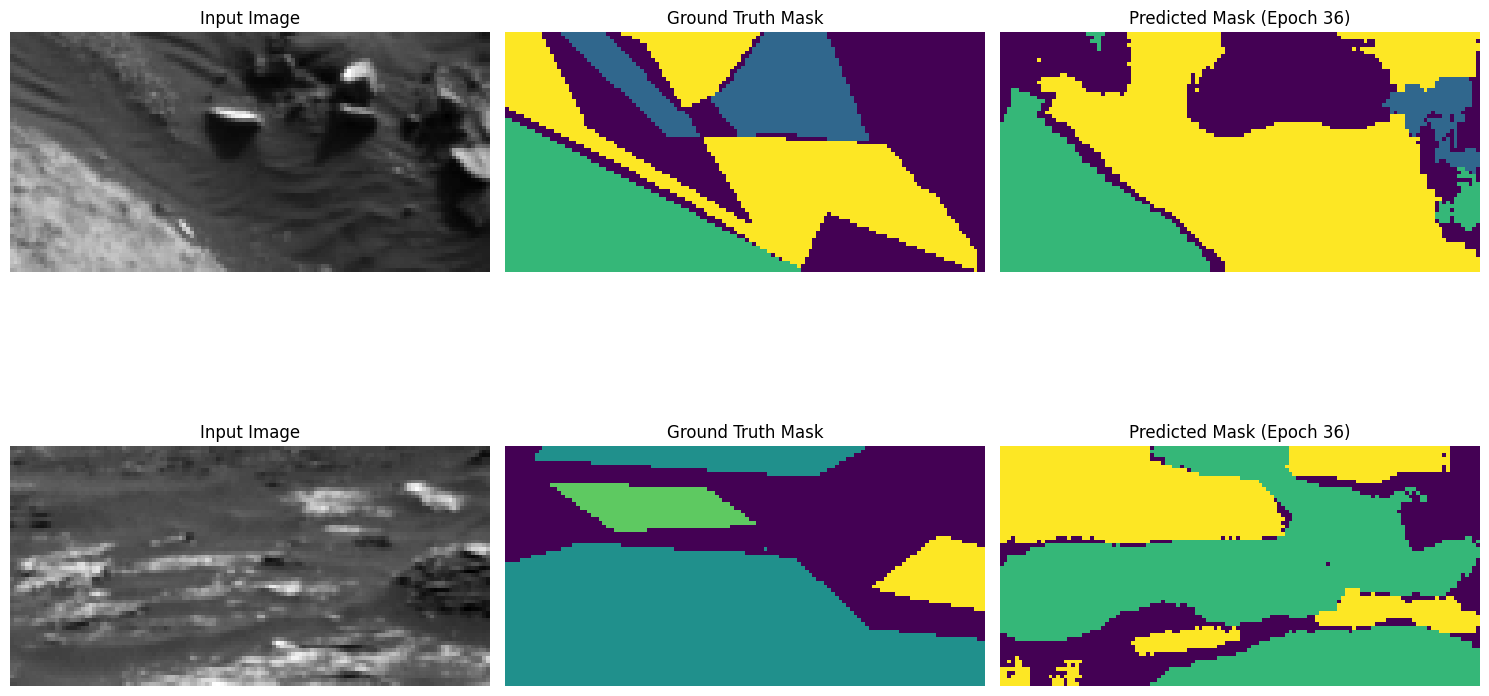

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.8897 - loss: 0.2876 - mean_io_u_1: 0.5936 - mean_iou: 0.5936 - val_accuracy: 0.7682 - val_loss: 0.7908 - val_mean_io_u_1: 0.4795 - val_mean_iou: 0.4795 - learning_rate: 1.2500e-05
Epoch 37/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8923 - loss: 0.2813 - mean_io_u_1: 0.5956 - mean_iou: 0.5956Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 37: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


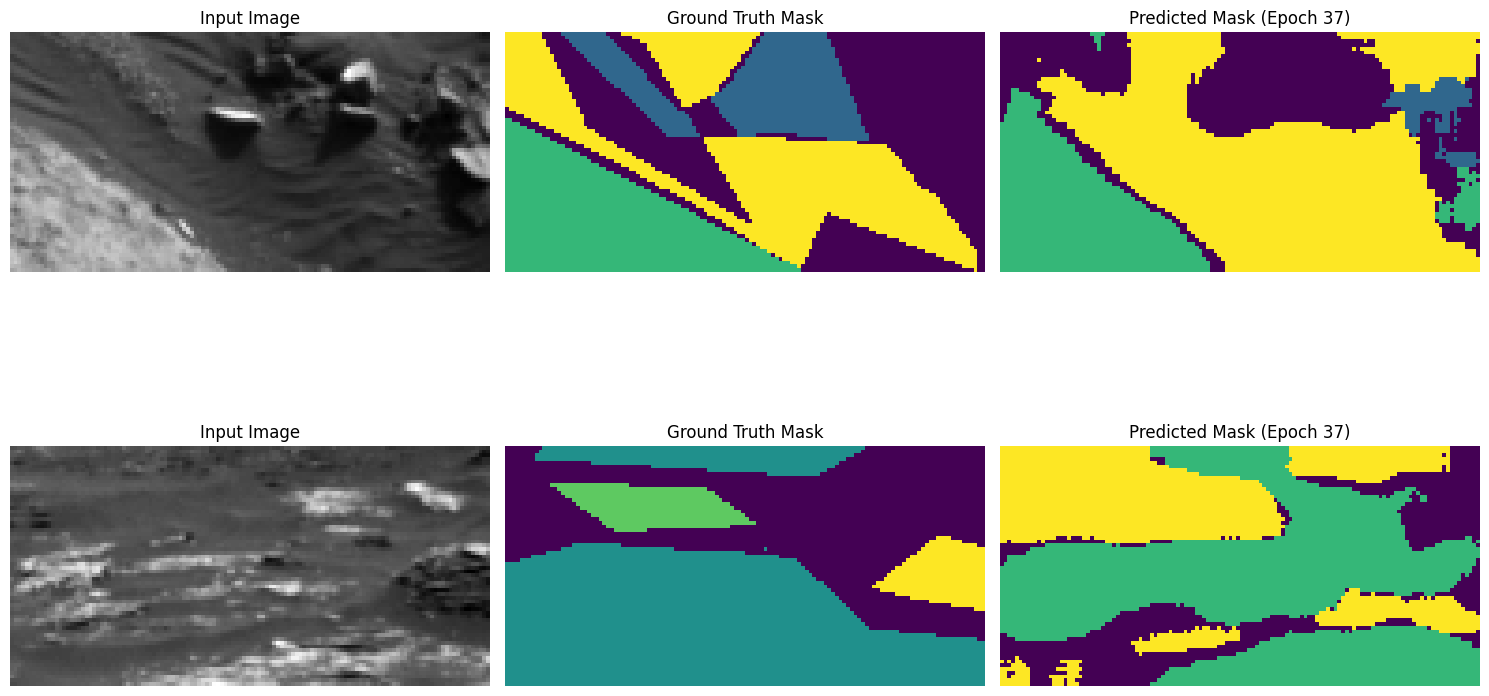

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.8923 - loss: 0.2813 - mean_io_u_1: 0.5956 - mean_iou: 0.5956 - val_accuracy: 0.7679 - val_loss: 0.8006 - val_mean_io_u_1: 0.4792 - val_mean_iou: 0.4792 - learning_rate: 1.2500e-05
Epoch 38/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8947 - loss: 0.2755 - mean_io_u_1: 0.5975 - mean_iou: 0.5975Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 38: val_loss did not improve from 0.63628

Epoch 38: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


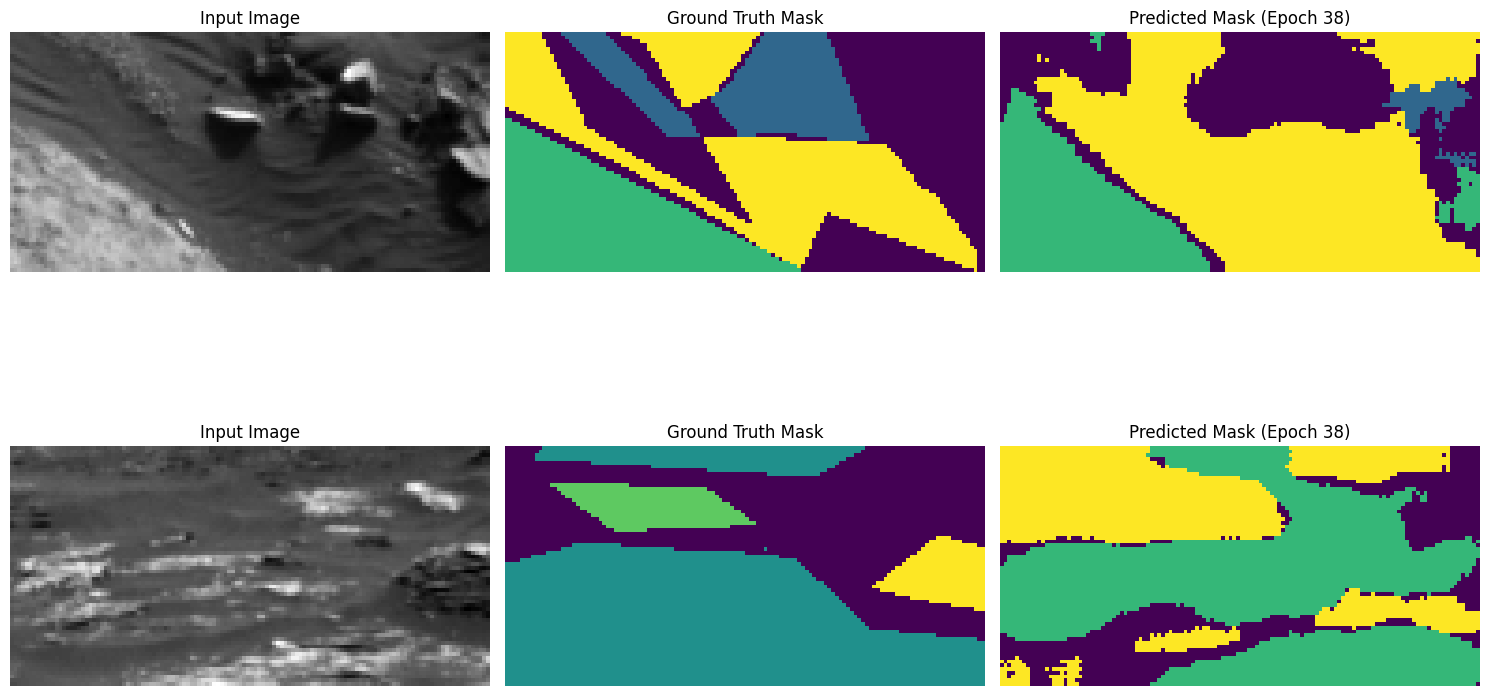

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.8947 - loss: 0.2755 - mean_io_u_1: 0.5975 - mean_iou: 0.5975 - val_accuracy: 0.7676 - val_loss: 0.8110 - val_mean_io_u_1: 0.4789 - val_mean_iou: 0.4789 - learning_rate: 1.2500e-05
Epoch 39/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8970 - loss: 0.2691 - mean_io_u_1: 0.5999 - mean_iou: 0.5999Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 39: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


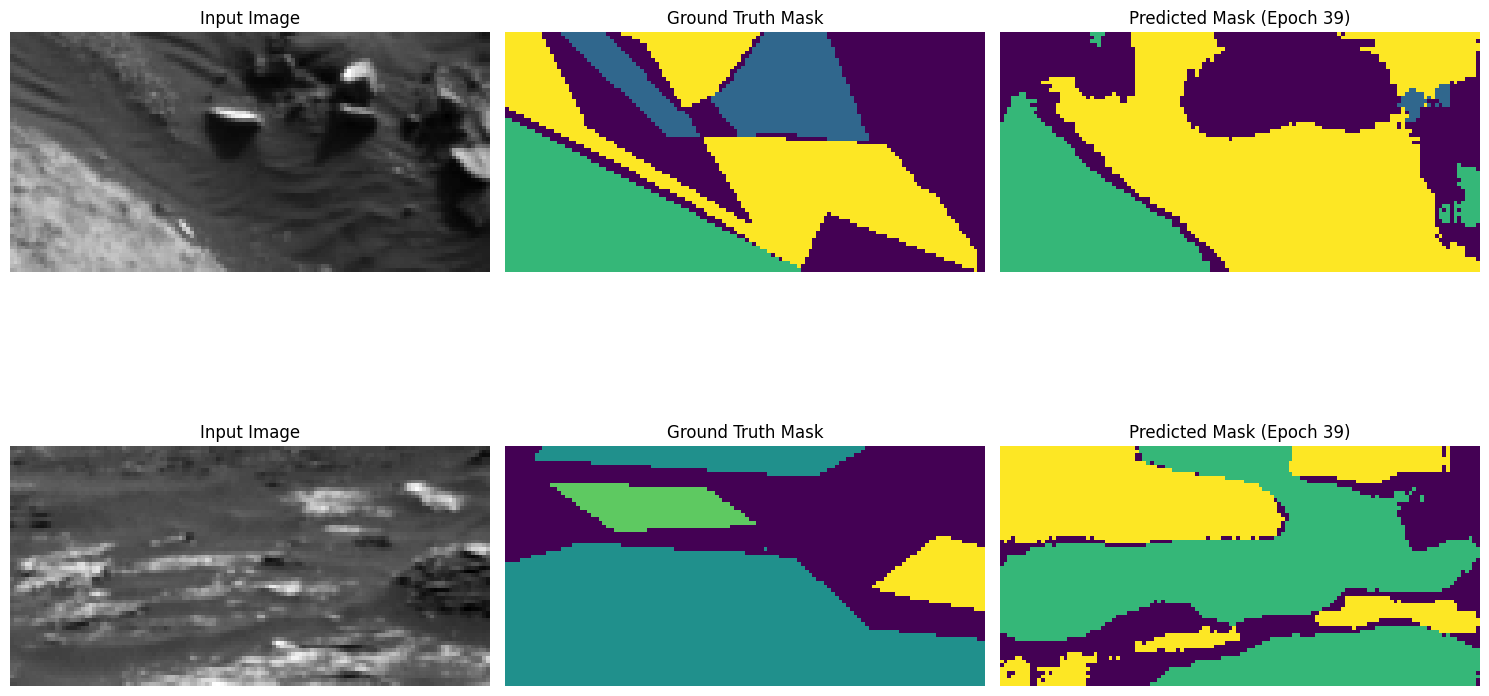

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8970 - loss: 0.2691 - mean_io_u_1: 0.5999 - mean_iou: 0.5999 - val_accuracy: 0.7628 - val_loss: 0.8127 - val_mean_io_u_1: 0.4700 - val_mean_iou: 0.4700 - learning_rate: 6.2500e-06
Epoch 40/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8984 - loss: 0.2659 - mean_io_u_1: 0.6013 - mean_iou: 0.6013Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 40: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


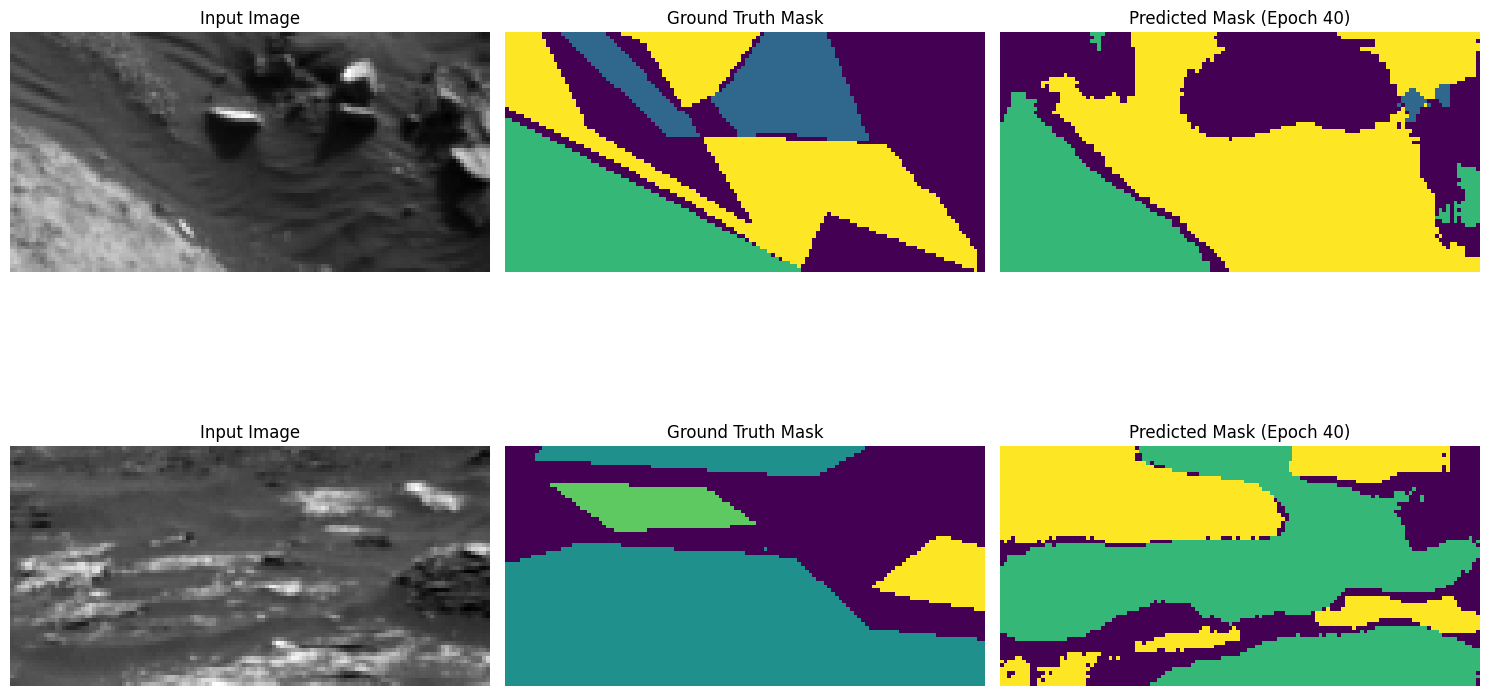

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8984 - loss: 0.2659 - mean_io_u_1: 0.6013 - mean_iou: 0.6013 - val_accuracy: 0.7626 - val_loss: 0.8194 - val_mean_io_u_1: 0.4702 - val_mean_iou: 0.4702 - learning_rate: 6.2500e-06
Epoch 41/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8999 - loss: 0.2623 - mean_io_u_1: 0.6022 - mean_iou: 0.6022Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 41: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


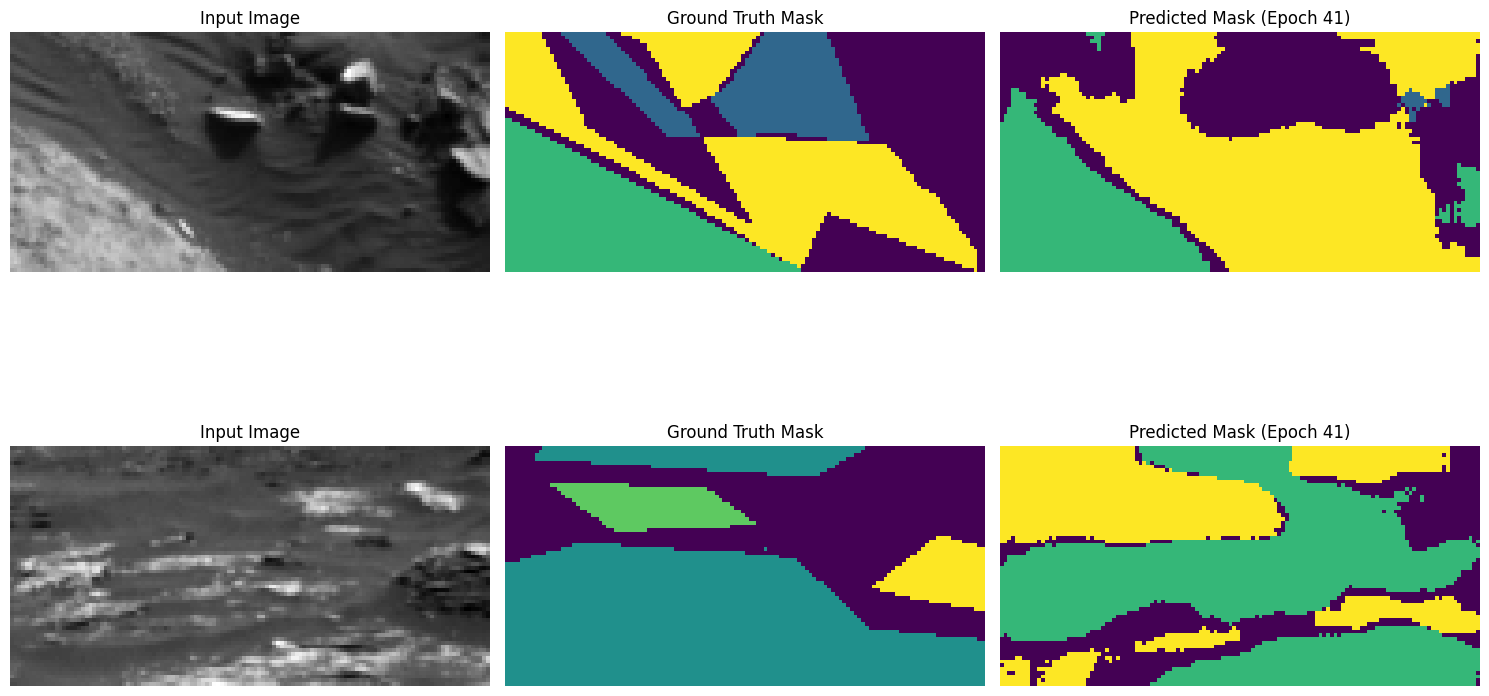

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.8999 - loss: 0.2623 - mean_io_u_1: 0.6022 - mean_iou: 0.6022 - val_accuracy: 0.7624 - val_loss: 0.8257 - val_mean_io_u_1: 0.4701 - val_mean_iou: 0.4701 - learning_rate: 6.2500e-06
Epoch 42/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9012 - loss: 0.2590 - mean_io_u_1: 0.6031 - mean_iou: 0.6031Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 42: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


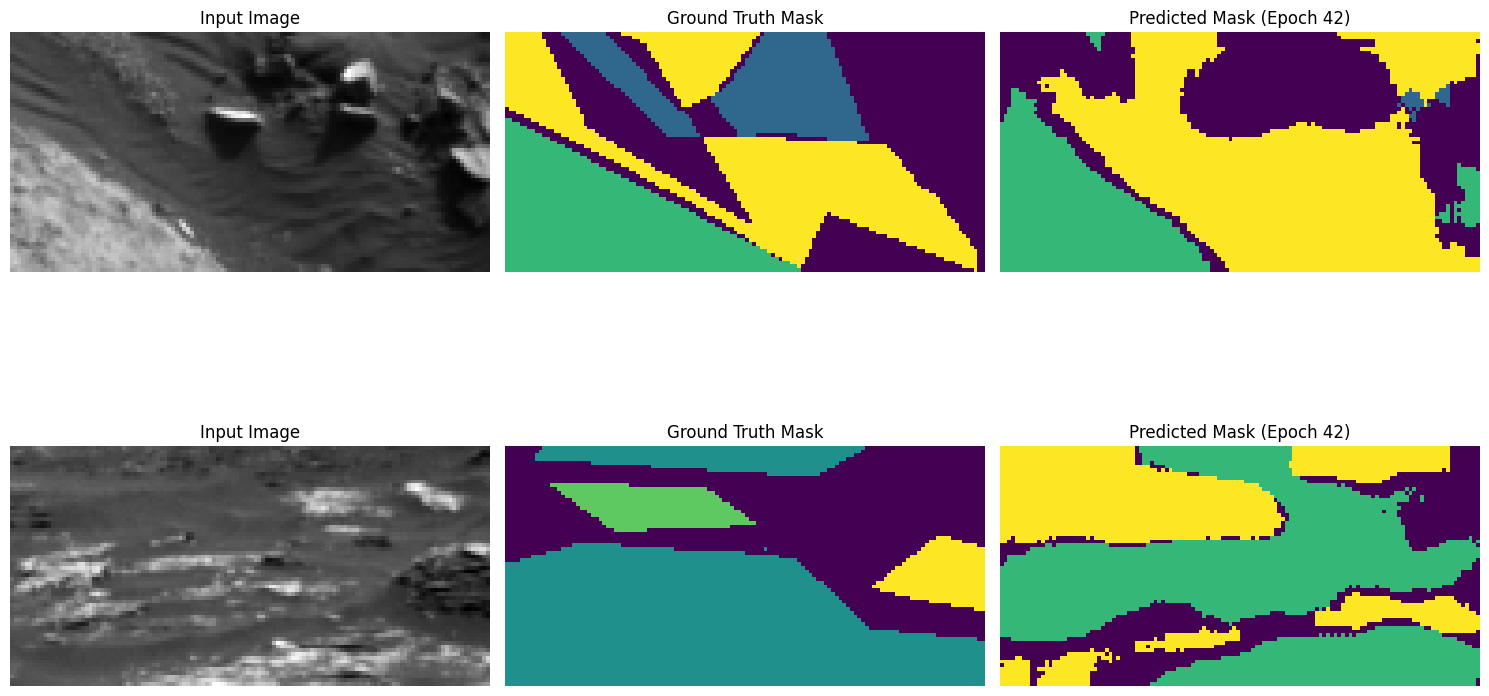

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9012 - loss: 0.2589 - mean_io_u_1: 0.6031 - mean_iou: 0.6031 - val_accuracy: 0.7622 - val_loss: 0.8319 - val_mean_io_u_1: 0.4700 - val_mean_iou: 0.4700 - learning_rate: 6.2500e-06
Epoch 43/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9026 - loss: 0.2558 - mean_io_u_1: 0.6041 - mean_iou: 0.6041Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 43: val_loss did not improve from 0.63628

Epoch 43: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


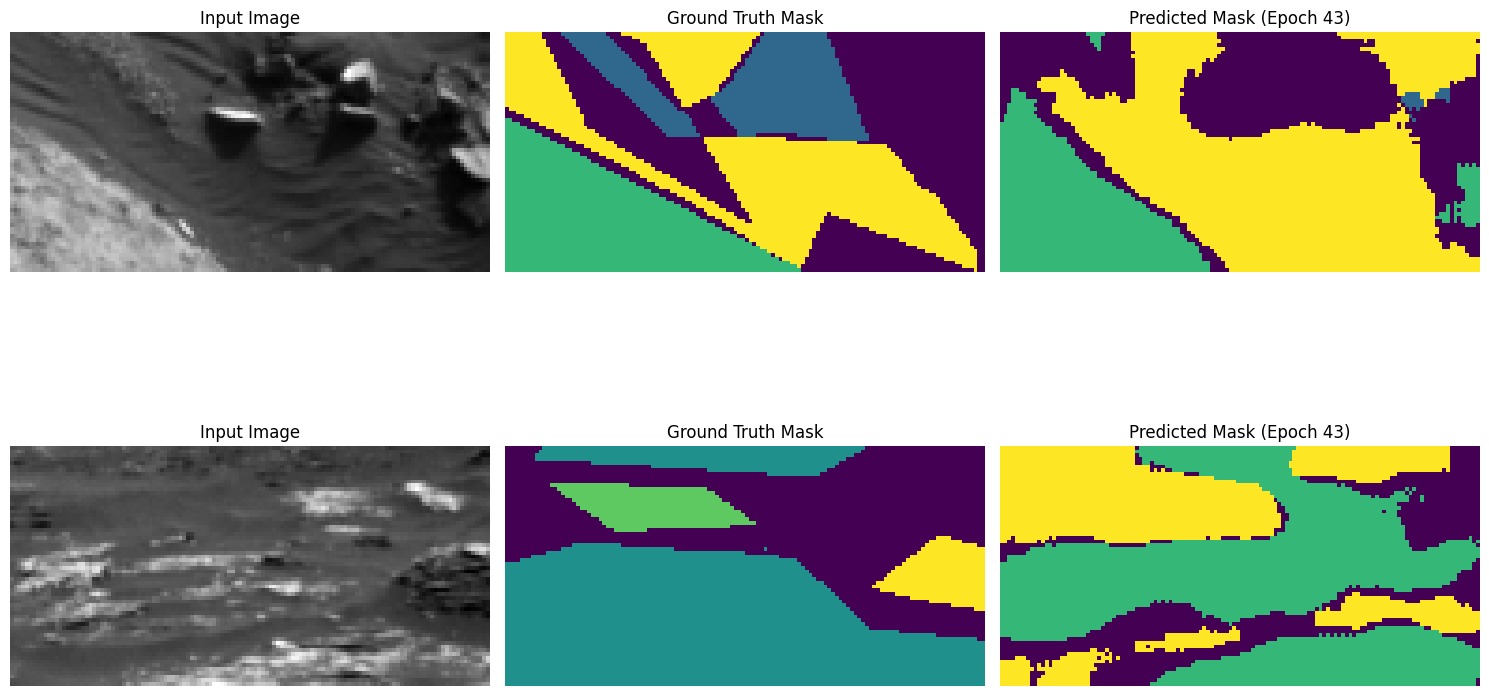

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9026 - loss: 0.2558 - mean_io_u_1: 0.6041 - mean_iou: 0.6041 - val_accuracy: 0.7620 - val_loss: 0.8382 - val_mean_io_u_1: 0.4699 - val_mean_iou: 0.4699 - learning_rate: 6.2500e-06
Epoch 44/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9040 - loss: 0.2522 - mean_io_u_1: 0.6055 - mean_iou: 0.6055Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 44: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


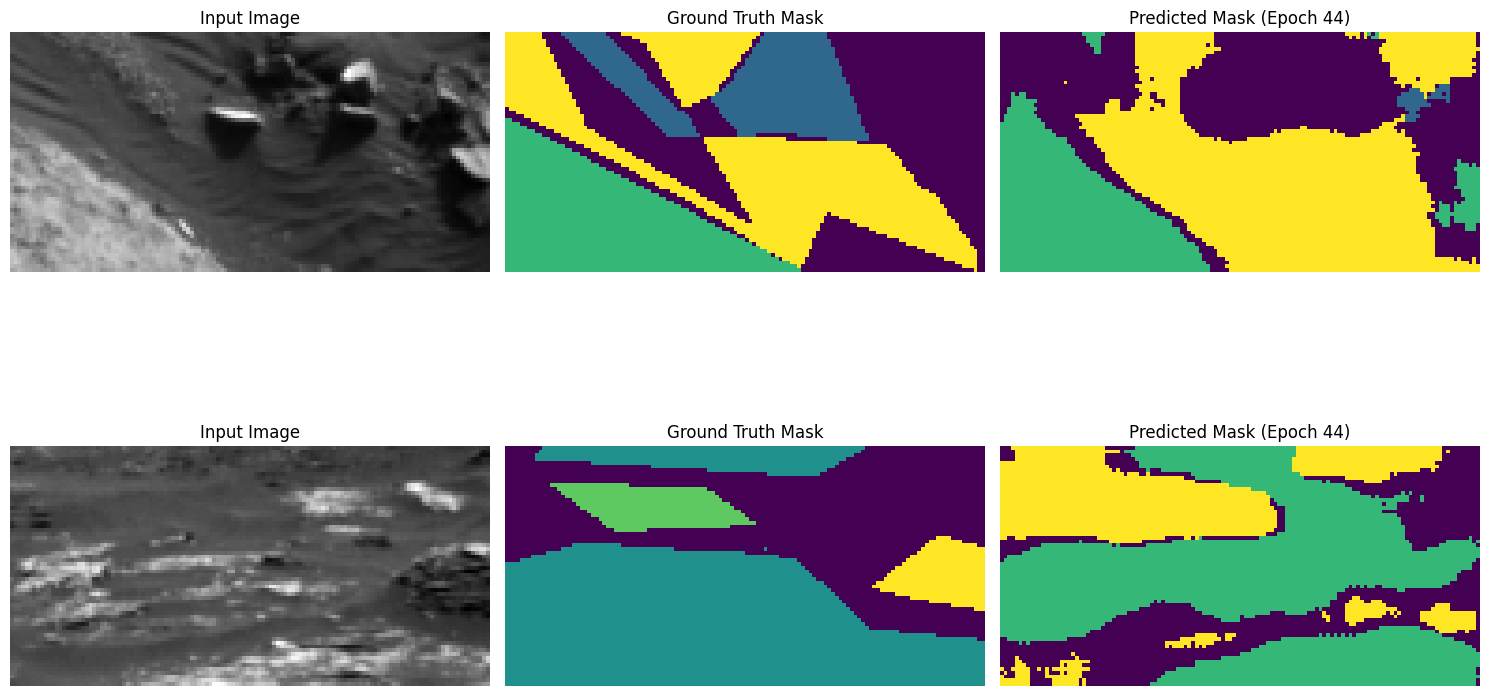

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9040 - loss: 0.2521 - mean_io_u_1: 0.6055 - mean_iou: 0.6055 - val_accuracy: 0.7616 - val_loss: 0.8454 - val_mean_io_u_1: 0.4666 - val_mean_iou: 0.4666 - learning_rate: 3.1250e-06
Epoch 45/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9049 - loss: 0.2499 - mean_io_u_1: 0.6055 - mean_iou: 0.6055Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 45: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


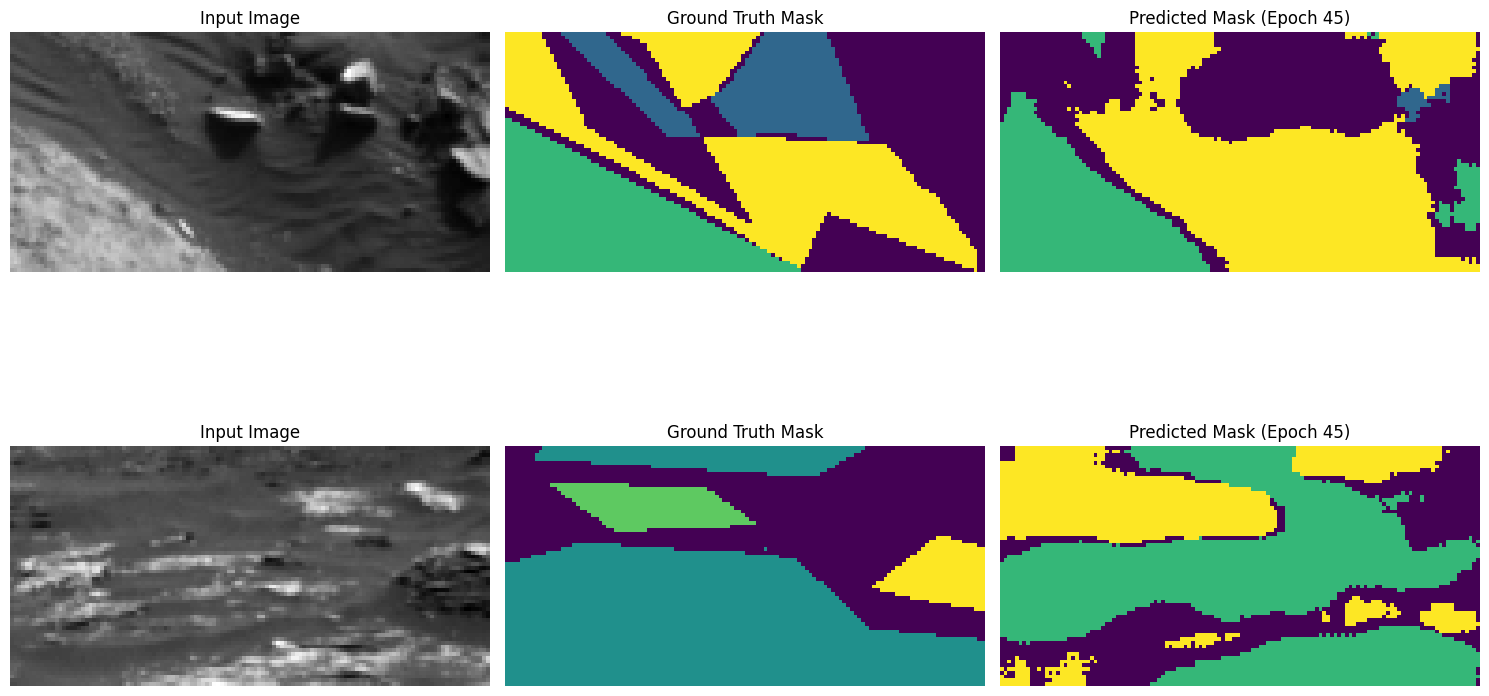

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9049 - loss: 0.2499 - mean_io_u_1: 0.6055 - mean_iou: 0.6055 - val_accuracy: 0.7615 - val_loss: 0.8490 - val_mean_io_u_1: 0.4666 - val_mean_iou: 0.4666 - learning_rate: 3.1250e-06
Epoch 46/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9057 - loss: 0.2481 - mean_io_u_1: 0.6061 - mean_iou: 0.6061Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 46: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


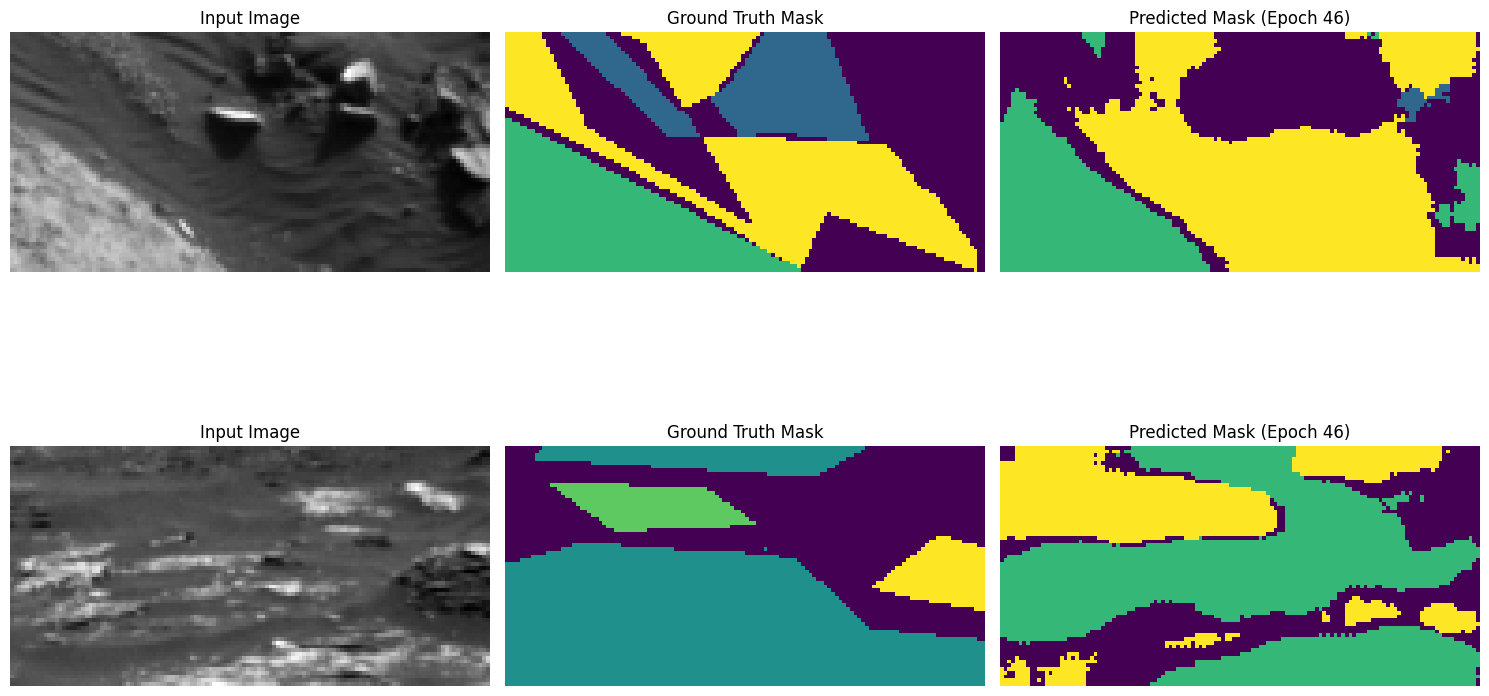

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.9057 - loss: 0.2480 - mean_io_u_1: 0.6061 - mean_iou: 0.6061 - val_accuracy: 0.7614 - val_loss: 0.8527 - val_mean_io_u_1: 0.4666 - val_mean_iou: 0.4666 - learning_rate: 3.1250e-06
Epoch 47/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9064 - loss: 0.2463 - mean_io_u_1: 0.6066 - mean_iou: 0.6066Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 47: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


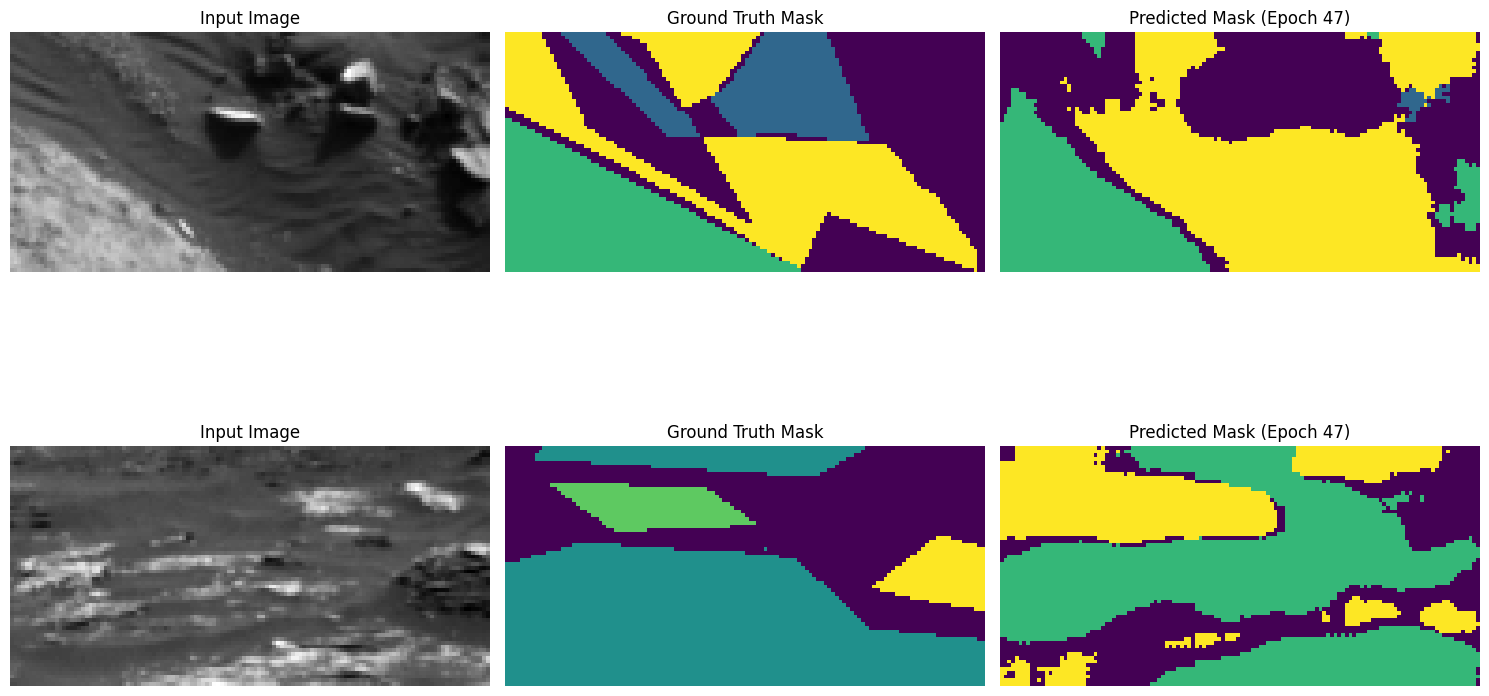

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9064 - loss: 0.2463 - mean_io_u_1: 0.6066 - mean_iou: 0.6066 - val_accuracy: 0.7612 - val_loss: 0.8564 - val_mean_io_u_1: 0.4666 - val_mean_iou: 0.4666 - learning_rate: 3.1250e-06
Epoch 48/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9071 - loss: 0.2446 - mean_io_u_1: 0.6071 - mean_iou: 0.6071Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 48: val_loss did not improve from 0.63628

Epoch 48: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


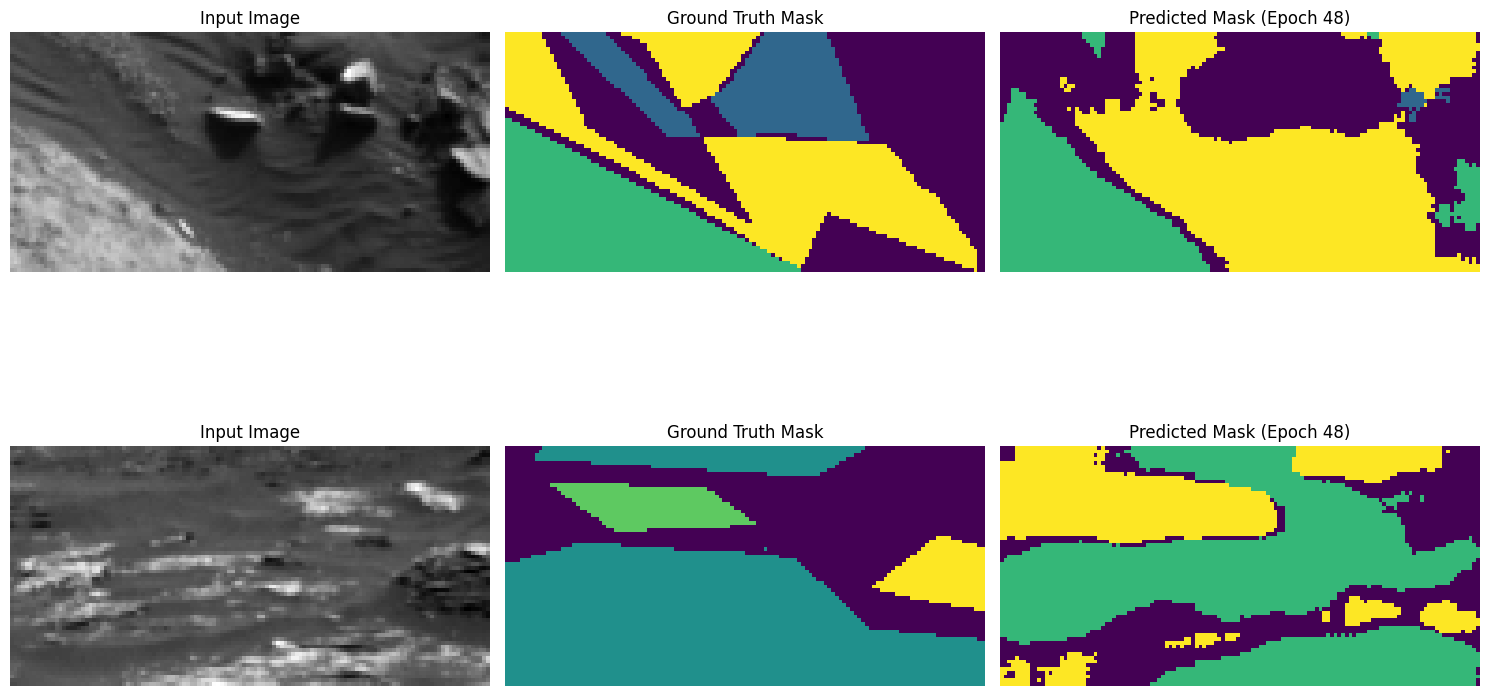

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9071 - loss: 0.2446 - mean_io_u_1: 0.6071 - mean_iou: 0.6071 - val_accuracy: 0.7611 - val_loss: 0.8601 - val_mean_io_u_1: 0.4665 - val_mean_iou: 0.4665 - learning_rate: 3.1250e-06
Epoch 49/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9078 - loss: 0.2428 - mean_io_u_1: 0.6072 - mean_iou: 0.6072Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 49: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


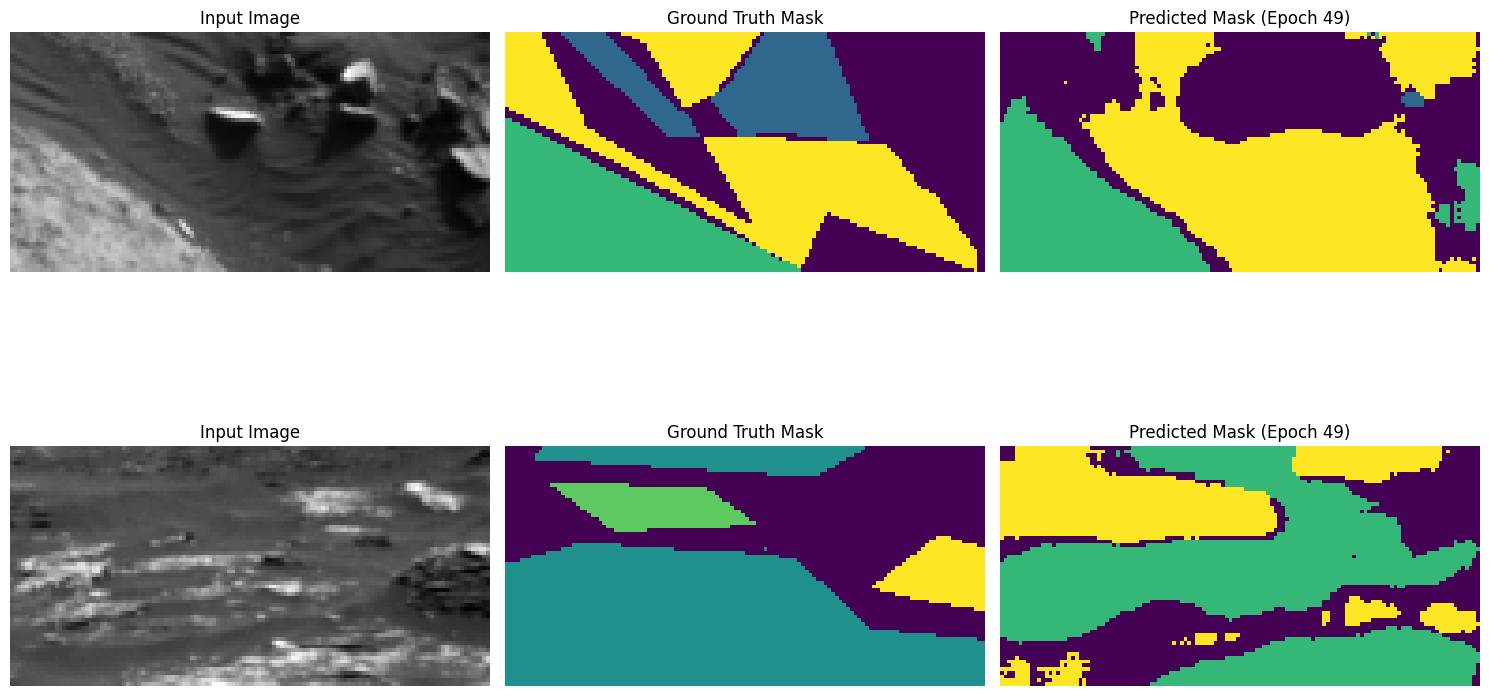

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.9078 - loss: 0.2428 - mean_io_u_1: 0.6073 - mean_iou: 0.6073 - val_accuracy: 0.7602 - val_loss: 0.8583 - val_mean_io_u_1: 0.4642 - val_mean_iou: 0.4642 - learning_rate: 1.5625e-06
Epoch 50/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9084 - loss: 0.2413 - mean_io_u_1: 0.6073 - mean_iou: 0.6073Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 50: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


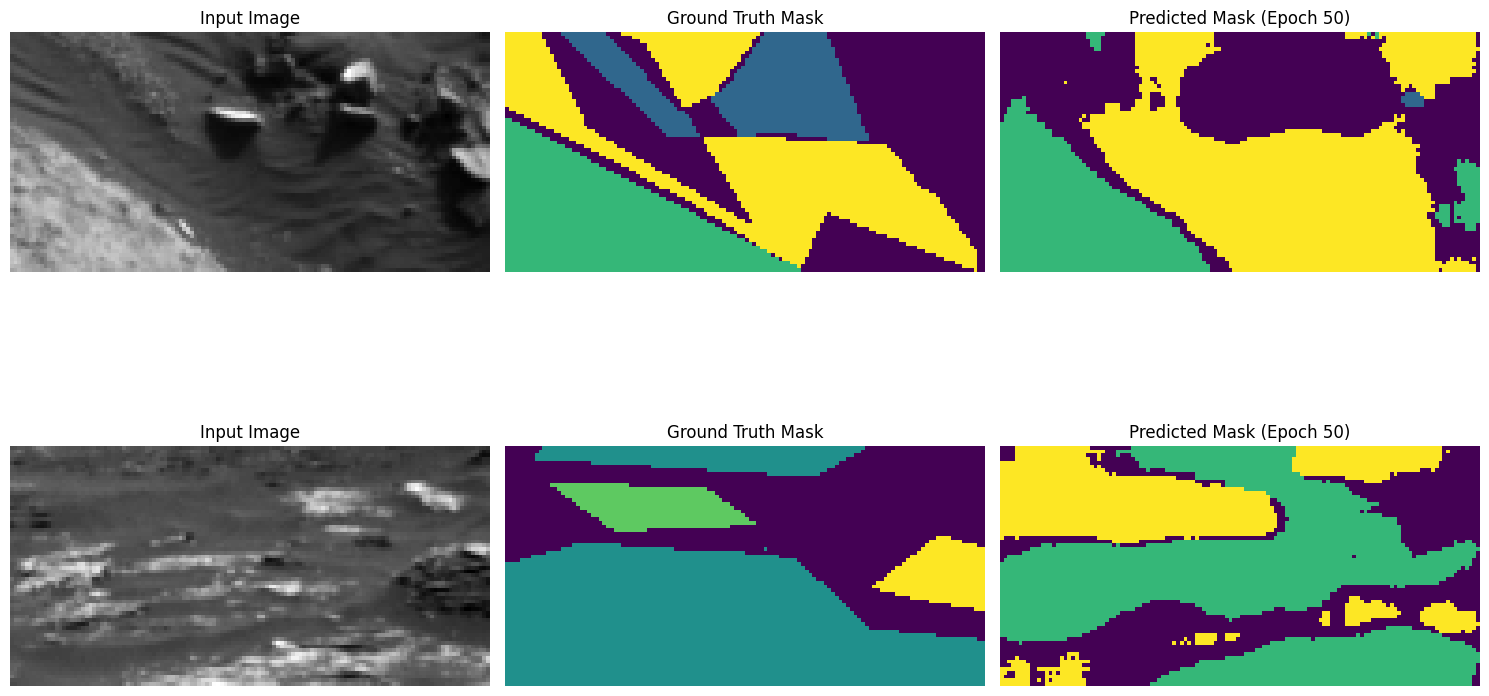

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 198ms/step - accuracy: 0.9084 - loss: 0.2412 - mean_io_u_1: 0.6073 - mean_iou: 0.6073 - val_accuracy: 0.7601 - val_loss: 0.8599 - val_mean_io_u_1: 0.4642 - val_mean_iou: 0.4642 - learning_rate: 1.5625e-06
Epoch 51/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9088 - loss: 0.2403 - mean_io_u_1: 0.6076 - mean_iou: 0.6076Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 51: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


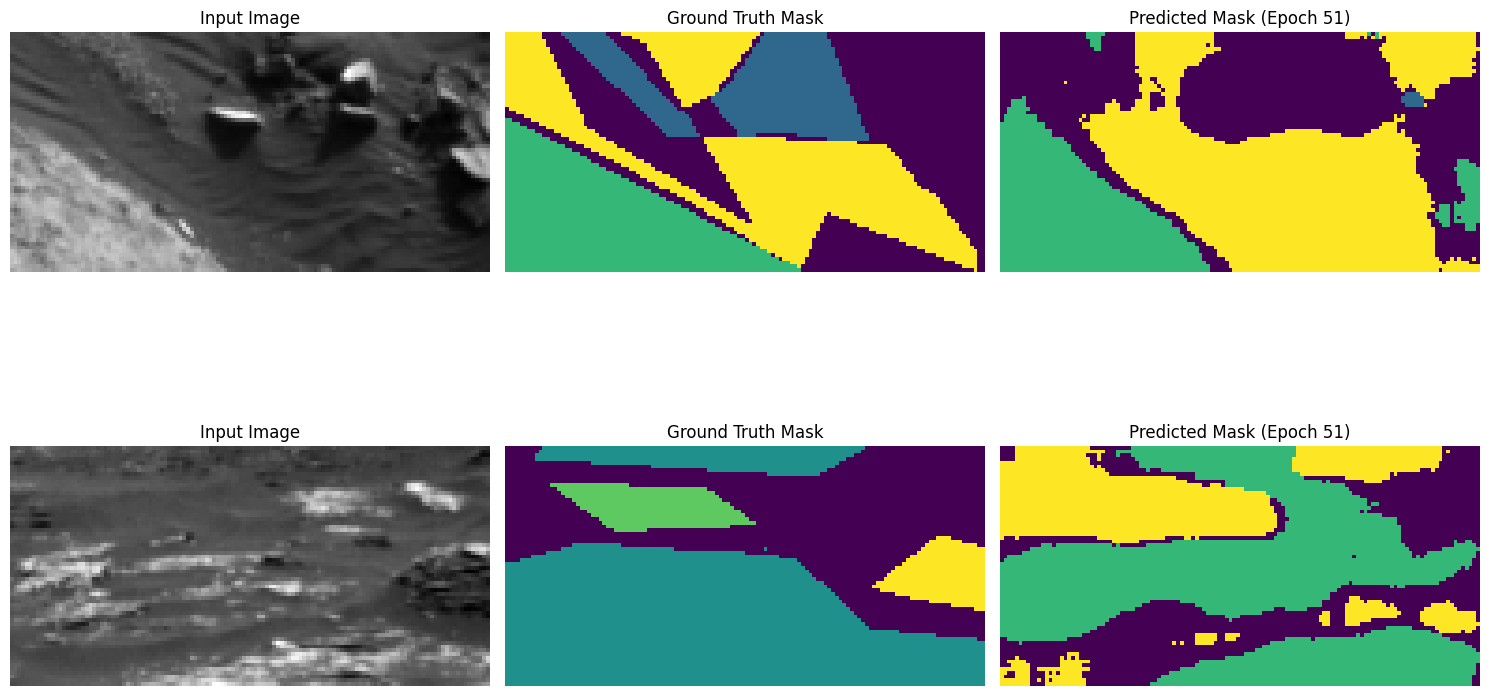

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9088 - loss: 0.2403 - mean_io_u_1: 0.6076 - mean_iou: 0.6076 - val_accuracy: 0.7600 - val_loss: 0.8617 - val_mean_io_u_1: 0.4642 - val_mean_iou: 0.4642 - learning_rate: 1.5625e-06
Epoch 52/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9092 - loss: 0.2394 - mean_io_u_1: 0.6079 - mean_iou: 0.6079Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 52: val_loss did not improve from 0.63628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


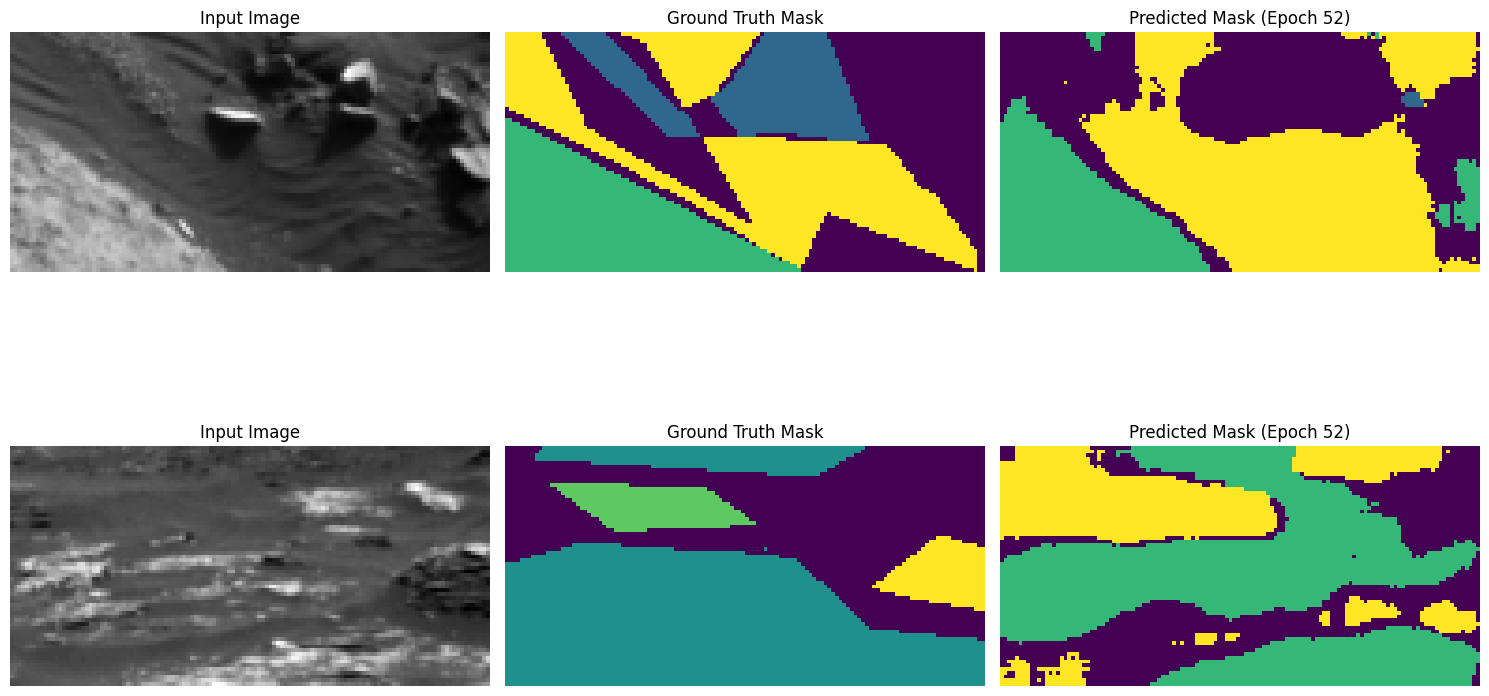

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9092 - loss: 0.2394 - mean_io_u_1: 0.6079 - mean_iou: 0.6079 - val_accuracy: 0.7599 - val_loss: 0.8636 - val_mean_io_u_1: 0.4641 - val_mean_iou: 0.4641 - learning_rate: 1.5625e-06
Epoch 53/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9095 - loss: 0.2385 - mean_io_u_1: 0.6081 - mean_iou: 0.6081Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u_1', 'val_mean_iou'])

Epoch 53: val_loss did not improve from 0.63628

Epoch 53: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


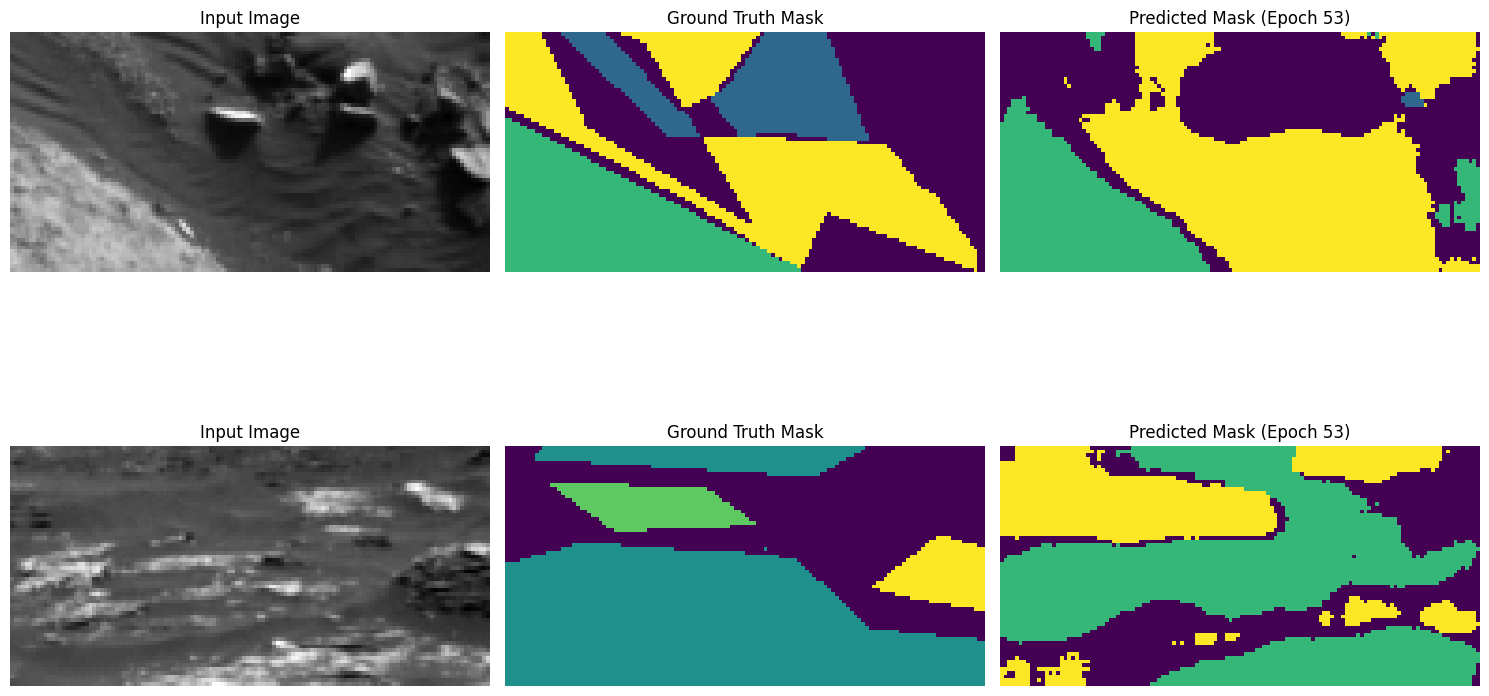

376/376 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.9095 - loss: 0.2385 - mean_io_u_1: 0.6081 - mean_iou: 0.6081 - val_accuracy: 0.7599 - val_loss: 0.8655 - val_mean_io_u_1: 0.4642 - val_mean_iou: 0.4642 - learning_rate: 1.5625e-06


In [25]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
num_classes = 5  # Replace with your number of classes
ignore_class = 0  # Class to ignore

#custom_mean_iou = CustomMeanIoU(num_classes=num_classes, ignore_class=0)

model = unet_with_residual_blocks(input_shape, num_classes)
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)
# Compile the model
model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy", mean_iou, MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])])

model.summary()
# Define callbacks
save_best_miou = SaveBestMeanIoU(filepath="best_model_mean_iou.h5", monitor="val_mean_iou", mode="max", verbose=1)


# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    #batch_size=32,
    epochs=1000,
    callbacks=[save_best_miou, early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)


In [26]:
# Load the saved model
best_model = tf.keras.models.load_model("best_model_mean_iou.h5", custom_objects={"MeanIoU": tf.keras.metrics.MeanIoU})



In [27]:
model=best_model

In [28]:
#model.load_weights("best_model_mean_iou.h5")

In [29]:
model_filename = f"model_augmented_hvr_best_invert_noise.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_augmented_hvr_best_invert_noise.keras


In [30]:
# Load the saved model
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the saved best model
#best_model = tf.keras.models.load_model("best_model_mean_iou.h5", custom_objects={"MeanIoU": tf.keras.metrics.MeanIoU})

# Predict on validation data
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=-1)  # Convert to class predictions

# Reshape the true labels to match the predictions
y_val_true = y_val.squeeze()  # Remove channel dimension if present

# Initialize variables to store IoU per class
num_classes = 5
ious = []

# Compute IoU for each class
for class_id in range(1,num_classes):
    true_class = (y_val_true == class_id).astype(int)
    pred_class = (y_val_pred_classes == class_id).astype(int)
    intersection = np.sum(true_class * pred_class)
    union = np.sum(true_class + pred_class) - intersection
    iou = intersection / union if union > 0 else 0.0
    ious.append(iou)
    print(f"Class {class_id} IoU: {iou:.4f}")

# Display mean IoU
mean_iou = np.mean([iou for iou in ious])  # Exclude zero IoUs
print(f"Mean IoU (excluding zero IoUs): {mean_iou:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Class 1 IoU: 0.7473
Class 2 IoU: 0.6035
Class 3 IoU: 0.7139
Class 4 IoU: 0.0390
Mean IoU (excluding zero IoUs): 0.5259


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [31]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [32]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [33]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step
Predictions shape: (10022, 64, 128)


In [34]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels

# Replace predicted class 0 with class 4
preds[preds == 0] = 4
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step
Predictions shape: (10022, 64, 128)
314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


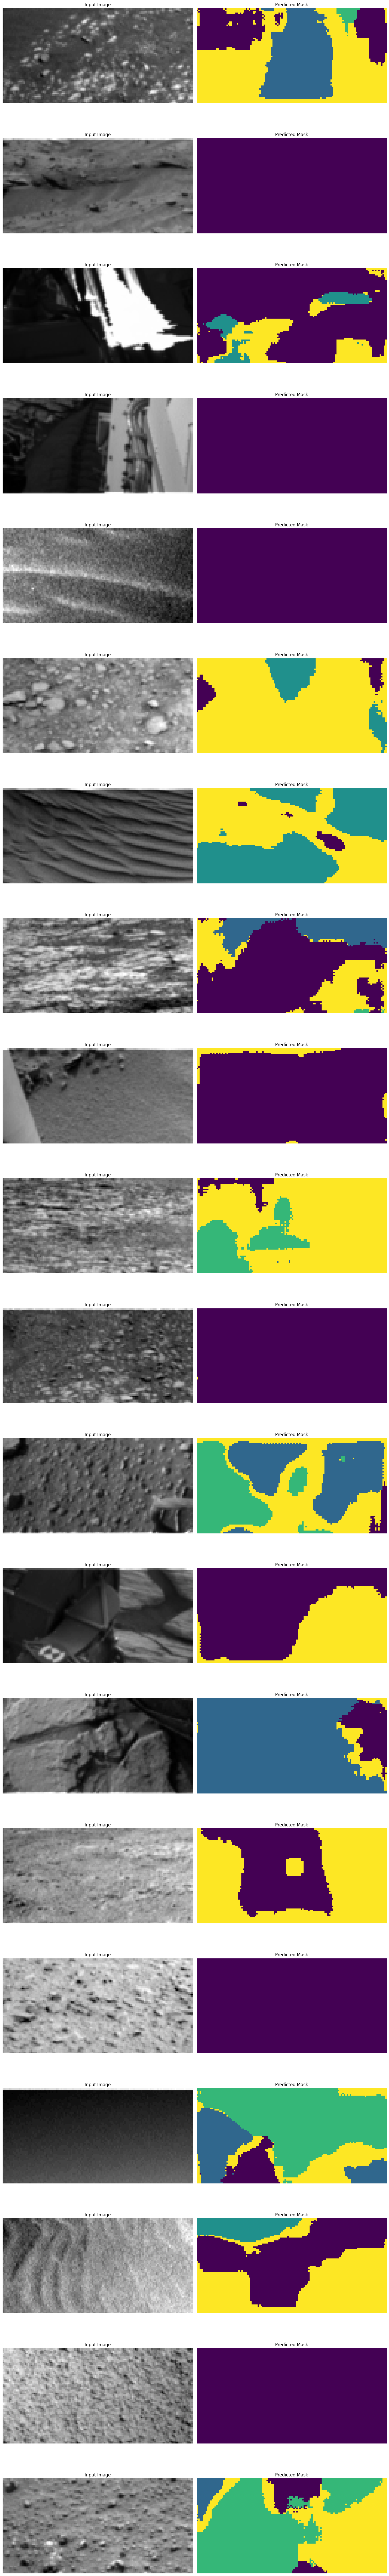

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [36]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [37]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [38]:
len(submission_df.columns)

8193

In [39]:
len(submission_df)

10022

314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step

Class 0:
  Min Probability: 0.0000
  Max Probability: 1.0000
  Mean Probability: 0.2801
  Std Deviation: 0.3551

Class 1:
  Min Probability: 0.0000
  Max Probability: 1.0000
  Mean Probability: 0.2974
  Std Deviation: 0.4136

Class 2:
  Min Probability: 0.0000
  Max Probability: 1.0000
  Mean Probability: 0.2531
  Std Deviation: 0.3919

Class 3:
  Min Probability: 0.0000
  Max Probability: 1.0000
  Mean Probability: 0.1678
  Std Deviation: 0.3424

Class 4:
  Min Probability: 0.0000
  Max Probability: 1.0000
  Mean Probability: 0.0015
  Std Deviation: 0.0197


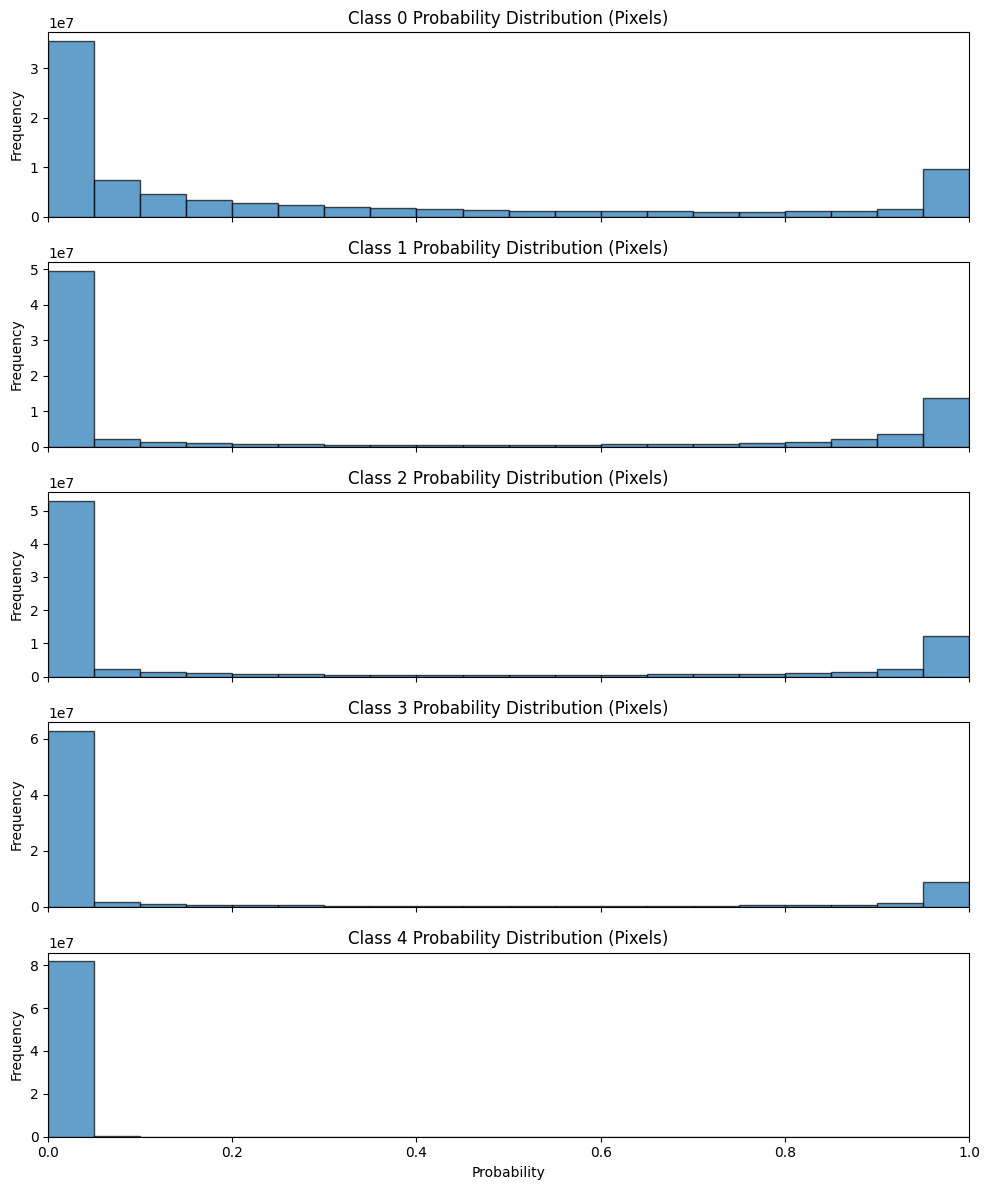

In [40]:
# Step 1: Get model predictions
pred_probs = model.predict(X_test)  # Shape: (num_samples, height, width, num_classes)

# Step 2: Flatten spatial dimensions
flat_probs = pred_probs.reshape(-1, pred_probs.shape[-1])  # Shape: (total_pixels, num_classes)

# Step 3: Calculate statistics
stats = {}
for class_idx in range(flat_probs.shape[1]):
    class_probs = flat_probs[:, class_idx]
    stats[f'Class {class_idx}'] = {
        'Min Probability': np.min(class_probs),
        'Max Probability': np.max(class_probs),
        'Mean Probability': np.mean(class_probs),
        'Std Deviation': np.std(class_probs)
    }

# Print statistics
for class_name, class_stats in stats.items():
    print(f"\n{class_name}:")
    for stat_name, value in class_stats.items():
        print(f"  {stat_name}: {value:.4f}")

# Step 4: Plot histograms
import matplotlib.pyplot as plt

num_classes = pred_probs.shape[-1]
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 12), sharex=True)

for class_idx in range(num_classes):
    # Extract probabilities for the current class
    class_probs = flat_probs[:, class_idx]
    
    # Plot histogram for the current class
    axes[class_idx].hist(class_probs, bins=20, range=(0, 1), alpha=0.7, edgecolor='black')
    axes[class_idx].set_title(f'Class {class_idx} Probability Distribution (Pixels)')
    axes[class_idx].set_ylabel('Frequency')
    axes[class_idx].set_xlim(0, 1)

# Add shared x-axis label
axes[-1].set_xlabel('Probability')
plt.tight_layout()
plt.show()


314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step

Class 0:
  Min Probability: 0.2559
  Max Probability: 1.0000
  Mean Probability: 0.8360
  Std Deviation: 0.1839

Class 1:
  Min Probability: 0.2492
  Max Probability: 1.0000
  Mean Probability: 0.8938
  Std Deviation: 0.1402

Class 2:
  Min Probability: 0.2444
  Max Probability: 1.0000
  Mean Probability: 0.8888
  Std Deviation: 0.1523

Class 3:
  Min Probability: 0.2545
  Max Probability: 1.0000
  Mean Probability: 0.9064
  Std Deviation: 0.1429

Class 4:
  Min Probability: 0.2669
  Max Probability: 1.0000
  Mean Probability: 0.7167
  Std Deviation: 0.1893


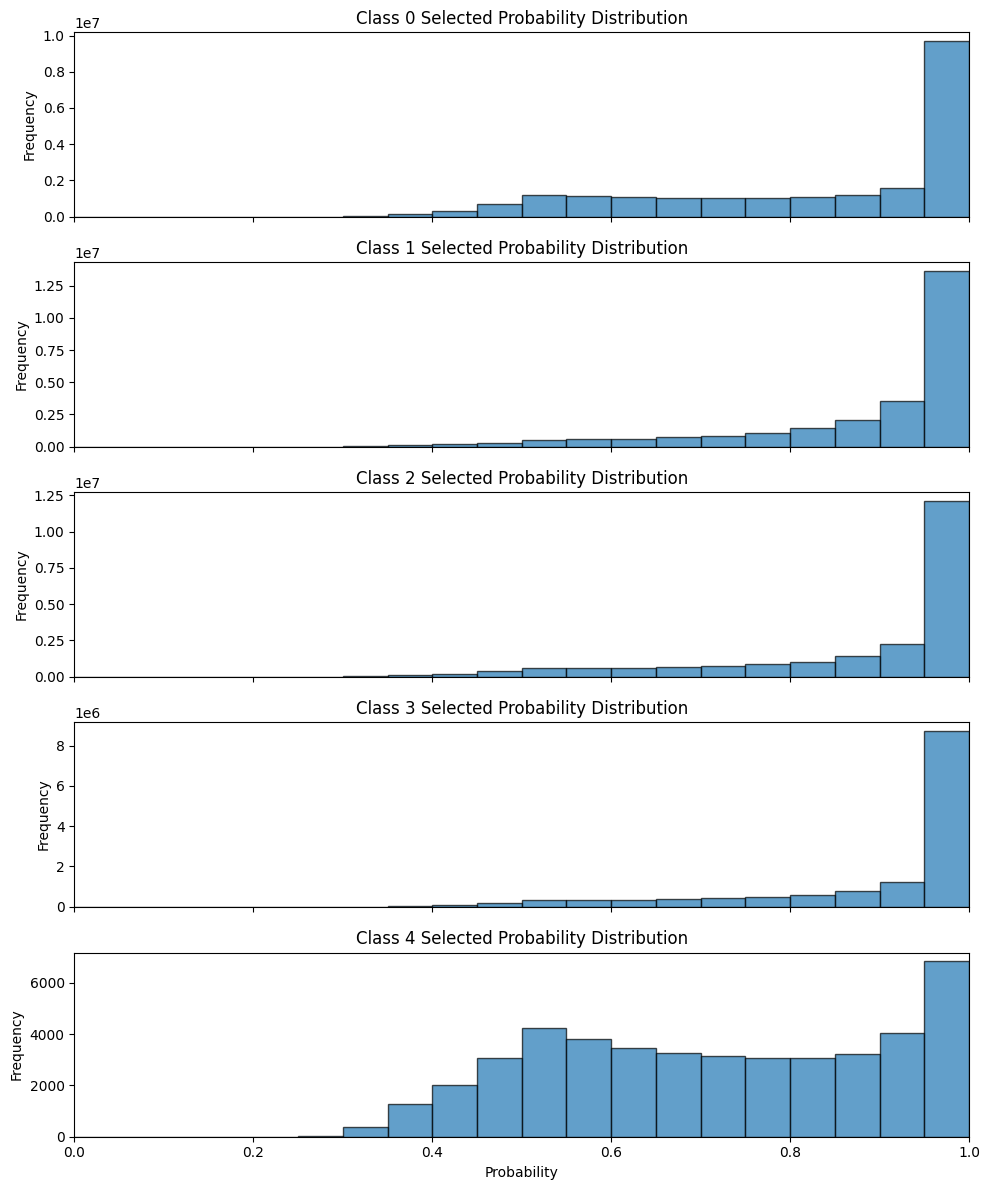

In [41]:
# Step 1: Get model predictions
pred_probs = model.predict(X_test)  # Shape: (num_samples, height, width, num_classes)

# Step 2: Get selected classes and their probabilities
selected_classes = np.argmax(pred_probs, axis=-1)  # Shape: (num_samples, height, width)
selected_probs = np.max(pred_probs, axis=-1)       # Shape: (num_samples, height, width)

# Flatten arrays for easier processing
flat_selected_classes = selected_classes.flatten()
flat_selected_probs = selected_probs.flatten()

# Step 3: Calculate statistics for each class
stats = {}
for class_idx in range(pred_probs.shape[-1]):
    class_mask = flat_selected_classes == class_idx
    class_probs = flat_selected_probs[class_mask]
    if len(class_probs) > 0:
        stats[f'Class {class_idx}'] = {
            'Min Probability': np.min(class_probs),
            'Max Probability': np.max(class_probs),
            'Mean Probability': np.mean(class_probs),
            'Std Deviation': np.std(class_probs)
        }
    else:
        stats[f'Class {class_idx}'] = {
            'Min Probability': None,
            'Max Probability': None,
            'Mean Probability': None,
            'Std Deviation': None
        }

# Print statistics
for class_name, class_stats in stats.items():
    print(f"\n{class_name}:")
    for stat_name, value in class_stats.items():
        if value is not None:
            print(f"  {stat_name}: {value:.4f}")
        else:
            print(f"  {stat_name}: No pixels for this class")

# Step 4: Plot histograms for all classes
import matplotlib.pyplot as plt

num_classes = pred_probs.shape[-1]
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 12), sharex=True)

for class_idx in range(num_classes):
    class_mask = flat_selected_classes == class_idx
    class_probs = flat_selected_probs[class_mask]
    
    if len(class_probs) > 0:
        axes[class_idx].hist(class_probs, bins=20, range=(0, 1), alpha=0.7, edgecolor='black')
        axes[class_idx].set_title(f'Class {class_idx} Selected Probability Distribution')
        axes[class_idx].set_ylabel('Frequency')
        axes[class_idx].set_xlim(0, 1)
    else:
        axes[class_idx].set_title(f'Class {class_idx}: No Pixels')
        axes[class_idx].set_ylabel('Frequency')

# Add shared x-axis label
axes[-1].set_xlabel('Probability')
plt.tight_layout()
plt.show()


In [58]:
rare_class_threshold = 0.5  # Lower for rare class
common_class_threshold = 0.8  # Higher for other classes
    

In [62]:
# Get class predictions and confidence scores
pseudo_labels = np.argmax(pred_probs, axis=-1)  # Predicted classes
confidence_scores = np.max(pred_probs, axis=-1)  # Confidence of predictions

# Create a mask for high-confidence predictions
high_confidence_mask = np.zeros_like(confidence_scores, dtype=bool)

for class_idx in range(pred_probs.shape[-1]):
    if class_idx == 4:  # Rare class
        high_confidence_mask |= (pseudo_labels == class_idx) & (confidence_scores > rare_class_threshold)
    else:  # Common classes
        high_confidence_mask |= (pseudo_labels == class_idx) & (confidence_scores > common_class_threshold)

# Filter pseudo-labeled data
pseudo_data = X_test[high_confidence_mask]
pseudo_labels_filtered = pseudo_labels[high_confidence_mask]


In [63]:
# Create high-confidence mask for pseudo-labels
high_confidence_mask = (confidence_scores > rare_class_threshold) | (confidence_scores > common_class_threshold)  # Shape: (num_samples, height, width)

# Expand the mask to match the shape of X_test
high_confidence_mask_expanded = high_confidence_mask[..., np.newaxis]  # Shape: (num_samples, height, width, 1)


In [66]:
# Filter X_test using the mask
pseudo_data = X_test * high_confidence_mask_expanded  # Shape: (num_samples, height, width, channels)

# Verify the shape
print("Pseudo data shape:", pseudo_data.shape)
# Apply the mask to pseudo_labels (3D)
pseudo_labels_filtered = pseudo_labels * high_confidence_mask  # Shape: (num_samples, height, width)

# Verify the shape
print("Pseudo labels filtered shape:", pseudo_labels_filtered.shape)


Pseudo data shape: (10022, 64, 128, 1)
Pseudo labels filtered shape: (10022, 64, 128)


In [67]:
X_combined = np.concatenate([X_train, pseudo_data], axis=0)  # Shape: (num_samples_combined, height, width, channels)
y_combined = np.concatenate([y_train, pseudo_labels_filtered], axis=0)  # Shape: (num_samples_combined, height, width)


In [68]:
print("X_train shape:", X_train.shape)
print("pseudo_data shape:", pseudo_data.shape)
print("y_train shape:", y_train.shape)
print("pseudo_labels_filtered shape:", pseudo_labels_filtered.shape)


X_train shape: (12024, 64, 128, 1)
pseudo_data shape: (10022, 64, 128, 1)
y_train shape: (12024, 64, 128)
pseudo_labels_filtered shape: (10022, 64, 128)


In [71]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["accuracy", mean_iou, MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])])


In [ ]:
history = model.fit(
    X_combined,
    y_combined,
    validation_split=0.2,  # Reserve 20% of data for validation
    epochs=20,            # Adjust as needed
    batch_size=16,        # Adjust based on GPU/CPU resources
    shuffle=True
)


In [ ]:
class_weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 2.0}  # Adjust as needed


In [ ]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels

# Replace predicted class 0 with class 4
preds[preds == 0] = 4
print(f"Predictions shape: {preds.shape}")